In [2]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import collections 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

from mdl_eval_tools import kl,logloss
from pprint import pprint
from rayleigh_pr import rayleigh_pr
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

pd.options.display.max_colwidth = 100

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import scipy.stats as stats

def makefig_population_loglossdeltas(deltas_df,medians_df,df_delta_column_name,sig_thresh,scale_sig_marks):
    """df: pandas df, e.g. theta_deltas_df,
    medians_df: pandas df, computation example: 
        medians_df = deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
    df_delta_column_name: string, e.g. 'delta_cshortminshort'"""
    
    #first add the median log loss delta df -- this is how you will eventually
    #order the boxplot 
    wmed_df = deltas_df.join(medians_df.set_index('cell_id'), on='cell_id',rsuffix='_median')
    
    #compute the one-tailed t-statistic to ask: is the distribution of log loss 
    #deltas significantly smaller than zero? 
    cell_list = list(set(wmed_df['cell_id'].to_list()))
    delta_results = []

    for cell in cell_list: 

        sub = wmed_df[wmed_df['cell_id']==cell]

        data = sub[df_delta_column_name].values
        t = stats.ttest_1samp(a=data,popmean=0,alternative='less')

        tstat = t[0]
        pval = t[1]

        delta_results.append({'cell_id': cell,
                              'tstat': tstat,
                              'pval': pval
                             })

    results_df = pd.DataFrame(delta_results)

    results_df = wmed_df.join(results_df.set_index('cell_id'), on='cell_id',rsuffix='_ttest_results')

    #find and mark the significant cells according to the threshold value
    significant = []

    for i in results_df['pval'].values:

        if i < sig_thresh:
            significant.append(1)

        else: 
            significant.append(0)
            
    results_df['significant'] = significant
    #this is just so that the plus signs marking a sig result can print to the same scale as the boxplot figs
    results_df['significant_scaled'] = results_df['significant'].div(scale_sig_marks)
    
    return results_df

def makefig_population_loglossdeltas_1tailedttest_geq0(deltas_df,medians_df,df_delta_column_name,sig_thresh,scale_sig_marks):
    """df: pandas df, e.g. theta_deltas_df,
    medians_df: pandas df, computation example: 
        medians_df = deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
    df_delta_column_name: string, e.g. 'delta_cshortminshort'"""
    
    #first add the median log loss delta df -- this is how you will eventually
    #order the boxplot 
    wmed_df = deltas_df.join(medians_df.set_index('cell_id'), on='cell_id',rsuffix='_median')
    
    #compute the one-tailed t-statistic to ask: is the distribution of log loss 
    #deltas significantly smaller than zero? 
    cell_list = list(set(wmed_df['cell_id'].to_list()))
    delta_results = []

    for cell in cell_list: 

        sub = wmed_df[wmed_df['cell_id']==cell]

        data = sub[df_delta_column_name].values
        t = stats.ttest_1samp(a=data,popmean=0,alternative='greater')

        tstat = t[0]
        pval = t[1]

        delta_results.append({'cell_id': cell,
                              'tstat': tstat,
                              'pval': pval
                             })

    results_df = pd.DataFrame(delta_results)

    results_df = wmed_df.join(results_df.set_index('cell_id'), on='cell_id',rsuffix='_ttest_results')

    #find and mark the significant cells according to the threshold value
    significant = []

    for i in results_df['pval'].values:

        if i < sig_thresh:
            significant.append(1)

        else: 
            significant.append(0)
            
    results_df['significant'] = significant
    #this is just so that the plus signs marking a sig result can print to the same scale as the boxplot figs
    results_df['significant_scaled'] = results_df['significant'].div(scale_sig_marks)
    
    return results_df


def make_significance_column(df,pval_colname,sig_thresh,scale_sig_marks,significance_colname):
    
    #find and mark the significant cells according to the threshold value
    significant = []

    for i in df[pval_colname].values:

        if i < sig_thresh:
            significant.append(1)

        else: 
            significant.append(0)
            
    df[significance_colname] = significant
    #this is just so that the plus signs marking a sig result can print to the same scale as the boxplot figs
    sigscale_colname = significance_colname + '_scaled'
    df[sigscale_colname] = df[significance_colname].div(scale_sig_marks)
    
    return df

### approach epoch population log loss deltas

In [6]:
rhythm = 'theta' 
longhist = '250ms'
deltas = []
for fold in tqdm(range(20)):

#     foldpath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/' + rhythm + 'phase_' + longhist + '/folds/' + str(fold) +'/single_neuron/'
    
    foldpath = 'RESULTS/PHASE_HIST_MODELS_highvapproach_all_realcells/starintlogoddsCompleteSinglePredMdls177/' + rhythm + '_' + longhist + '/folds/' + str(fold) 
    folders = os.listdir(foldpath)
    len(folders)
    
    for folder in folders:
        
        nrnpath = os.path.join(foldpath,folder)
        
        probs_test = pd.read_csv(os.path.join(nrnpath,'probs_models_test.csv'), 
                                 usecols=['p_cshort','p_hshort','p_clong'])
        
        test_data = pd.read_csv(os.path.join(nrnpath,'test_data.csv'), usecols=['spikes'])
        
        y = test_data['spikes']
        
        cshort_loss, _, _ = logloss(probs_test['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        clong_loss, _, _ = logloss(probs_test['p_clong'],y)
        
        tmp_delta_cshminhsh = cshort_loss - hshort_loss
        tmp_delta_cshmincln = cshort_loss - clong_loss
      
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        
#         all_kls = kl(probs_test['p_cshort'],probs_test['p_hshort'])
#         avg_kl = np.mean(all_kls)
        
        deltas.append({'cell_id': folder,
                       'fold': fold,
                       'delta_cshortminhshort': tmp_delta_cshminhsh,
                       'delta_cshortminclong': tmp_delta_cshmincln
                       #'avg_kl_cshort_v_hshort': avg_kl
                      })
        
        
int_theta_approach_deltas_df = pd.DataFrame(deltas)

 55%|███████████████████████                   | 11/20 [33:16<27:29, 183.28s/it]/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:100: RuntimeWarning: divide by zero encountered in log2
  avg_loss += -np.log2(probs[i])
/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:101: RuntimeWarning: divide by zero encountered in log2
  all_loss.append(-np.log2(probs[i]))
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
100%|████████████████████████████████████████| 20/20 [1:01:23<00:00, 184.15s/it]


In [3]:
int_theta_approach_deltas_df.to_csv('RESULTS/logloss_deltas_approach_theta_20folds.csv')

NameError: name 'int_theta_approach_deltas_df' is not defined

In [9]:
rhythm = 'lowgamma' 
longhist = '250ms'
deltas = []
for fold in tqdm(range(20)):

#     foldpath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/' + rhythm + 'phase_' + longhist + '/folds/' + str(fold) +'/single_neuron/'
    
    foldpath = 'RESULTS/PHASE_HIST_MODELS_highvapproach_all_realcells/starintlogoddsCompleteSinglePredMdls177/' + rhythm + '_' + longhist + '/folds/' + str(fold) 
    folders = os.listdir(foldpath)
    len(folders)
    
    for folder in folders:
        
        nrnpath = os.path.join(foldpath,folder)
        
        probs_test = pd.read_csv(os.path.join(nrnpath,'probs_models_test.csv'), 
                                 usecols=['p_cshort','p_hshort','p_clong'])
        
        test_data = pd.read_csv(os.path.join(nrnpath,'test_data.csv'), usecols=['spikes'])
        
        y = test_data['spikes']
        
        cshort_loss, _, _ = logloss(probs_test['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        clong_loss, _, _ = logloss(probs_test['p_clong'],y)
        
        tmp_delta_cshminhsh = cshort_loss - hshort_loss
        tmp_delta_cshmincln = cshort_loss - clong_loss
      
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        
#         all_kls = kl(probs_test['p_cshort'],probs_test['p_hshort'])
#         avg_kl = np.mean(all_kls)
        
        deltas.append({'cell_id': folder,
                       'fold': fold,
                       'delta_cshortminhshort': tmp_delta_cshminhsh,
                       'delta_cshortminclong': tmp_delta_cshmincln
                       #'avg_kl_cshort_v_hshort': avg_kl
                      })
        
        
int_lowgamma_approach_deltas_df = pd.DataFrame(deltas)

100%|████████████████████████████████████████| 20/20 [1:04:22<00:00, 193.14s/it]


In [10]:
int_lowgamma_approach_deltas_df.to_csv('RESULTS/logloss_deltas_approach_lowgamma_20folds.csv')

## load saved dfs for approach epoch

In [3]:
int_lowgamma_approach_deltas_df = pd.read_csv('RESULTS/logloss_deltas_approach_lowgamma_20folds.csv')
int_theta_approach_deltas_df = pd.read_csv('RESULTS/logloss_deltas_approach_theta_20folds.csv')



Check what fraction of population has complete long models that outperform complete short models

In [11]:
sig_thresh = 0.001
scale_sig_marks = 50

lowgamma_cshortminclong_results_df_clongbetter = makefig_population_loglossdeltas_1tailedttest_geq0(int_lowgamma_approach_deltas_df,
                                                                                                    lowgamma_medians_df,
                                                                                                    'delta_cshortminclong',
                                                                                                    sig_thresh,
                                                                                                    scale_sig_marks)



In [13]:
print('cshort min clong sig interneurons: ', list(set(lowgamma_cshortminclong_results_df_clongbetter.groupby('fold').sum()['significant'].to_list())))


cshort min clong sig interneurons:  [43]


In [4]:
sig_thresh = 0.001
scale_sig_marks = 50
lowgamma_medians_df = int_lowgamma_approach_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
lowgamma_results_df = makefig_population_loglossdeltas(int_lowgamma_approach_deltas_df,
                                                    lowgamma_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


lowgamma_cshortminclong_results_df = makefig_population_loglossdeltas(int_lowgamma_approach_deltas_df,
                                                                   lowgamma_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



In [5]:
print('cshort min hshort sig interneurons: ', list(set(lowgamma_results_df.groupby('fold').sum()['significant'].to_list())))
print('cshort min clong sig interneurons: ', list(set(lowgamma_cshortminclong_results_df.groupby('fold').sum()['significant'].to_list())))


cshort min hshort sig interneurons:  [12]
cshort min clong sig interneurons:  [72]


In [30]:
import scipy.io as sio
datapath = 'python_approach_highestv_data/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
ray_df = []

rhythm = 'lowgamma'
for file in tqdm(files):
    
    matfile = sio.loadmat(os.path.join(datapath,file))
    
    df = pd.DataFrame()

    df['spikes'] = matfile['spikes_long'].tolist()[0]
    df['lowgamma_35_55_phases'] = matfile[rhythm+'_35to55_phase_long'].tolist()[0]
        
    tmp = rayleigh_pr(df,'lowgamma_35_55')
    tmp['cell_id'] = file
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)  

int_lowgamma_all_results_df = pd.merge(lowgamma_results_df, raypop_df, on='cell_id')
int_lowgamma_all_results_df = make_significance_column(int_lowgamma_all_results_df,'pval_y',0.001,60,'ray_significant_scaled')

int_lowgamma_cshortminclong_ray_df = pd.merge(lowgamma_cshortminclong_results_df, raypop_df, on='cell_id')
int_lowgamma_cshortminclong_ray_df = make_significance_column(int_lowgamma_cshortminclong_ray_df,'pval_y',0.001,40,'ray_significant_scaled')


100%|█████████████████████████████████████████| 134/134 [00:25<00:00,  5.20it/s]


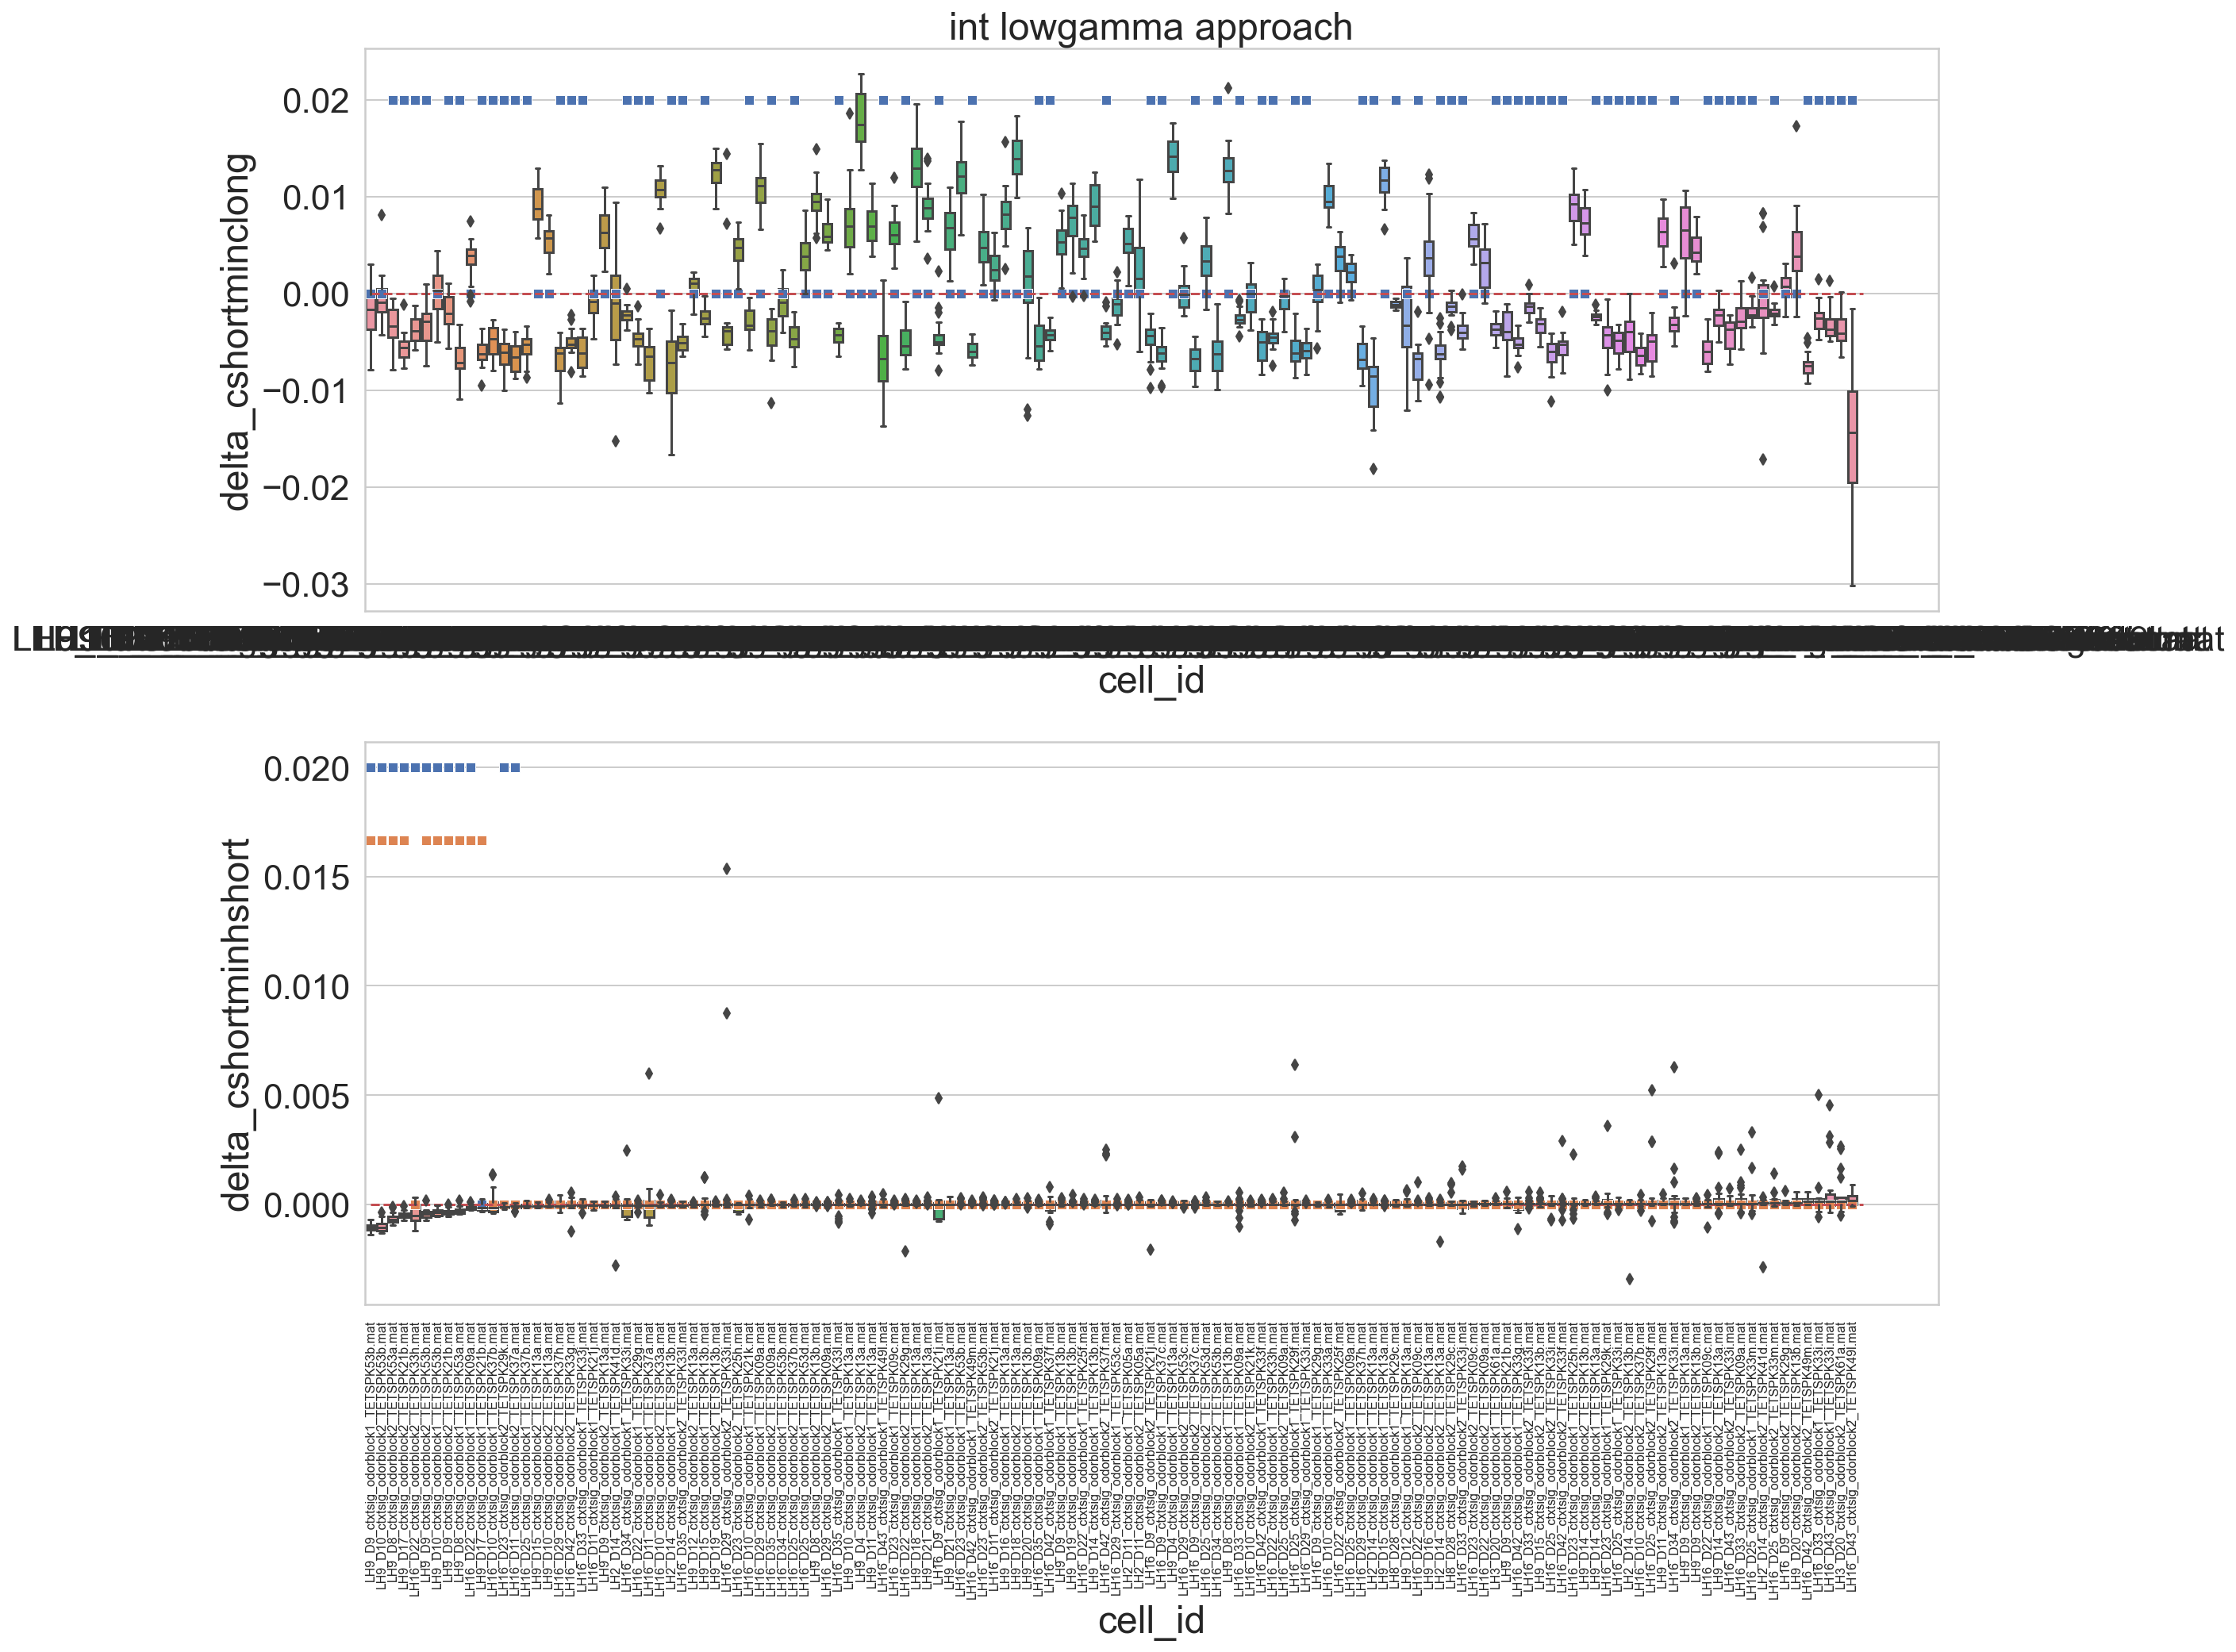

In [39]:
# sns.set_style('whitegrid')
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(lowgamma_results_df['cell_id'].to_list()))


sns.boxplot(data=lowgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=lowgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[0]).set_title('int lowgamma approach');

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=int_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=int_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[1])

sns.scatterplot(data=int_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

fig.tight_layout()
fig.savefig('RESULTS/figures/Fig3_pop/int_lowgamma_approach_orderBy_median_cshortminhshort_pvals_Ray_and_ttest.pdf')


In [15]:
sig_thresh = 0.001
scale_sig_marks = 50
theta_medians_df = int_theta_approach_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
theta_results_df = makefig_population_loglossdeltas(int_theta_approach_deltas_df,
                                                    theta_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


theta_cshortminclong_results_df = makefig_population_loglossdeltas(int_theta_approach_deltas_df,
                                                                   theta_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [36]:
print('cshort min hshort sig interneurons: ', list(set(theta_results_df.groupby('fold').sum()['significant'].to_list())))
print('cshort min clong sig interneurons: ', list(set(theta_cshortminclong_results_df.groupby('fold').sum()['significant'].to_list())))


cshort min hshort sig interneurons:  [111]
cshort min clong sig interneurons:  [73]


Check what fraction of the population had a better complete long model than complete short model

In [16]:
sig_thresh = 0.001
scale_sig_marks = 50

theta_cshortminclong_results_df_clongbetter = makefig_population_loglossdeltas_1tailedttest_geq0(int_theta_approach_deltas_df,
                                                                                                    theta_medians_df,
                                                                                                    'delta_cshortminclong',
                                                                                                    sig_thresh,
                                                                                                    scale_sig_marks)



In [18]:
print('cshort min clong sig interneurons: ', list(set(theta_cshortminclong_results_df_clongbetter.groupby('fold').sum()['significant'].to_list())))


cshort min clong sig interneurons:  [34]


In [34]:
import scipy.io as sio
datapath = 'python_approach_highestv_data/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
ray_df = []

rhythm = 'theta'
for file in tqdm(files):
    
    matfile = sio.loadmat(os.path.join(datapath,file))
    
    df = pd.DataFrame()

    df['spikes'] = matfile['spikes_long'].tolist()[0]
    df['theta_4_12_phases'] = matfile[rhythm+'_4to12_phase_long'].tolist()[0]
        
    tmp = rayleigh_pr(df,'theta_4_12')
    tmp['cell_id'] = file
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)  

int_theta_all_results_df = pd.merge(theta_results_df, raypop_df, on='cell_id')
int_theta_all_results_df = make_significance_column(int_theta_all_results_df,'pval_y',0.001,60,'ray_significant_scaled')

int_theta_cshortminclong_ray_df = pd.merge(theta_cshortminclong_results_df, raypop_df, on='cell_id')
int_theta_cshortminclong_ray_df = make_significance_column(int_theta_cshortminclong_ray_df,'pval_y',0.001,40,'ray_significant_scaled')


100%|█████████████████████████████████████████| 134/134 [00:23<00:00,  5.70it/s]


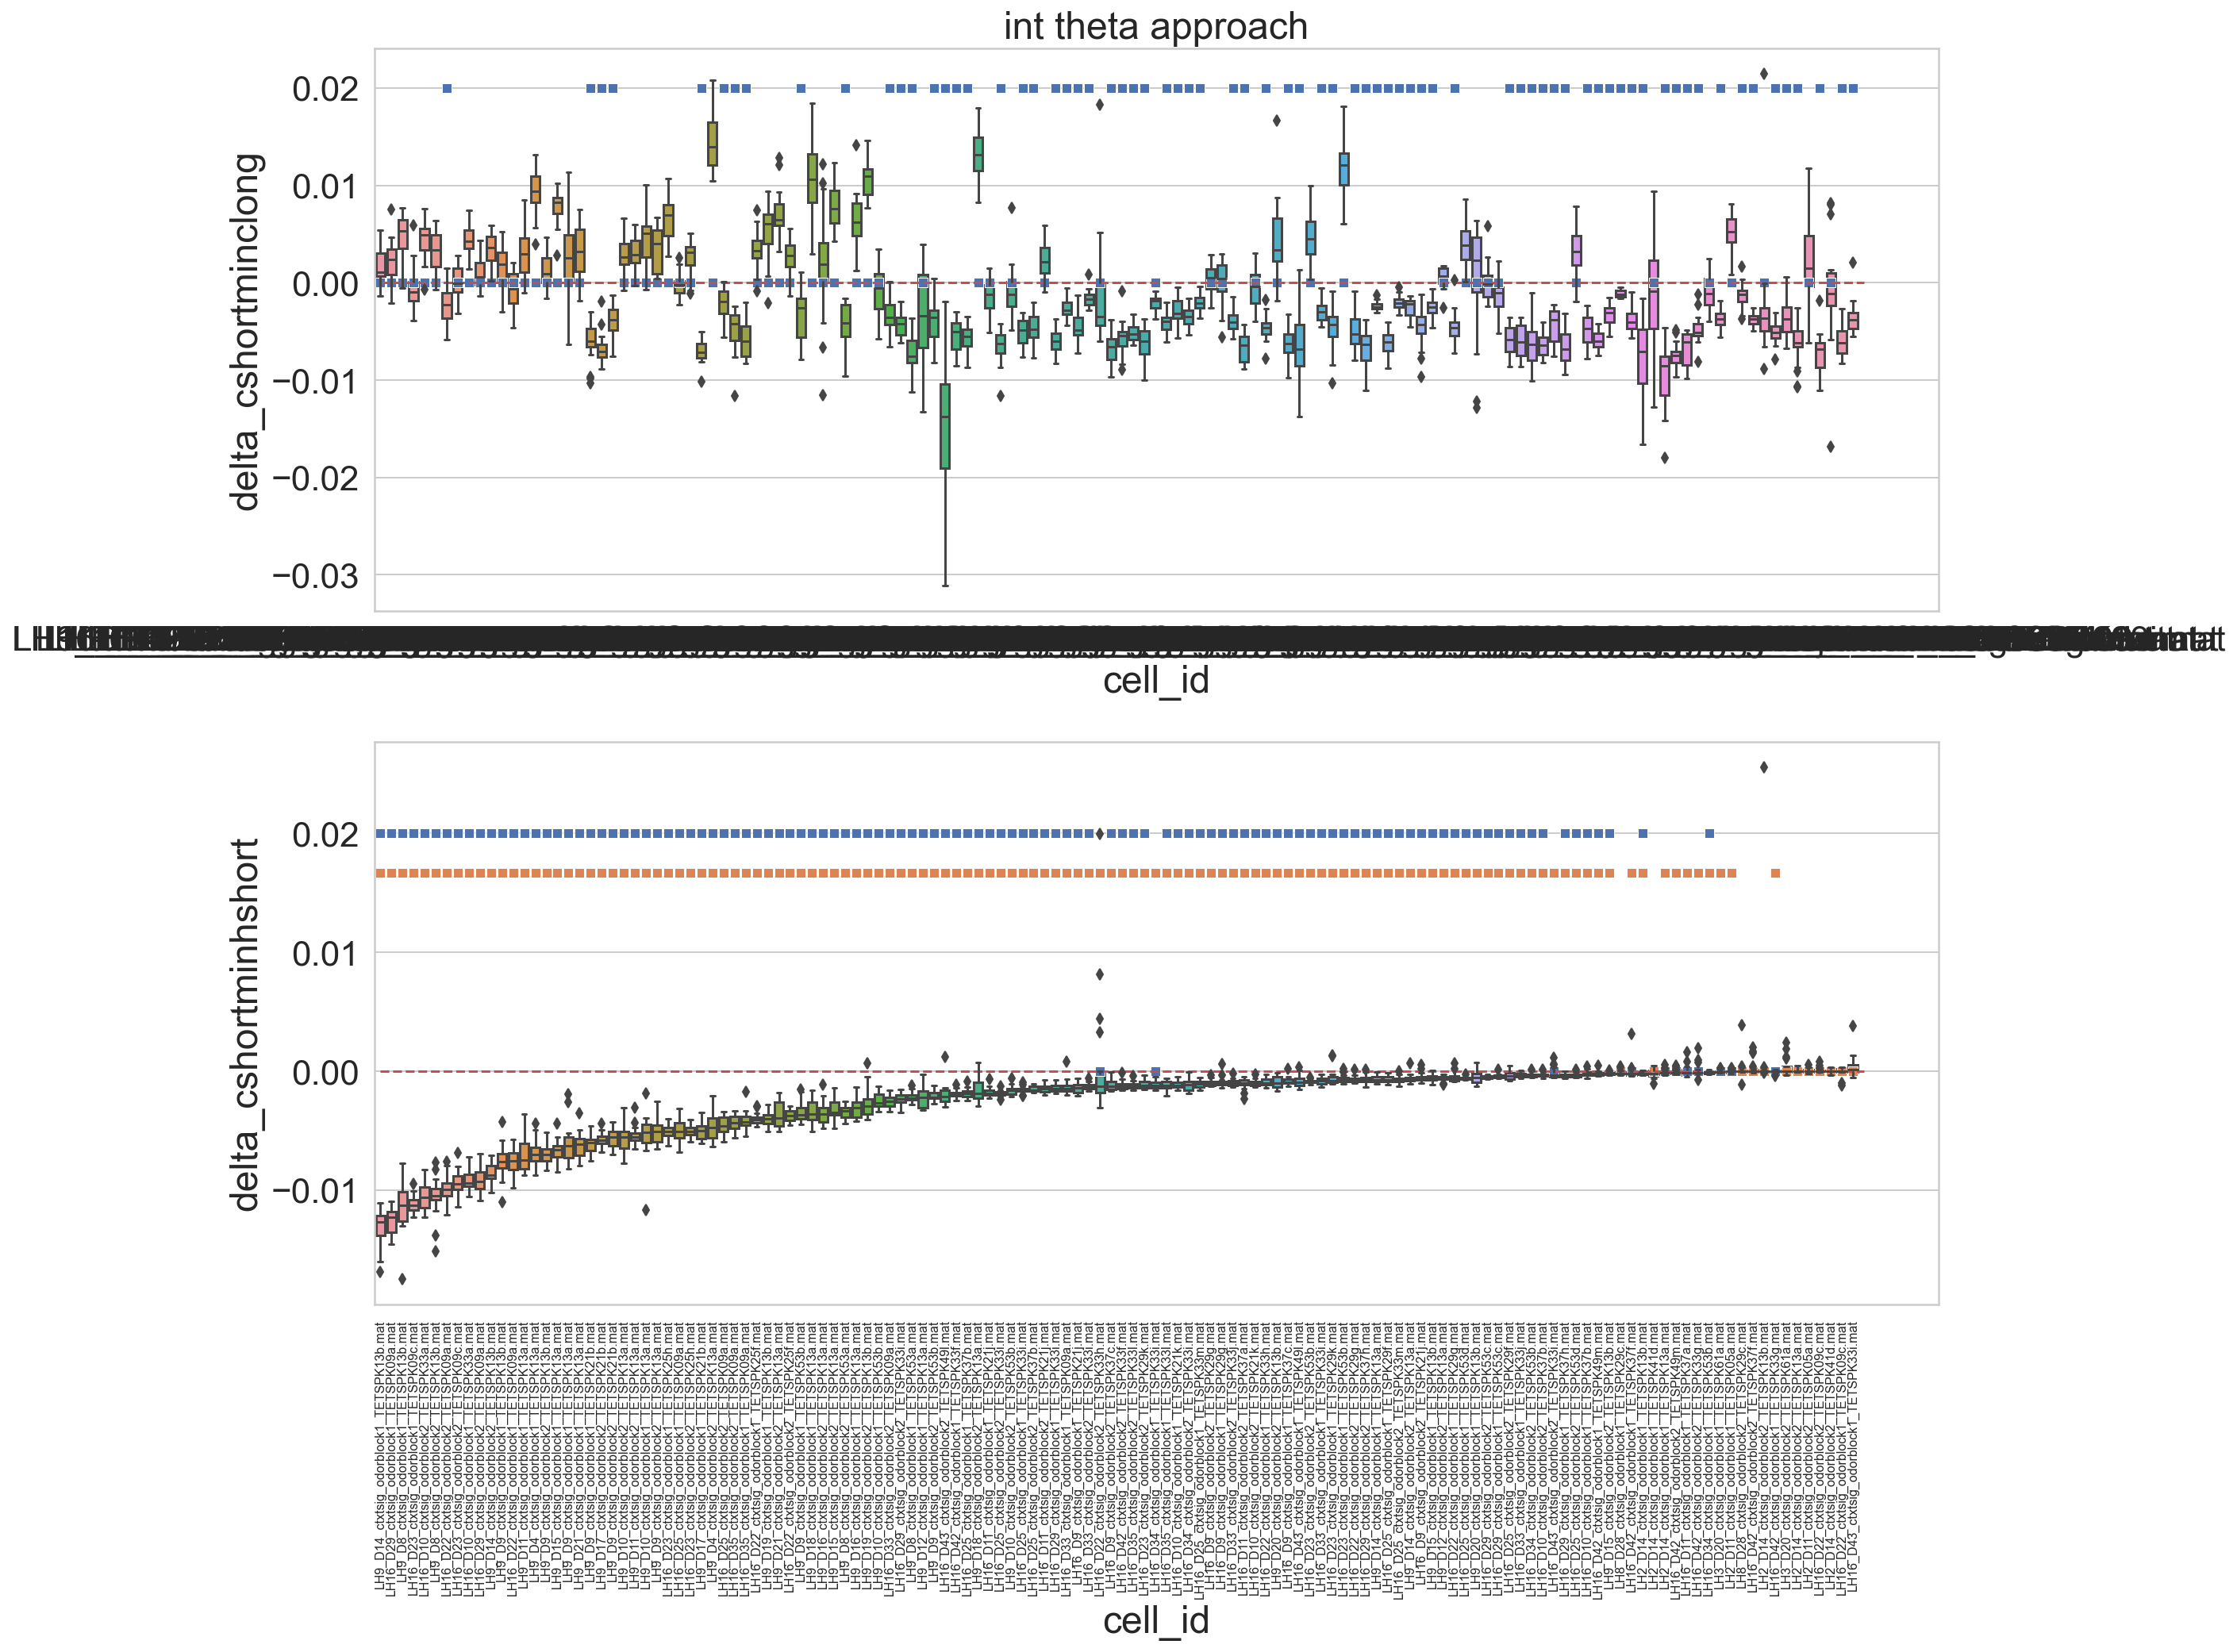

In [38]:
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(theta_results_df['cell_id'].to_list()))


sns.boxplot(data=theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[0]).set_title('int theta approach');

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=int_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=int_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[1])

sns.scatterplot(data=int_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

fig.tight_layout()
fig.savefig('RESULTS/figures/Fig3_pop/int_theta_approach_orderBy_median_cshortminhshort_pvals_Ray_and_ttest.pdf')





### compare the approach to the odor sampling results

In [5]:
int_lowgamma_odor_deltas_df = pd.read_csv('RESULTS/logloss_deltas_lowgamma_20folds.csv')
int_theta_odor_deltas_df = pd.read_csv('RESULTS/logloss_deltas_theta_20folds.csv')

int_lowgamma_approach_deltas_df
int_theta_approach_deltas_df

Unnamed: 0                                    cell_id  fold  \
0              0  LH16_D10_ctxtsig_odorblock1_TETSPK21k.mat     0   
1              1  LH16_D10_ctxtsig_odorblock1_TETSPK33a.mat     0   
2              2  LH16_D10_ctxtsig_odorblock1_TETSPK37b.mat     0   
3              3  LH16_D10_ctxtsig_odorblock2_TETSPK21k.mat     0   
4              4  LH16_D10_ctxtsig_odorblock2_TETSPK33a.mat     0   
...          ...                                        ...   ...   
2675        2675   LH9_D20_ctxtsig_odorblock2_TETSPK13b.mat    19   
2676        2676   LH9_D21_ctxtsig_odorblock1_TETSPK13a.mat    19   
2677        2677   LH9_D21_ctxtsig_odorblock2_TETSPK13a.mat    19   
2678        2678   LH16_D9_ctxtsig_odorblock2_TETSPK29g.mat    19   
2679        2679   LH16_D9_ctxtsig_odorblock2_TETSPK37c.mat    19   

      delta_cshortminhshort  delta_cshortminclong  
0                 -0.001379             -0.001950  
1                 -0.010571              0.001414  
2                 -0.000049             -0.002304  
3                 -0.001314             -0.002344  
4                 -0.011495              0.001634  
...                     ...                   ...  
2675              -0.000957              0.001334  
2676              -0.005605              0.007527  
2677              -0.002522              0.006263  
2678              -0.001172              0.000486  
2679              -0.001094             -0.005789  

[2680 rows x 5 columns]

In [6]:
median_loglossdeltas_approach = int_theta_approach_deltas_df.groupby('cell_id').median()['delta_cshortminhshort'].reset_index()
median_loglossdeltas_odor = int_theta_odor_deltas_df.groupby('cell_id').median()['delta_cshortminhshort'].reset_index()


In [7]:
cell_labels = list(set(median_loglossdeltas_approach['cell_id'].to_list()))
unique_ids = []
gather_dfs = []
for cell_id in cell_labels: 
    
    #find rat name
    ratname = cell_id.split('_')[0]
    
    #find session name 
    sessionname = cell_id.split('_')[1]
    
    #find block id
    blockname = cell_id.split('_')[3]
    
    #find unit ids
#     unitname = cell_id.split('_')[-1].split('.mat')[0]
    unitname = cell_id.split('TETSPK')[1].split('.mat')[0]
    
    unique = ratname + '_' + sessionname + '_' + blockname + '_' + unitname
    unique_ids.append(unique)
    
    index = median_loglossdeltas_approach.loc[median_loglossdeltas_approach['cell_id']==cell_id]
    index['core_cell_id'] = unique
    
    gather_dfs.append(index)
    
unique_ids = set(unique_ids)  
median_loglossdeltas_approach_core = pd.concat(gather_dfs)


/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_679/1103834466.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['core_cell_id'] = unique


In [8]:
cell_labels = list(set(median_loglossdeltas_odor['cell_id'].to_list()))
unique_ids = []
gather_dfs = []
for cell_id in cell_labels: 
    
    #find rat name
    ratname = cell_id.split('_')[0]
    
    #find session name 
    sessionname = cell_id.split('_')[4]
    if sessionname[1] == '0':
        sessionname1 = sessionname.split('0')[0]
        sessionname2 = sessionname.split('0')[1]
        sessionname = sessionname1 + sessionname2
    
    #find block id
    tmp_blockname = cell_id.split('TET')[0]
    blockname = tmp_blockname.split('_')[-1]
    #find unit ids
    unitname = cell_id.split('TETSPK')[1]
    
    unique = ratname + '_' + sessionname + '_' + blockname + '_' + unitname
    unique_ids.append(unique)
    
    index = median_loglossdeltas_odor.loc[median_loglossdeltas_odor['cell_id']==cell_id]
    index['core_cell_id'] = unique
    
    gather_dfs.append(index)
    
unique_ids = set(unique_ids)  
median_loglossdeltas_odor_core = pd.concat(gather_dfs)

/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_679/478653888.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['core_cell_id'] = unique


In [9]:
tmp = pd.merge(median_loglossdeltas_odor_core, median_loglossdeltas_approach_core, on='core_cell_id', how='outer')
tmp = tmp.rename(columns = {'delta_cshortminhshort_y': 'approach',
                      'delta_cshortminhshort_x': 'odor'
                     })



In [10]:
tmp = pd.melt(tmp, id_vars=['core_cell_id'], value_vars=['odor', 'approach'],
        var_name = 'beh_epoch', value_name = 'delta_cshortminhshort')

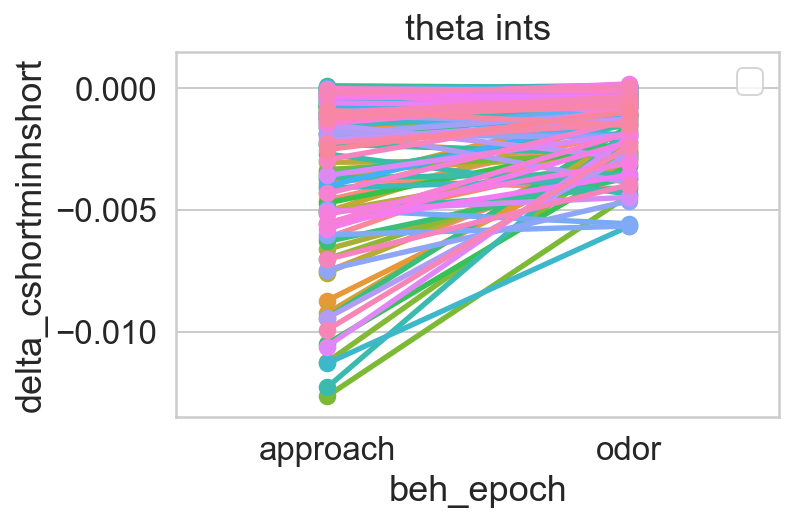

In [33]:
sns.set(style='whitegrid',font_scale = 1.5)
g = sns.pointplot(data = tmp,
               x = 'beh_epoch',
               y = 'delta_cshortminhshort',
               hue = 'core_cell_id',
                  alpha = 0.5,
                 order=['approach','odor']
              )

g.set_ylim(-0.0135,0.0015)
g.legend('')
g.set_title('theta ints')
plt.tight_layout()
plt.savefig('RESULTS/figures/BehEpoch_Comparison_theta_allints_loglossdelta_cshortminhshort.pdf')

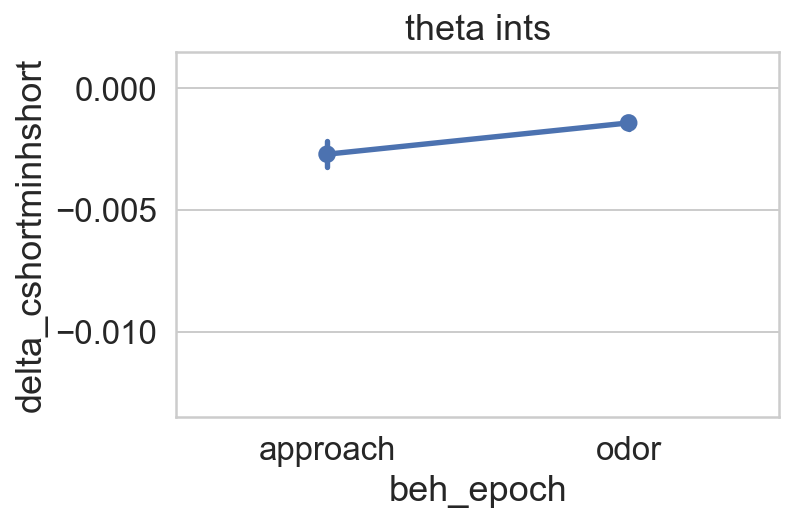

In [32]:
sns.set(style='whitegrid',font_scale = 1.5)
g = sns.pointplot(data = tmp,
               x = 'beh_epoch',
               y = 'delta_cshortminhshort',
                  alpha = 0.5,
                 order=['approach','odor']
              )


g.set_ylim(-0.0135,0.0015)
g.set_title('theta ints')
plt.tight_layout()
# plt.savefig('RESULTS/figures/BehEpoch_mean_Comparison_theta_allints_loglossdelta_cshortminhshort.pdf')

In [35]:
median_loglossdeltas_approach_lowgamma = int_lowgamma_approach_deltas_df.groupby('cell_id').median()['delta_cshortminhshort'].reset_index()
median_loglossdeltas_odor_lowgamma = int_lowgamma_odor_deltas_df.groupby('cell_id').median()['delta_cshortminhshort'].reset_index()


In [36]:
cell_labels = list(set(median_loglossdeltas_odor_lowgamma['cell_id'].to_list()))
unique_ids = []
gather_dfs = []
for cell_id in cell_labels: 
    
    #find rat name
    ratname = cell_id.split('_')[0]
    
    #find session name 
    sessionname = cell_id.split('_')[4]
    if sessionname[1] == '0':
        sessionname1 = sessionname.split('0')[0]
        sessionname2 = sessionname.split('0')[1]
        sessionname = sessionname1 + sessionname2
    
    #find block id
    tmp_blockname = cell_id.split('TET')[0]
    blockname = tmp_blockname.split('_')[-1]
    #find unit ids
    unitname = cell_id.split('TETSPK')[1]
    
    unique = ratname + '_' + sessionname + '_' + blockname + '_' + unitname
    unique_ids.append(unique)
    
    index = median_loglossdeltas_odor_lowgamma.loc[median_loglossdeltas_odor_lowgamma['cell_id']==cell_id]
    index['core_cell_id'] = unique
    
    gather_dfs.append(index)
    
unique_ids = set(unique_ids)  
median_loglossdeltas_odor_core_lowgamma = pd.concat(gather_dfs)


/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_679/2047223052.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['core_cell_id'] = unique


In [37]:
cell_labels = list(set(median_loglossdeltas_approach_lowgamma['cell_id'].to_list()))
unique_ids = []
gather_dfs = []
for cell_id in cell_labels: 
    
    #find rat name
    ratname = cell_id.split('_')[0]
    
    #find session name 
    sessionname = cell_id.split('_')[1]
    
    #find block id
    blockname = cell_id.split('_')[3]
    
    #find unit ids
#     unitname = cell_id.split('_')[-1].split('.mat')[0]
    unitname = cell_id.split('TETSPK')[1].split('.mat')[0]
    
    unique = ratname + '_' + sessionname + '_' + blockname + '_' + unitname
    unique_ids.append(unique)
    
    index = median_loglossdeltas_approach_lowgamma.loc[median_loglossdeltas_approach_lowgamma['cell_id']==cell_id]
    index['core_cell_id'] = unique
    
    gather_dfs.append(index)
    
unique_ids = set(unique_ids)  
median_loglossdeltas_approach_core_lowgamma = pd.concat(gather_dfs)


/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_679/1972024961.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['core_cell_id'] = unique


In [38]:
lowgamma_beh_deltas = pd.merge(median_loglossdeltas_odor_core_lowgamma, median_loglossdeltas_approach_core_lowgamma, on='core_cell_id', how='outer')
lowgamma_beh_deltas = lowgamma_beh_deltas.rename(columns = {'delta_cshortminhshort_y': 'approach',
                      'delta_cshortminhshort_x': 'odor'
                     })

lowgamma_beh_deltas = pd.melt(lowgamma_beh_deltas, id_vars=['core_cell_id'], value_vars=['odor', 'approach'],
        var_name = 'beh_epoch', value_name = 'delta_cshortminhshort')

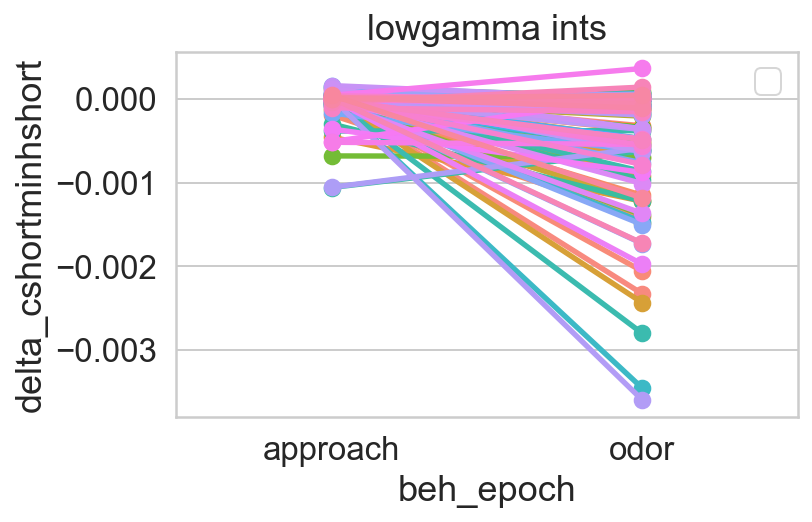

In [42]:
sns.set(style='whitegrid',font_scale = 1.5)
g = sns.pointplot(data = lowgamma_beh_deltas,
                  x = 'beh_epoch',
                  y = 'delta_cshortminhshort',
                  hue = 'core_cell_id',
                  alpha = 0.5,
                  order=["approach", "odor"]
                 )

# g.set_ylim(-0.0135,0.0015)
g.legend('')
g.set_title('lowgamma ints')
plt.tight_layout()
plt.savefig('RESULTS/figures/BehEpoch_Comparison_lowgamma_allints_loglossdelta_cshortminhshort.pdf')

In [2]:
datapath = 'RESULTS/'
lowgamma_df = pd.read_csv(os.path.join(datapath,'logloss_deltas_lowgamma_20folds.csv'))

In [3]:
lowgamma_df

Unnamed: 0                                              cell_id  fold  \
0              0  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     0   
1              1  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK29g     0   
2              2  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK37c     0   
3              3  LH16_07_09_14_D09_theta_correct_odorblock2TETSPK21j     0   
4              4  LH16_07_09_14_D09_theta_correct_odorblock2TETSPK29g     0   
...          ...                                                  ...   ...   
2675        2675   LH9_11_14_13_D19_theta_correct_odorblock2TETSPK13b    19   
2676        2676   LH9_11_19_13_D20_theta_correct_odorblock1TETSPK13b    19   
2677        2677   LH9_11_19_13_D20_theta_correct_odorblock2TETSPK13b    19   
2678        2678   LH9_11_26_13_D21_theta_correct_odorblock1TETSPK13a    19   
2679        2679   LH9_11_26_13_D21_theta_correct_odorblock2TETSPK13a    19   

      delta_cshortminhshort  delta_cshortminclong  avg_kl_cshort_v_hshort  
0                  0.000001             -0.005071                0.000003  
1                 -0.000063             -0.002737                0.000199  
2                  0.000124             -0.006402                0.000197  
3                  0.003239              0.003008                0.000040  
4                 -0.000060             -0.000353                0.000157  
...                     ...                   ...                     ...  
2675              -0.000575             -0.003256                0.000580  
2676               0.000099             -0.002787                0.000311  
2677              -0.000273             -0.005057                0.000909  
2678              -0.000696             -0.002505                0.000551  
2679              -0.000694             -0.002015                0.000975  

[2680 rows x 6 columns]

In [5]:
sig_thresh = 0.001
scale_sig_marks = 40
lowgamma_medians_df = lowgamma_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
lowgamma_results_df = makefig_population_loglossdeltas(lowgamma_df,
                                                    lowgamma_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


lowgamma_cshortminclong_results_df = makefig_population_loglossdeltas(lowgamma_df,
                                                                   lowgamma_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



In [6]:
lowgamma_results_df

Unnamed: 0                                              cell_id  fold  \
0              0  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     0   
1              1  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK29g     0   
2              2  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK37c     0   
3              3  LH16_07_09_14_D09_theta_correct_odorblock2TETSPK21j     0   
4              4  LH16_07_09_14_D09_theta_correct_odorblock2TETSPK29g     0   
...          ...                                                  ...   ...   
2675        2675   LH9_11_14_13_D19_theta_correct_odorblock2TETSPK13b    19   
2676        2676   LH9_11_19_13_D20_theta_correct_odorblock1TETSPK13b    19   
2677        2677   LH9_11_19_13_D20_theta_correct_odorblock2TETSPK13b    19   
2678        2678   LH9_11_26_13_D21_theta_correct_odorblock1TETSPK13a    19   
2679        2679   LH9_11_26_13_D21_theta_correct_odorblock2TETSPK13a    19   

      delta_cshortminhshort  delta_cshortminclong  avg_kl_cshort_v_hshort  \
0                  0.000001             -0.005071                0.000003   
1                 -0.000063             -0.002737                0.000199   
2                  0.000124             -0.006402                0.000197   
3                  0.003239              0.003008                0.000040   
4                 -0.000060             -0.000353                0.000157   
...                     ...                   ...                     ...   
2675              -0.000575             -0.003256                0.000580   
2676               0.000099             -0.002787                0.000311   
2677              -0.000273             -0.005057                0.000909   
2678              -0.000696             -0.002505                0.000551   
2679              -0.000694             -0.002015                0.000975   

      delta_cshortminhshort_median      tstat          pval  significant  \
0                         0.000003   1.456335  9.191864e-01            0   
1                        -0.000053  -1.401864  8.854075e-02            0   
2                        -0.000015   0.078806  5.309943e-01            0   
3                         0.000004   1.867554  9.613355e-01            0   
4                         0.000047   1.637024  9.409591e-01            0   
...                            ...        ...           ...          ...   
2675                     -0.000487  -6.678521  1.095429e-06            1   
2676                     -0.000085  -2.225927  1.916006e-02            0   
2677                     -0.000631  -8.580068  2.917779e-08            1   
2678                     -0.000600 -10.801727  7.492233e-10            1   
2679                     -0.000706  -7.830161  1.150815e-07            1   

      significant_scaled  
0                  0.000  
1                  0.000  
2                  0.000  
3                  0.000  
4                  0.000  
...                  ...  
2675               0.025  
2676               0.000  
2677               0.025  
2678               0.025  
2679               0.025  

[2680 rows x 11 columns]

In [19]:
print('cshort min hshort sig interneurons: ', list(set(lowgamma_results_df.groupby('fold').sum()['significant'].to_list())))



cshort min hshort sig interneurons:  [59]


In [29]:
59/134


0.44029850746268656

In [32]:
print('cshort min clong sig interneurons: ', list(set(lowgamma_cshortminclong_results_df.groupby('fold').sum()['significant'].to_list()))[0]/134)
print('cshort min clong sig interneurons: ', list(set(lowgamma_cshortminclong_results_df.groupby('fold').sum()['significant'].to_list())))



cshort min clong sig interneurons:  0.8955223880597015
cshort min clong sig interneurons:  [120]


In [21]:
theta_df = pd.read_csv(os.path.join(datapath,'logloss_deltas_theta_20folds.csv'))

sig_thresh = 0.001
scale_sig_marks = 40
theta_medians_df = theta_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
theta_results_df = makefig_population_loglossdeltas(theta_df,
                                                    theta_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


theta_cshortminclong_results_df = makefig_population_loglossdeltas(theta_df,
                                                                   theta_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



In [22]:
print('cshort min hshort sig interneurons: ', list(set(theta_results_df.groupby('fold').sum()['significant'].to_list())))


cshort min hshort sig interneurons:  [107]


In [25]:
print('cshort min clong sig interneurons: ', list(set(theta_cshortminclong_results_df.groupby('fold').sum()['significant'].to_list()))[0]/134)


cshort min clong sig interneurons:  0.9104477611940298


In [28]:
list(set(theta_cshortminclong_results_df.groupby('fold').sum()['significant'].to_list()))[0]

122

In [30]:
107/134

0.7985074626865671

In [38]:
import scipy.io as sio

In [39]:
cell_id = list(set(theta_results_df['cell_id'].to_list()))

In [42]:
files

['TETSPK09c_block2_full.mat']

In [45]:
matfile

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Oct 15 15:54:35 2020',
 '__version__': '1.0',
 '__globals__': [],
 'betaphase_long': array([[-2.65446377, -2.79049525, -2.92561517, ..., -0.07759522,
         -0.17431637, -0.2777752 ]]),
 'betaphase_stacked': array([[-2.65446377, -2.79049525, -2.92561517, ..., -2.89246276,
         -3.03646457,  3.10373447],
        [-1.68608824, -1.81443374, -1.94399865, ..., -1.91623118,
         -2.04078102, -2.16899959],
        [ 2.47245439,  2.380719  ,  2.28762508, ...,  0.47628371,
          0.32446354,  0.17005523],
        ...,
        [ 2.03302326,  1.92214802,  1.81374039, ...,  1.89127172,
          1.72911383,  1.56923188],
        [ 0.70843815,  0.57134528,  0.43342748, ...,  2.69655841,
          2.50311219,  2.30904603],
        [-2.07973399, -2.22310046, -2.36690652, ..., -0.07759522,
         -0.17431637, -0.2777752 ]]),
 'frate_per_trial': array([[22.        ],
        [32.66666667],
        [36.        ],
   

In [50]:
datapath = 'python_spkphase_multirhythm/'
folders = os.listdir(datapath)
folders = [f for f in folders if not f.startswith('.')]

folders = [f for f in folders if f in cell_id]
    
    
ray_df = []

rhythm = 'theta'
for folder in tqdm(folders):
    
    files = os.listdir(os.path.join(datapath, folder))
    file = [f for f in files if not f.startswith('.')]
    
    nrnpath = os.path.join(datapath,folder)
    filepath = os.path.join(nrnpath,file[0])
    
    matfile = sio.loadmat(filepath)
    
    df = pd.DataFrame()

    df['spikes'] = matfile['spikes_long'].tolist()[0]
    df['theta_4_12_phases'] = matfile[rhythm+'phase_long'].tolist()[0]
        
    tmp = rayleigh_pr(df,'theta_4_12')
    tmp['cell_id'] = folder
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)    

100%|█████████████████████████████████████████| 134/134 [00:22<00:00,  5.87it/s]


In [54]:
pyr_theta_all_results_df = pd.merge(theta_results_df, raypop_df, on='cell_id')
pyr_theta_all_results_df = make_significance_column(pyr_theta_all_results_df,'pval_y',0.001,30,'ray_significant')


In [55]:
pyr_theta_all_results_df

Unnamed: 0                                              cell_id  fold  \
0              0  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     0   
1            134  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     1   
2            268  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     2   
3            402  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     3   
4            536  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     4   
...          ...                                                  ...   ...   
2675        2143   LH9_11_26_13_D21_theta_correct_odorblock2TETSPK13a    15   
2676        2277   LH9_11_26_13_D21_theta_correct_odorblock2TETSPK13a    16   
2677        2411   LH9_11_26_13_D21_theta_correct_odorblock2TETSPK13a    17   
2678        2545   LH9_11_26_13_D21_theta_correct_odorblock2TETSPK13a    18   
2679        2679   LH9_11_26_13_D21_theta_correct_odorblock2TETSPK13a    19   

      delta_cshortminhshort  delta_cshortminclong  avg_kl_cshort_v_hshort  \
0                 -0.000708             -0.003136                0.002186   
1                 -0.002133             -0.004569                0.000642   
2                 -0.001607             -0.003526                0.001490   
3                 -0.001793             -0.005531                0.001322   
4                 -0.000950             -0.003690                0.001921   
...                     ...                   ...                     ...   
2675              -0.000504             -0.005633                0.001228   
2676              -0.000466             -0.001959                0.001139   
2677              -0.000535             -0.007430                0.000875   
2678              -0.000736             -0.002697                0.001061   
2679              -0.000944             -0.003372                0.000908   

      delta_cshortminhshort_median      tstat        pval_x  significant  \
0                        -0.001469 -14.810859  3.439537e-12            1   
1                        -0.001469 -14.810859  3.439537e-12            1   
2                        -0.001469 -14.810859  3.439537e-12            1   
3                        -0.001469 -14.810859  3.439537e-12            1   
4                        -0.001469 -14.810859  3.439537e-12            1   
...                            ...        ...           ...          ...   
2675                     -0.000765 -11.890169  1.512846e-10            1   
2676                     -0.000765 -11.890169  1.512846e-10            1   
2677                     -0.000765 -11.890169  1.512846e-10            1   
2678                     -0.000765 -11.890169  1.512846e-10            1   
2679                     -0.000765 -11.890169  1.512846e-10            1   

      significant_scaled      rhythm       mrl           R          z  \
0                  0.025  theta_4_12  0.285536  165.611118  47.288004   
1                  0.025  theta_4_12  0.285536  165.611118  47.288004   
2                  0.025  theta_4_12  0.285536  165.611118  47.288004   
3                  0.025  theta_4_12  0.285536  165.611118  47.288004   
4                  0.025  theta_4_12  0.285536  165.611118  47.288004   
...                  ...         ...       ...         ...        ...   
2675               0.025  theta_4_12  0.180882  321.788405  58.205609   
2676               0.025  theta_4_12  0.180882  321.788405  58.205609   
2677               0.025  theta_4_12  0.180882  321.788405  58.205609   
2678               0.025  theta_4_12  0.180882  321.788405  58.205609   
2679               0.025  theta_4_12  0.180882  321.788405  58.205609   

      circmean        pval_y  ray_significant  ray_significant_scaled  
0    -1.556944  1.110052e-21                1                0.033333  
1    -1.556944  1.110052e-21                1                0.033333  
2    -1.556944  1.110052e-21                1                0.033333  
3    -1.556944  1.110052e-21                1         

In [86]:
subfold = pyr_theta_all_results_df[pyr_theta_all_results_df['fold']==1]


ttest_sig = np.where(subfold['significant'].to_list())
ray_sig = np.where(subfold['ray_significant'].to_list())

In [92]:
set(ray_sig[0]) ^ set(ttest_sig[0])

{10, 29, 41, 49, 53, 55, 61, 69, 70, 80, 121}

In [93]:
len(set(ray_sig[0]) ^ set(ttest_sig[0]))

11

In [94]:
11/134

0.08208955223880597

# pyramidal cells: compute the log loss deltas across the population
To run the below, you must have already run the phase models on a population of cells.

In [3]:
rhythm = 'theta'
longhist = '250ms'
deltas = []
for fold in tqdm(range(20)):

    foldpath = 'RESULTS/PhaseHistModels_AllCells_pyr_byOdorPos/pyrlogoddsCompleteSinglePredMdls452/' + rhythm + longhist + '/folds/' + str(fold) +'/single_neuron/'

    folders = os.listdir(foldpath)
    len(folders)
    
    for folder in folders:
        
        nrnpath = os.path.join(foldpath,folder)
        
        probs_test = pd.read_csv(os.path.join(nrnpath,'probs_models_test.csv'))
        
        test_data = pd.read_csv(os.path.join(nrnpath,'test_data.csv'))
        
        y = test_data['spikes']
        
        cshort_loss, _, _ = logloss(probs_test['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        clong_loss, _, _ = logloss(probs_test['p_clong'],y)
        
        tmp_delta_cshminhsh = cshort_loss - hshort_loss
        tmp_delta_cshmincln = cshort_loss - clong_loss
      
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        
        all_kls = kl(probs_test['p_cshort'],probs_test['p_hshort'])
        avg_kl = np.mean(all_kls)
        
        deltas.append({'cell_id': folder,
                       'fold': fold,
                       'delta_cshortminhshort': tmp_delta_cshminhsh,
                       'delta_cshortminclong': tmp_delta_cshmincln,
                       'avg_kl_cshort_v_hshort': avg_kl
                      })
        
        
deltas_df = pd.DataFrame(deltas)
        

 75%|████████████████████████████████▎          | 15/20 [02:49<00:55, 11.09s/it]/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:13: RuntimeWarning: divide by zero encountered in log2
  kls.append(p1*np.log2(p1/p2)+(1-p1)*np.log2((1-p1)/(1-p2)))
/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:13: RuntimeWarning: invalid value encountered in double_scalars
  kls.append(p1*np.log2(p1/p2)+(1-p1)*np.log2((1-p1)/(1-p2)))
100%|███████████████████████████████████████████| 20/20 [03:44<00:00, 11.23s/it]


In [4]:
deltas_df.to_csv('pyr_byOdorPos_logloss_deltas_20folds.csv')

## Start Here
Once the code above has saved the dataframe with population log loss deltas. 

In [2]:
theta_deltas_df = pd.read_csv(os.path.join('RESULTS/pyr_byOdorPos_logloss_deltas_20folds.csv'))

In [3]:
theta_deltas_df

Unnamed: 0                                                cell_id  fold  \
0             0   LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     0   
1             1   LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     0   
2             2   LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     0   
3             3   LH02_D17_correct_odorblock2_odor7_pos1_TETSPK73d.mat     0   
4             4   LH02_D19_correct_odorblock2_odor4_pos3_TETSPK73a.mat     0   
..          ...                                                    ...   ...   
845         845   LH16_D33_correct_odorblock2_odor7_pos2_TETSPK25e.mat    19   
846         846  LH16_D34_correct_odorblock2_odor11_pos2_TETSPK25d.mat    19   
847         847   LH16_D34_correct_odorblock2_odor7_pos2_TETSPK25d.mat    19   
848         848  LH16_D35_correct_odorblock1_odor11_pos2_TETSPK25c.mat    19   
849         849   LH16_D35_correct_odorblock1_odor7_pos2_TETSPK25c.mat    19   

     delta_cshortminhshort  delta_cshortminclong  avg_kl_cshort_v_hshort  
0                 0.001295             -0.026363                0.000397  
1                -0.002884             -0.029657                0.001212  
2                 0.000478             -0.050866                0.000508  
3                 0.003825             -0.069663                0.005559  
4                -0.000263             -0.051116                0.001258  
..                     ...                   ...                     ...  
845               0.006858             -0.045622                0.002100  
846               0.000006             -0.064442                0.000003  
847               0.002283             -0.046388                0.002358  
848               0.001455             -0.029356                0.002575  
849               0.000226             -0.019551                0.000174  

[850 rows x 6 columns]

In [4]:
import scipy.stats as stats

def makefig_population_loglossdeltas(deltas_df,medians_df,df_delta_column_name,sig_thresh,scale_sig_marks):
    """df: pandas df, e.g. theta_deltas_df,
    medians_df: pandas df, computation example: 
        medians_df = deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
    df_delta_column_name: string, e.g. 'delta_cshortminshort'"""
    
    #first add the median log loss delta df -- this is how you will eventually
    #order the boxplot 
    wmed_df = deltas_df.join(medians_df.set_index('cell_id'), on='cell_id',rsuffix='_median')
    
    #compute the one-tailed t-statistic to ask: is the distribution of log loss 
    #deltas significantly smaller than zero? 
    cell_list = list(set(wmed_df['cell_id'].to_list()))
    delta_results = []

    for cell in cell_list: 

        sub = wmed_df[wmed_df['cell_id']==cell]

        data = sub[df_delta_column_name].values
        t = stats.ttest_1samp(a=data,popmean=0,alternative='less')

        tstat = t[0]
        pval = t[1]

        delta_results.append({'cell_id': cell,
                              'tstat': tstat,
                              'pval': pval
                             })

    results_df = pd.DataFrame(delta_results)

    results_df = wmed_df.join(results_df.set_index('cell_id'), on='cell_id',rsuffix='_ttest_results')

    #find and mark the significant cells according to the threshold value
    significant = []

    for i in results_df['pval'].values:

        if i < sig_thresh:
            significant.append(1)

        else: 
            significant.append(0)
            
    results_df['significant'] = significant
    #this is just so that the plus signs marking a sig result can print to the same scale as the boxplot figs
    results_df['significant_scaled'] = results_df['significant'].div(scale_sig_marks)
    
    return results_df


def make_significance_column(df,pval_colname,sig_thresh,scale_sig_marks,significance_colname):
    
    #find and mark the significant cells according to the threshold value
    significant = []

    for i in df[pval_colname].values:

        if i < sig_thresh:
            significant.append(1)

        else: 
            significant.append(0)
            
    df[significance_colname] = significant
    #this is just so that the plus signs marking a sig result can print to the same scale as the boxplot figs
    sigscale_colname = significance_colname + '_scaled'
    df[sigscale_colname] = df[significance_colname].div(scale_sig_marks)
    
    return df

In [5]:
sig_thresh = 0.001
scale_sig_marks = 40
theta_medians_df = theta_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
theta_results_df = makefig_population_loglossdeltas(theta_deltas_df,
                                                    theta_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


theta_cshortminclong_results_df = makefig_population_loglossdeltas(theta_deltas_df,
                                                                   theta_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



In [6]:
theta_cshortminclong_results_df


Unnamed: 0                                                cell_id  fold  \
0             0   LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     0   
1             1   LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     0   
2             2   LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     0   
3             3   LH02_D17_correct_odorblock2_odor7_pos1_TETSPK73d.mat     0   
4             4   LH02_D19_correct_odorblock2_odor4_pos3_TETSPK73a.mat     0   
..          ...                                                    ...   ...   
845         845   LH16_D33_correct_odorblock2_odor7_pos2_TETSPK25e.mat    19   
846         846  LH16_D34_correct_odorblock2_odor11_pos2_TETSPK25d.mat    19   
847         847   LH16_D34_correct_odorblock2_odor7_pos2_TETSPK25d.mat    19   
848         848  LH16_D35_correct_odorblock1_odor11_pos2_TETSPK25c.mat    19   
849         849   LH16_D35_correct_odorblock1_odor7_pos2_TETSPK25c.mat    19   

     delta_cshortminhshort  delta_cshortminclong  avg_kl_cshort_v_hshort  \
0                 0.001295             -0.026363                0.000397   
1                -0.002884             -0.029657                0.001212   
2                 0.000478             -0.050866                0.000508   
3                 0.003825             -0.069663                0.005559   
4                -0.000263             -0.051116                0.001258   
..                     ...                   ...                     ...   
845               0.006858             -0.045622                0.002100   
846               0.000006             -0.064442                0.000003   
847               0.002283             -0.046388                0.002358   
848               0.001455             -0.029356                0.002575   
849               0.000226             -0.019551                0.000174   

     delta_cshortminhshort_median      tstat          pval  significant  \
0                        0.001219 -10.572346  1.065731e-09            1   
1                       -0.001393  -9.774761  3.793399e-09            1   
2                        0.000280  -3.891315  4.910491e-04            1   
3                       -0.001127 -20.136146  1.407566e-14            1   
4                        0.000371  -8.746280  5.390864e-06            1   
..                            ...        ...           ...          ...   
845                      0.000129  -9.660665  4.575549e-09            1   
846                      0.000142 -11.237591  3.893134e-10            1   
847                      0.001121  -5.855580  6.108198e-06            1   
848                      0.000806 -12.461360  6.832286e-11            1   
849                      0.000262  -9.904038  3.073020e-09            1   

     significant_scaled  
0                 0.025  
1                 0.025  
2                 0.025  
3                 0.025  
4                 0.025  
..                  ...  
845               0.025  
846               0.025  
847               0.025  
848               0.025  
849               0.025  

[850 rows x 11 columns]

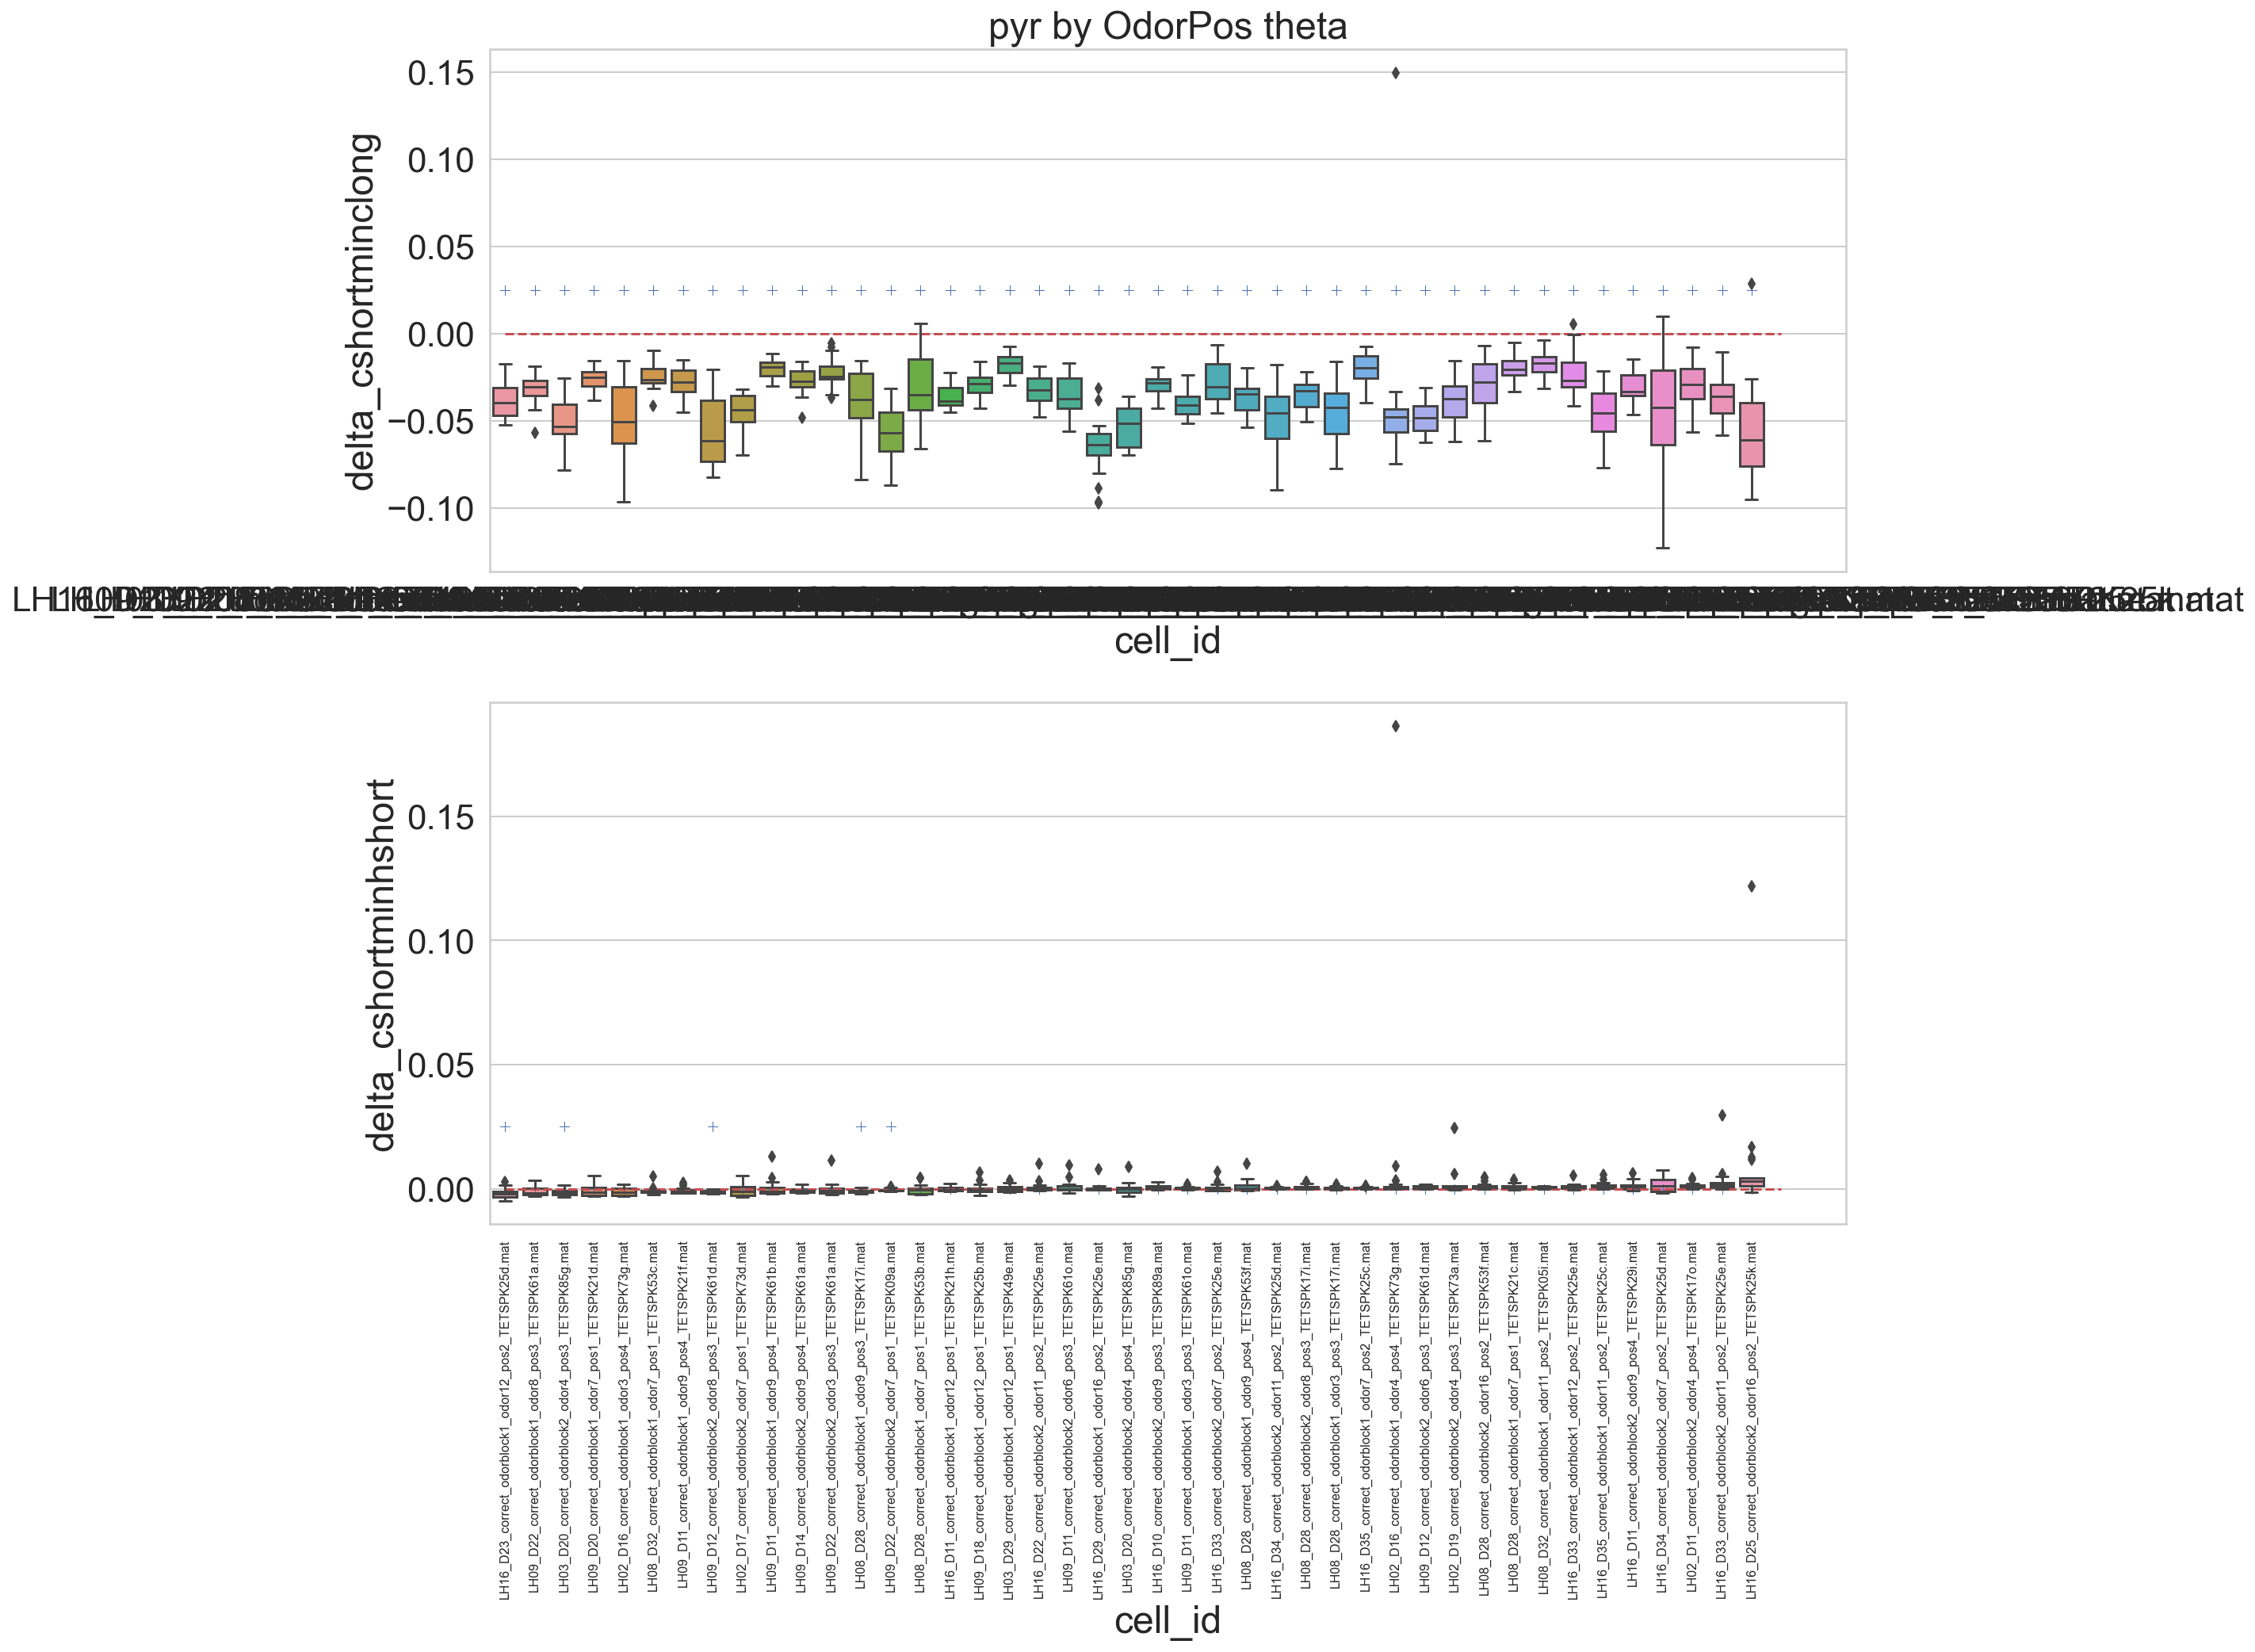

In [8]:
# sns.set_style('whitegrid')
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(theta_deltas_df['cell_id'].to_list()))


sns.boxplot(data=theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[0]).set_title('pyr by OdorPos theta');

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=theta_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=theta_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

fig.tight_layout()

# fig.savefig('pyr_byOdorPos_theta_loglossdeltas_orderBy_median_cshortminhshort.pdf')


In [8]:
subfold = theta_results_df[theta_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort') 

subfold = theta_cshortminclong_results_df[theta_cshortminclong_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong') 

0.11627906976744186 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort
1.0 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong


In [10]:
cell_id = list(set(theta_results_df['cell_id'].to_list()))

In [30]:
import scipy.io as sio

In [42]:
datapath = 'python_spkphase_pyrcells_multirhythm_byodorpos/'
folders = os.listdir(datapath)
folders = [f for f in folders if not f.startswith('.')]

files = [f for f in folders if f in cell_id]
    
    
ray_df = []

rhythm = 'theta'
for file in tqdm(files):
    
    filepath = os.path.join(datapath,file)
    matfile = sio.loadmat(filepath)
    
    df = pd.DataFrame()

    df['spikes'] = matfile['spikes_long'].tolist()[0]
    df['theta_4_12_phases'] = matfile[rhythm+'phase_4to12Hz_long'].tolist()[0]
        
    tmp = rayleigh_pr(df,'theta_4_12')
    tmp['cell_id'] = file
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)    

100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.62it/s]


In [49]:
pyr_theta_all_results_df = pd.merge(theta_results_df, raypop_df, on='cell_id')
pyr_theta_all_results_df = make_significance_column(pyr_theta_all_results_df,'pval_y',0.001,30,'ray_significant_scaled')


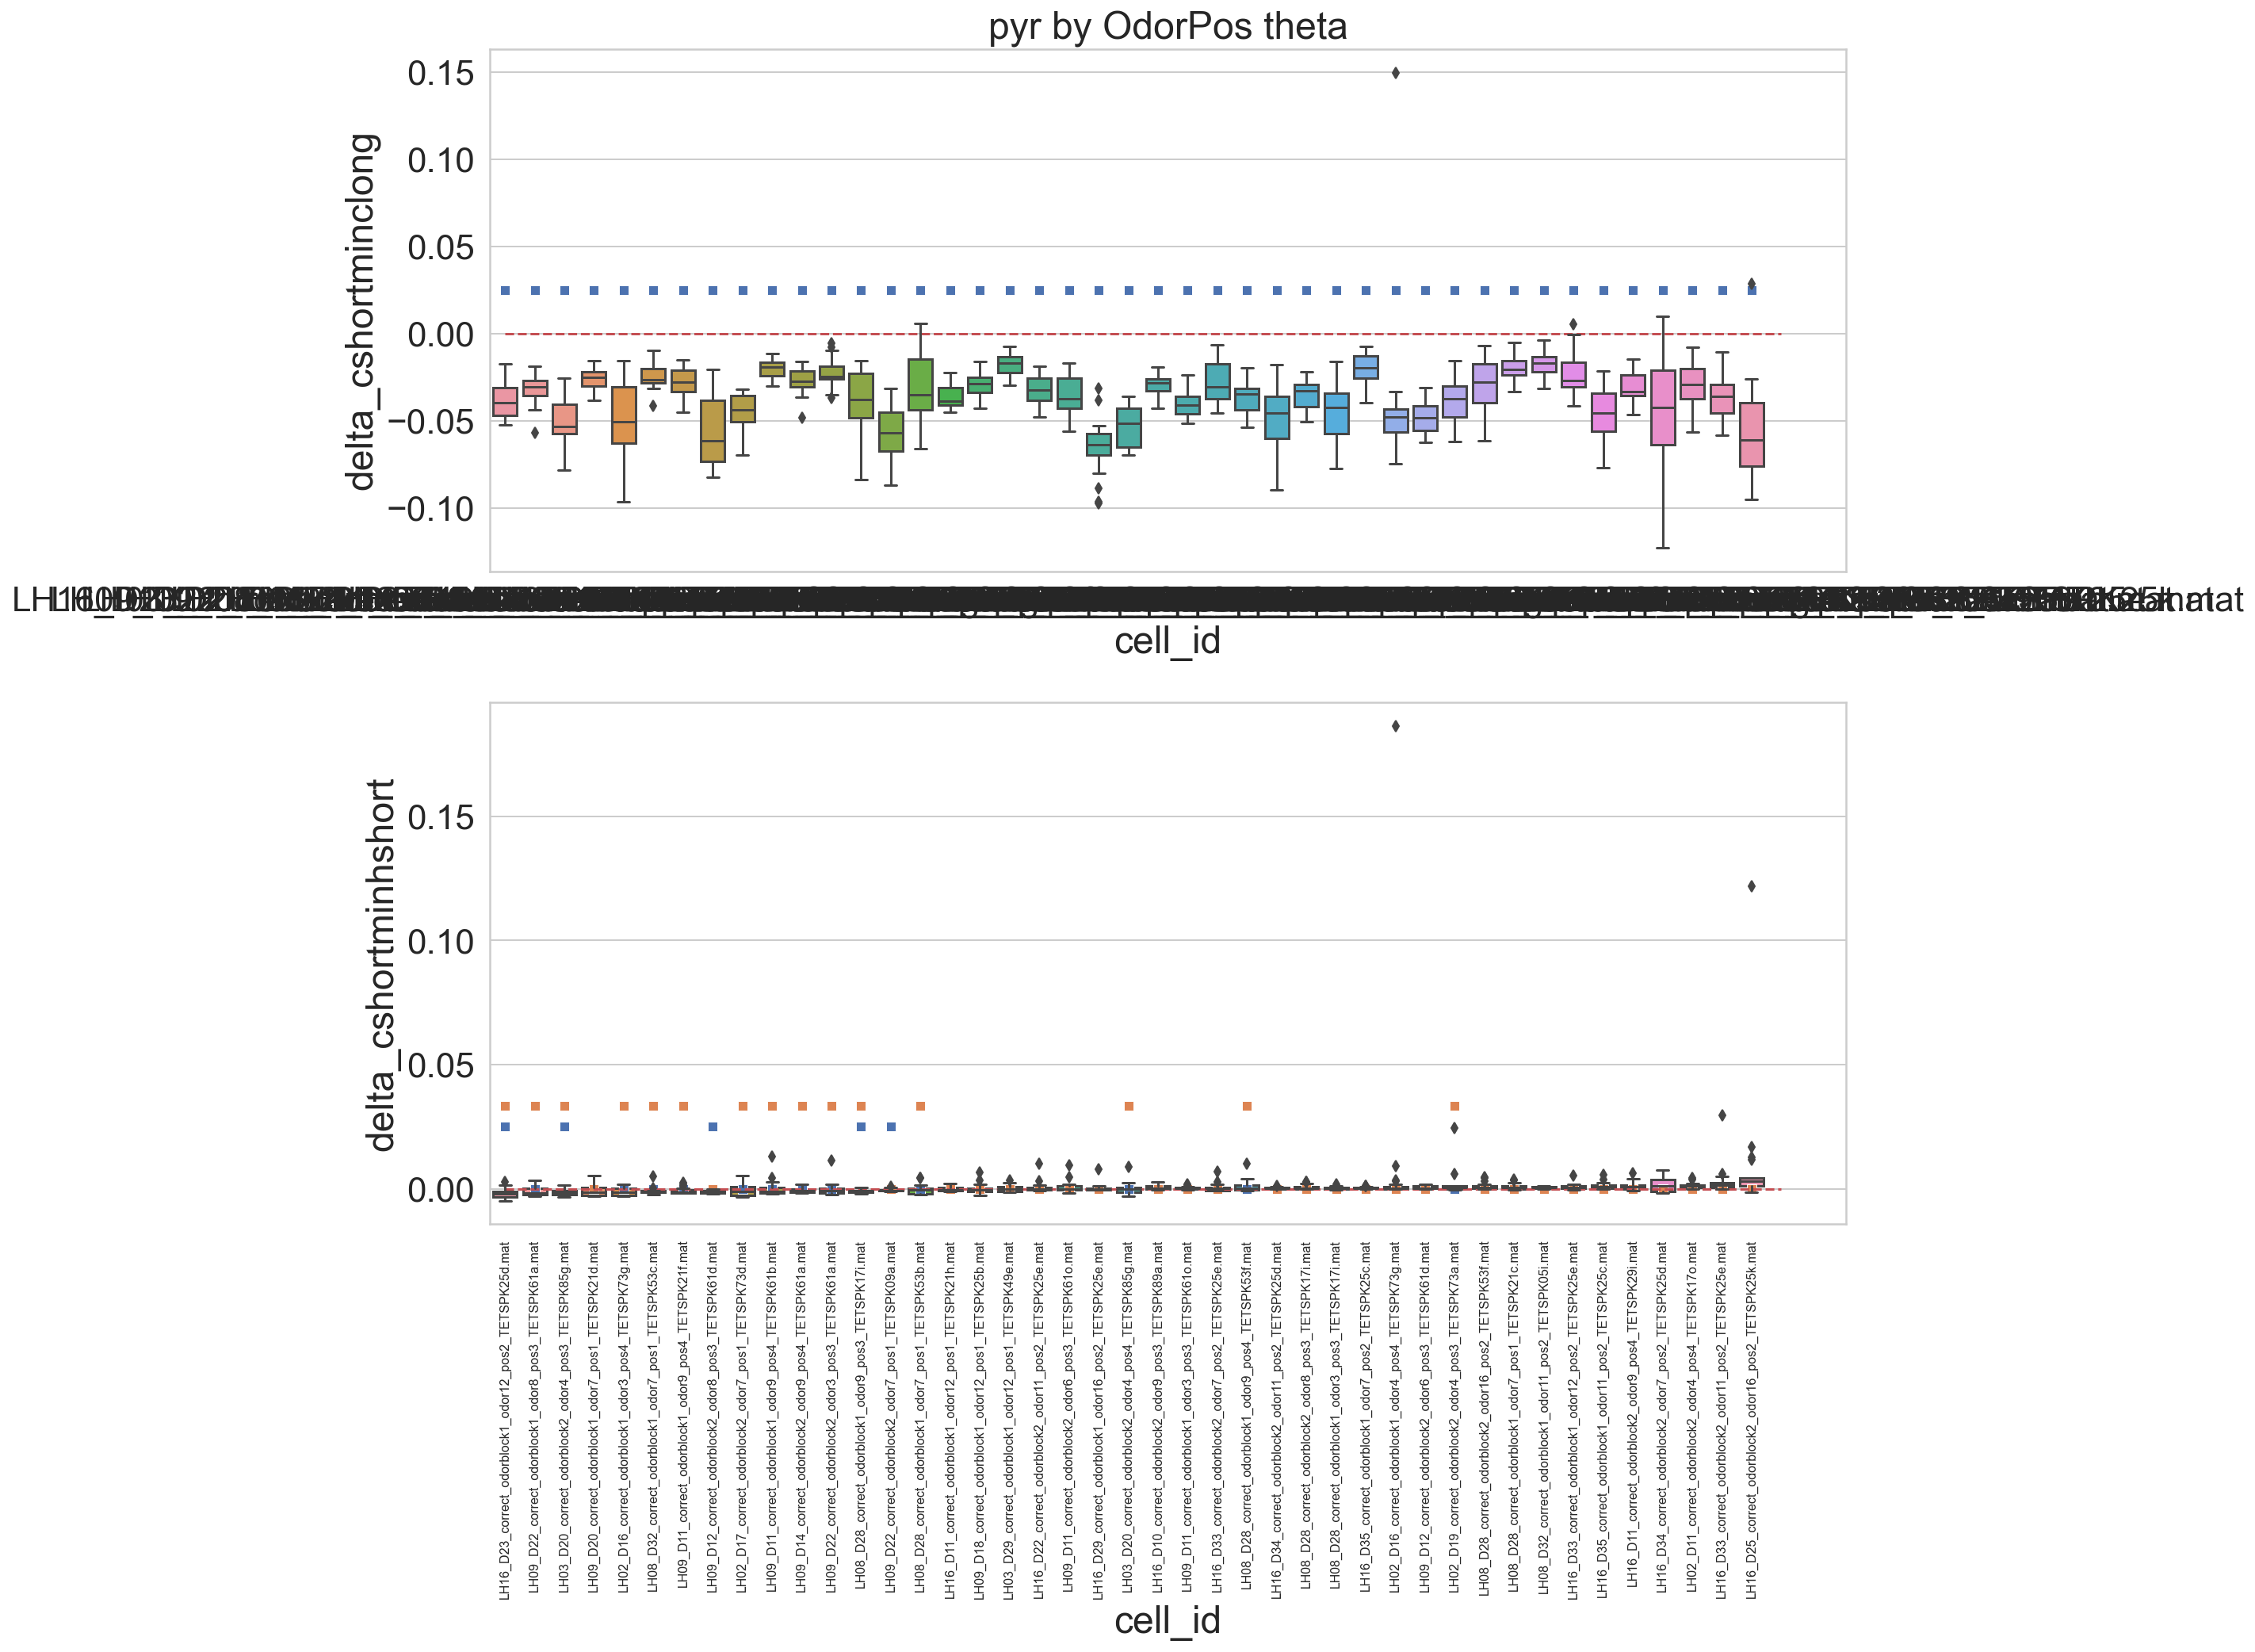

In [53]:
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(theta_cshortminclong_results_df['cell_id'].to_list()))


sns.boxplot(data=theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[0]).set_title('pyr by OdorPos theta');

# sns.scatterplot(data=int_lowgamma_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
#                 x='cell_id',
#                 y='ray_significant_scaled_scaled',
#                 marker="s",
#                 ax=ax[0])

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=pyr_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=pyr_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[1])

sns.scatterplot(data=pyr_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')


fig.tight_layout()
fig.savefig('pyr_byOdorPos_theta_loglossdeltas_orderBy_median_cshortminhshort_pvals_Ray_and_ttest.pdf')


## popfig for lowgamma pyrs

In [54]:
lowgamma_deltas_df = pd.read_csv(os.path.join('RESULTS/pyr_byOdorPos_lowgamma_logloss_deltas_20folds.csv'))

In [56]:
sig_thresh = 0.001
scale_sig_marks = 40
lowgamma_medians_df = lowgamma_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
lowgamma_results_df = makefig_population_loglossdeltas(lowgamma_deltas_df,
                                                    lowgamma_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


lowgamma_cshortminclong_results_df = makefig_population_loglossdeltas(lowgamma_deltas_df,
                                                                   lowgamma_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



In [57]:
subfold = lowgamma_results_df[lowgamma_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort') 

subfold = lowgamma_cshortminclong_results_df[lowgamma_cshortminclong_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong') 

0.046511627906976744 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort
0.9767441860465116 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong


In [59]:
datapath = 'python_spkphase_pyrcells_multirhythm_byodorpos/'
folders = os.listdir(datapath)
folders = [f for f in folders if not f.startswith('.')]

files = [f for f in folders if f in cell_id]
    
    
ray_df = []

rhythm = 'lowgamma'
for file in tqdm(files):
    
    filepath = os.path.join(datapath,file)
    matfile = sio.loadmat(filepath)
    
    df = pd.DataFrame()

    df['spikes'] = matfile['spikes_long'].tolist()[0]
    df['lowgamma_35_55_phases'] = matfile[rhythm+'phase_35to55Hz_long'].tolist()[0]
        
    tmp = rayleigh_pr(df,'lowgamma_35_55')
    tmp['cell_id'] = file
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)    

100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.22it/s]


In [60]:
pyr_lowgamma_all_results_df = pd.merge(lowgamma_results_df, raypop_df, on='cell_id')
pyr_lowgamma_all_results_df = make_significance_column(pyr_lowgamma_all_results_df,'pval_y',0.001,30,'ray_significant_scaled')


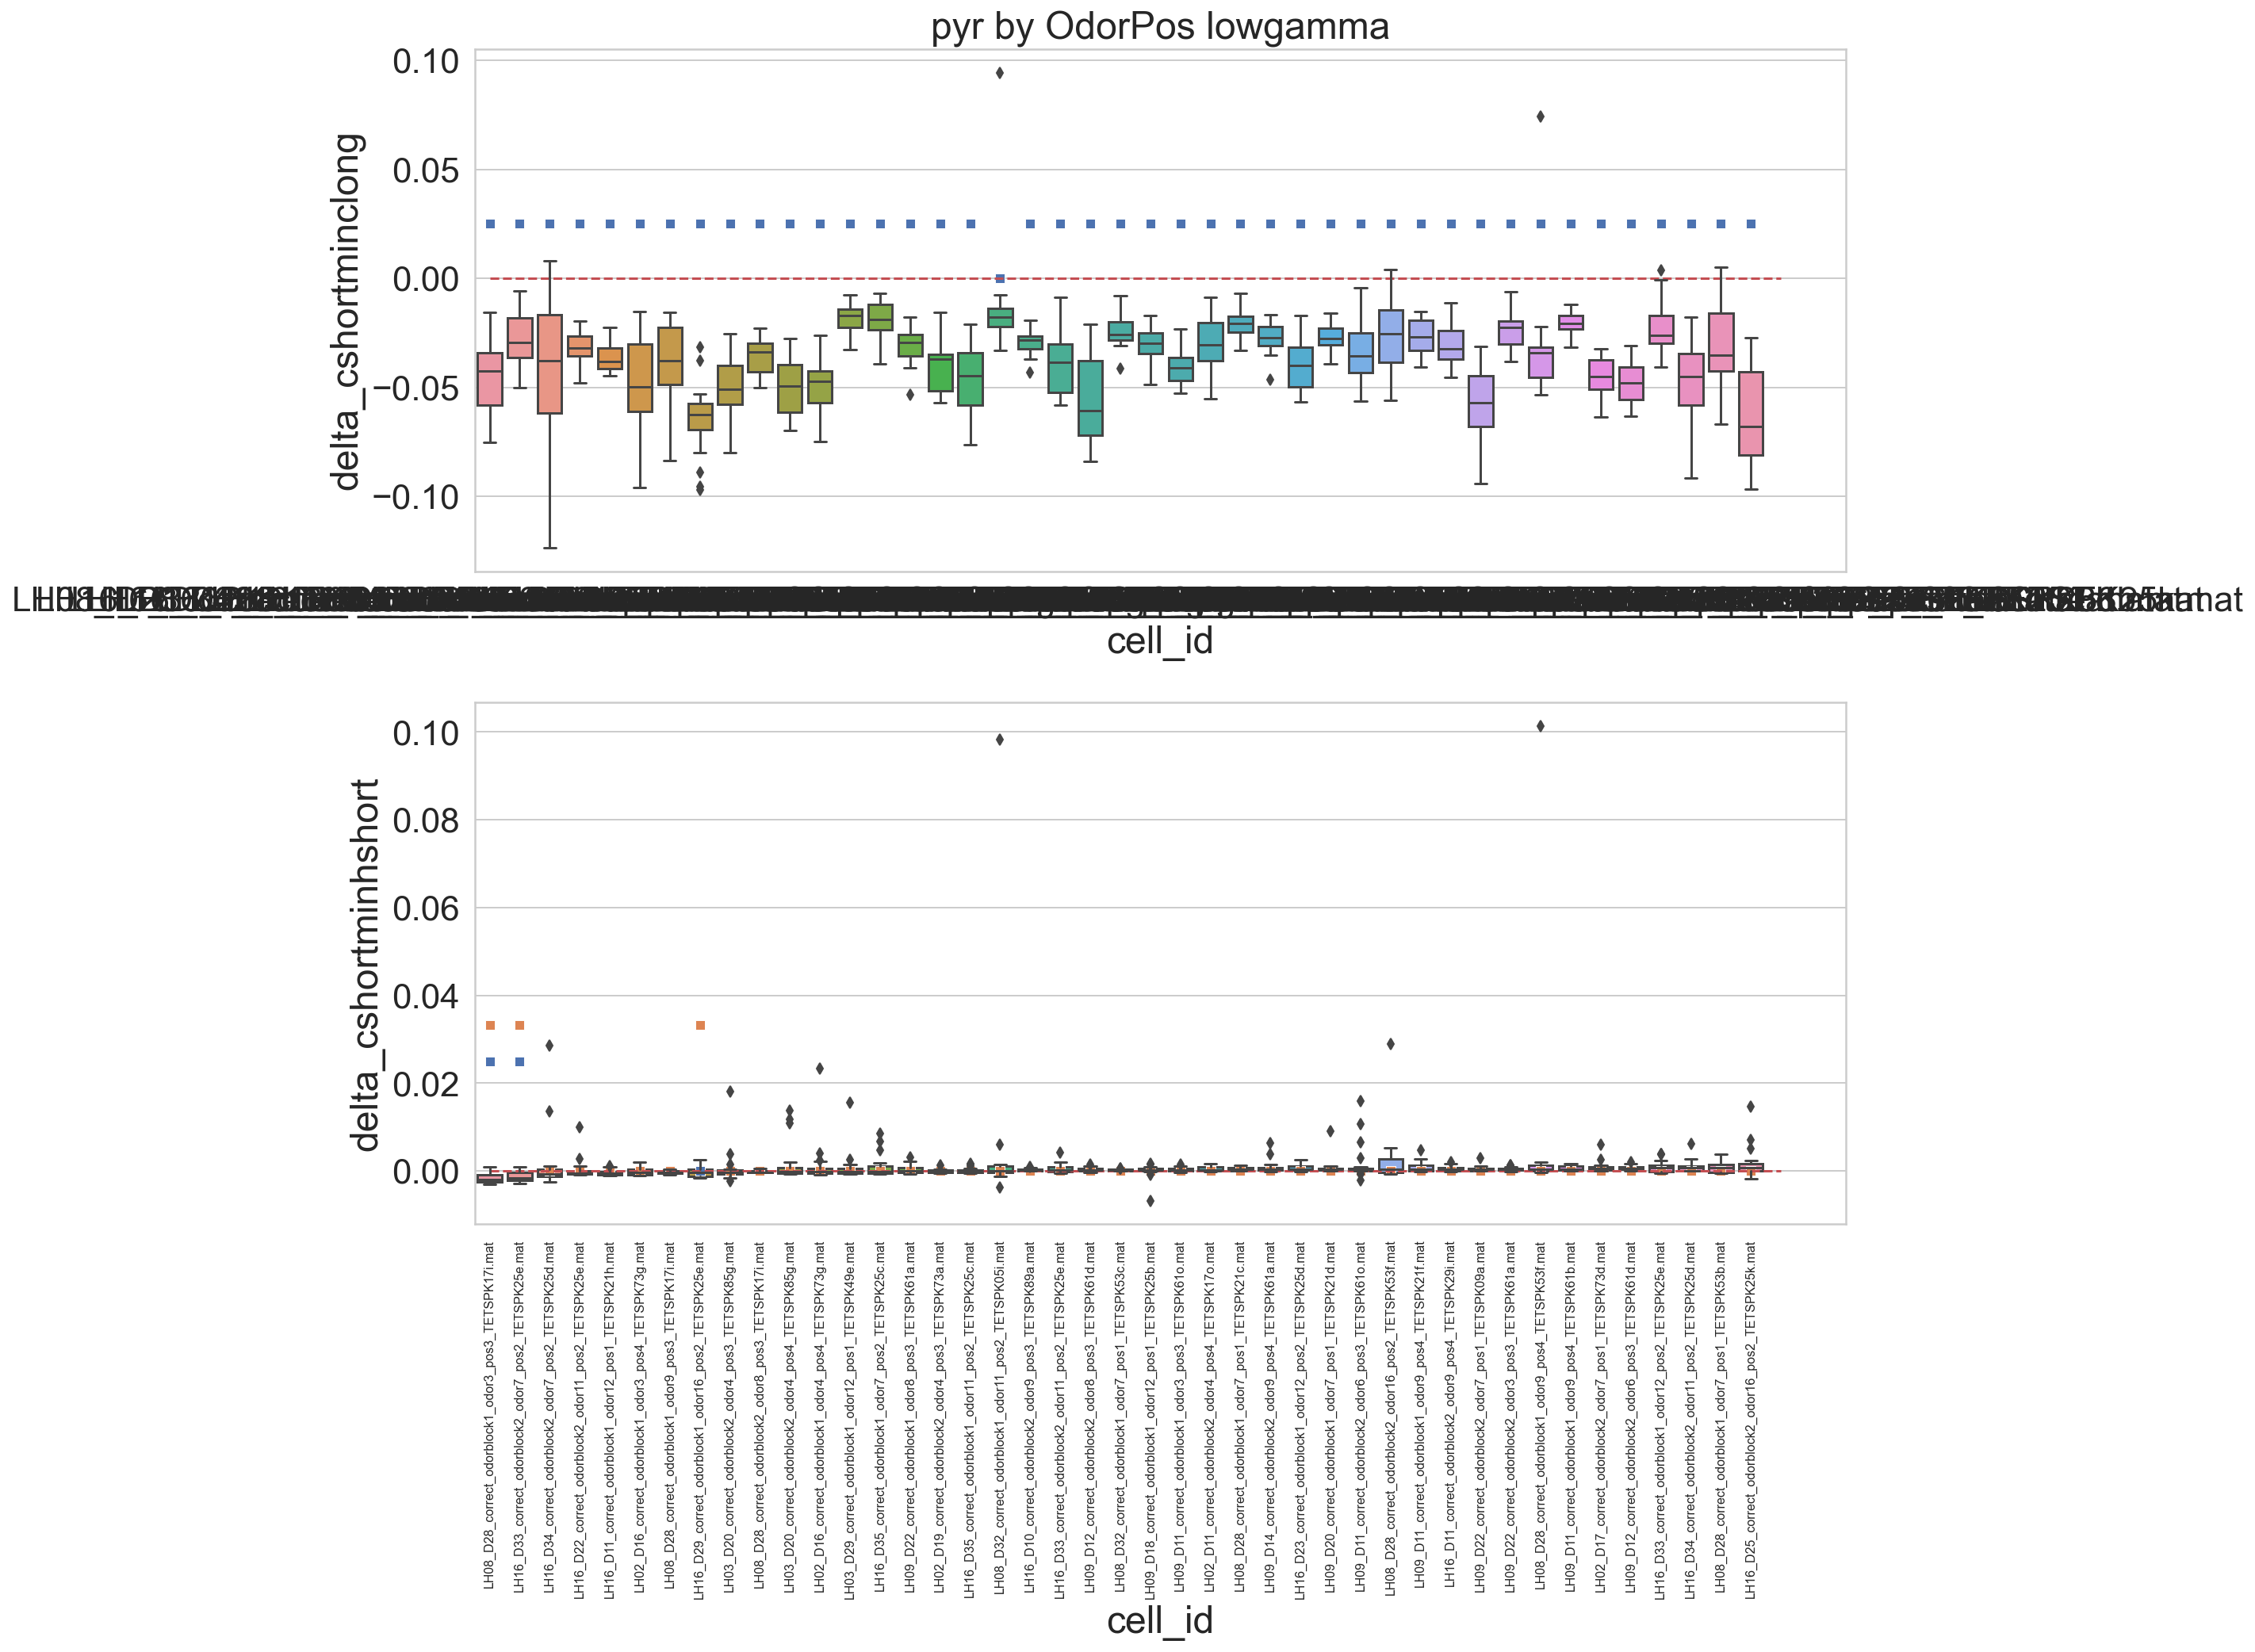

In [62]:
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(lowgamma_cshortminclong_results_df['cell_id'].to_list()))


sns.boxplot(data=lowgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=lowgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[0]).set_title('pyr by OdorPos lowgamma');

# sns.scatterplot(data=int_lowgamma_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
#                 x='cell_id',
#                 y='ray_significant_scaled_scaled',
#                 marker="s",
#                 ax=ax[0])

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=pyr_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=pyr_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[1])

sns.scatterplot(data=pyr_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')


fig.tight_layout()
fig.savefig('pyr_byOdorPos_lowgamma_loglossdeltas_orderBy_median_cshortminhshort_pvals_Ray_and_ttest.pdf')


In [9]:
rhythm = 'lowgamma'
longhist = '250ms'
deltas = []
for fold in tqdm(range(20)):

    foldpath = 'RESULTS/PhaseHistModels_AllCells_pyr_byOdorPos/pyrlogoddsCompleteSinglePredMdls1212/' + rhythm + longhist + '/folds/' + str(fold) +'/single_neuron/'

    folders = os.listdir(foldpath)
    len(folders)
    
    for folder in folders:
        
        nrnpath = os.path.join(foldpath,folder)
        
        probs_test = pd.read_csv(os.path.join(nrnpath,'probs_models_test.csv'))
        
        test_data = pd.read_csv(os.path.join(nrnpath,'test_data.csv'))
        
        y = test_data['spikes']
        
        cshort_loss, _, _ = logloss(probs_test['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        clong_loss, _, _ = logloss(probs_test['p_clong'],y)
        
        tmp_delta_cshminhsh = cshort_loss - hshort_loss
        tmp_delta_cshmincln = cshort_loss - clong_loss
      
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        
        all_kls = kl(probs_test['p_cshort'],probs_test['p_hshort'])
        avg_kl = np.mean(all_kls)
        
        deltas.append({'cell_id': folder,
                       'fold': fold,
                       'delta_cshortminhshort': tmp_delta_cshminhsh,
                       'delta_cshortminclong': tmp_delta_cshmincln,
                       'avg_kl_cshort_v_hshort': avg_kl
                      })
        
        
deltas_df = pd.DataFrame(deltas)
        

  0%|                                                    | 0/20 [00:10<?, ?it/s]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [54]:
deltas_df.to_csv(os.path.join('RESULTS/pyr_byOdorPos_lowgamma_logloss_deltas_20folds.csv'))

In [9]:
lowgamma_deltas_df = pd.read_csv(os.path.join('RESULTS/pyr_byOdorPos_lowgamma_logloss_deltas_20folds.csv'))

In [10]:
sig_thresh = 0.001
scale_sig_marks = 100
lowgamma_medians_df = lowgamma_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
lowgamma_results_df = makefig_population_loglossdeltas(lowgamma_deltas_df,
                                                    lowgamma_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


lowgamma_cshortminclong_results_df = makefig_population_loglossdeltas(lowgamma_deltas_df,
                                                                   lowgamma_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



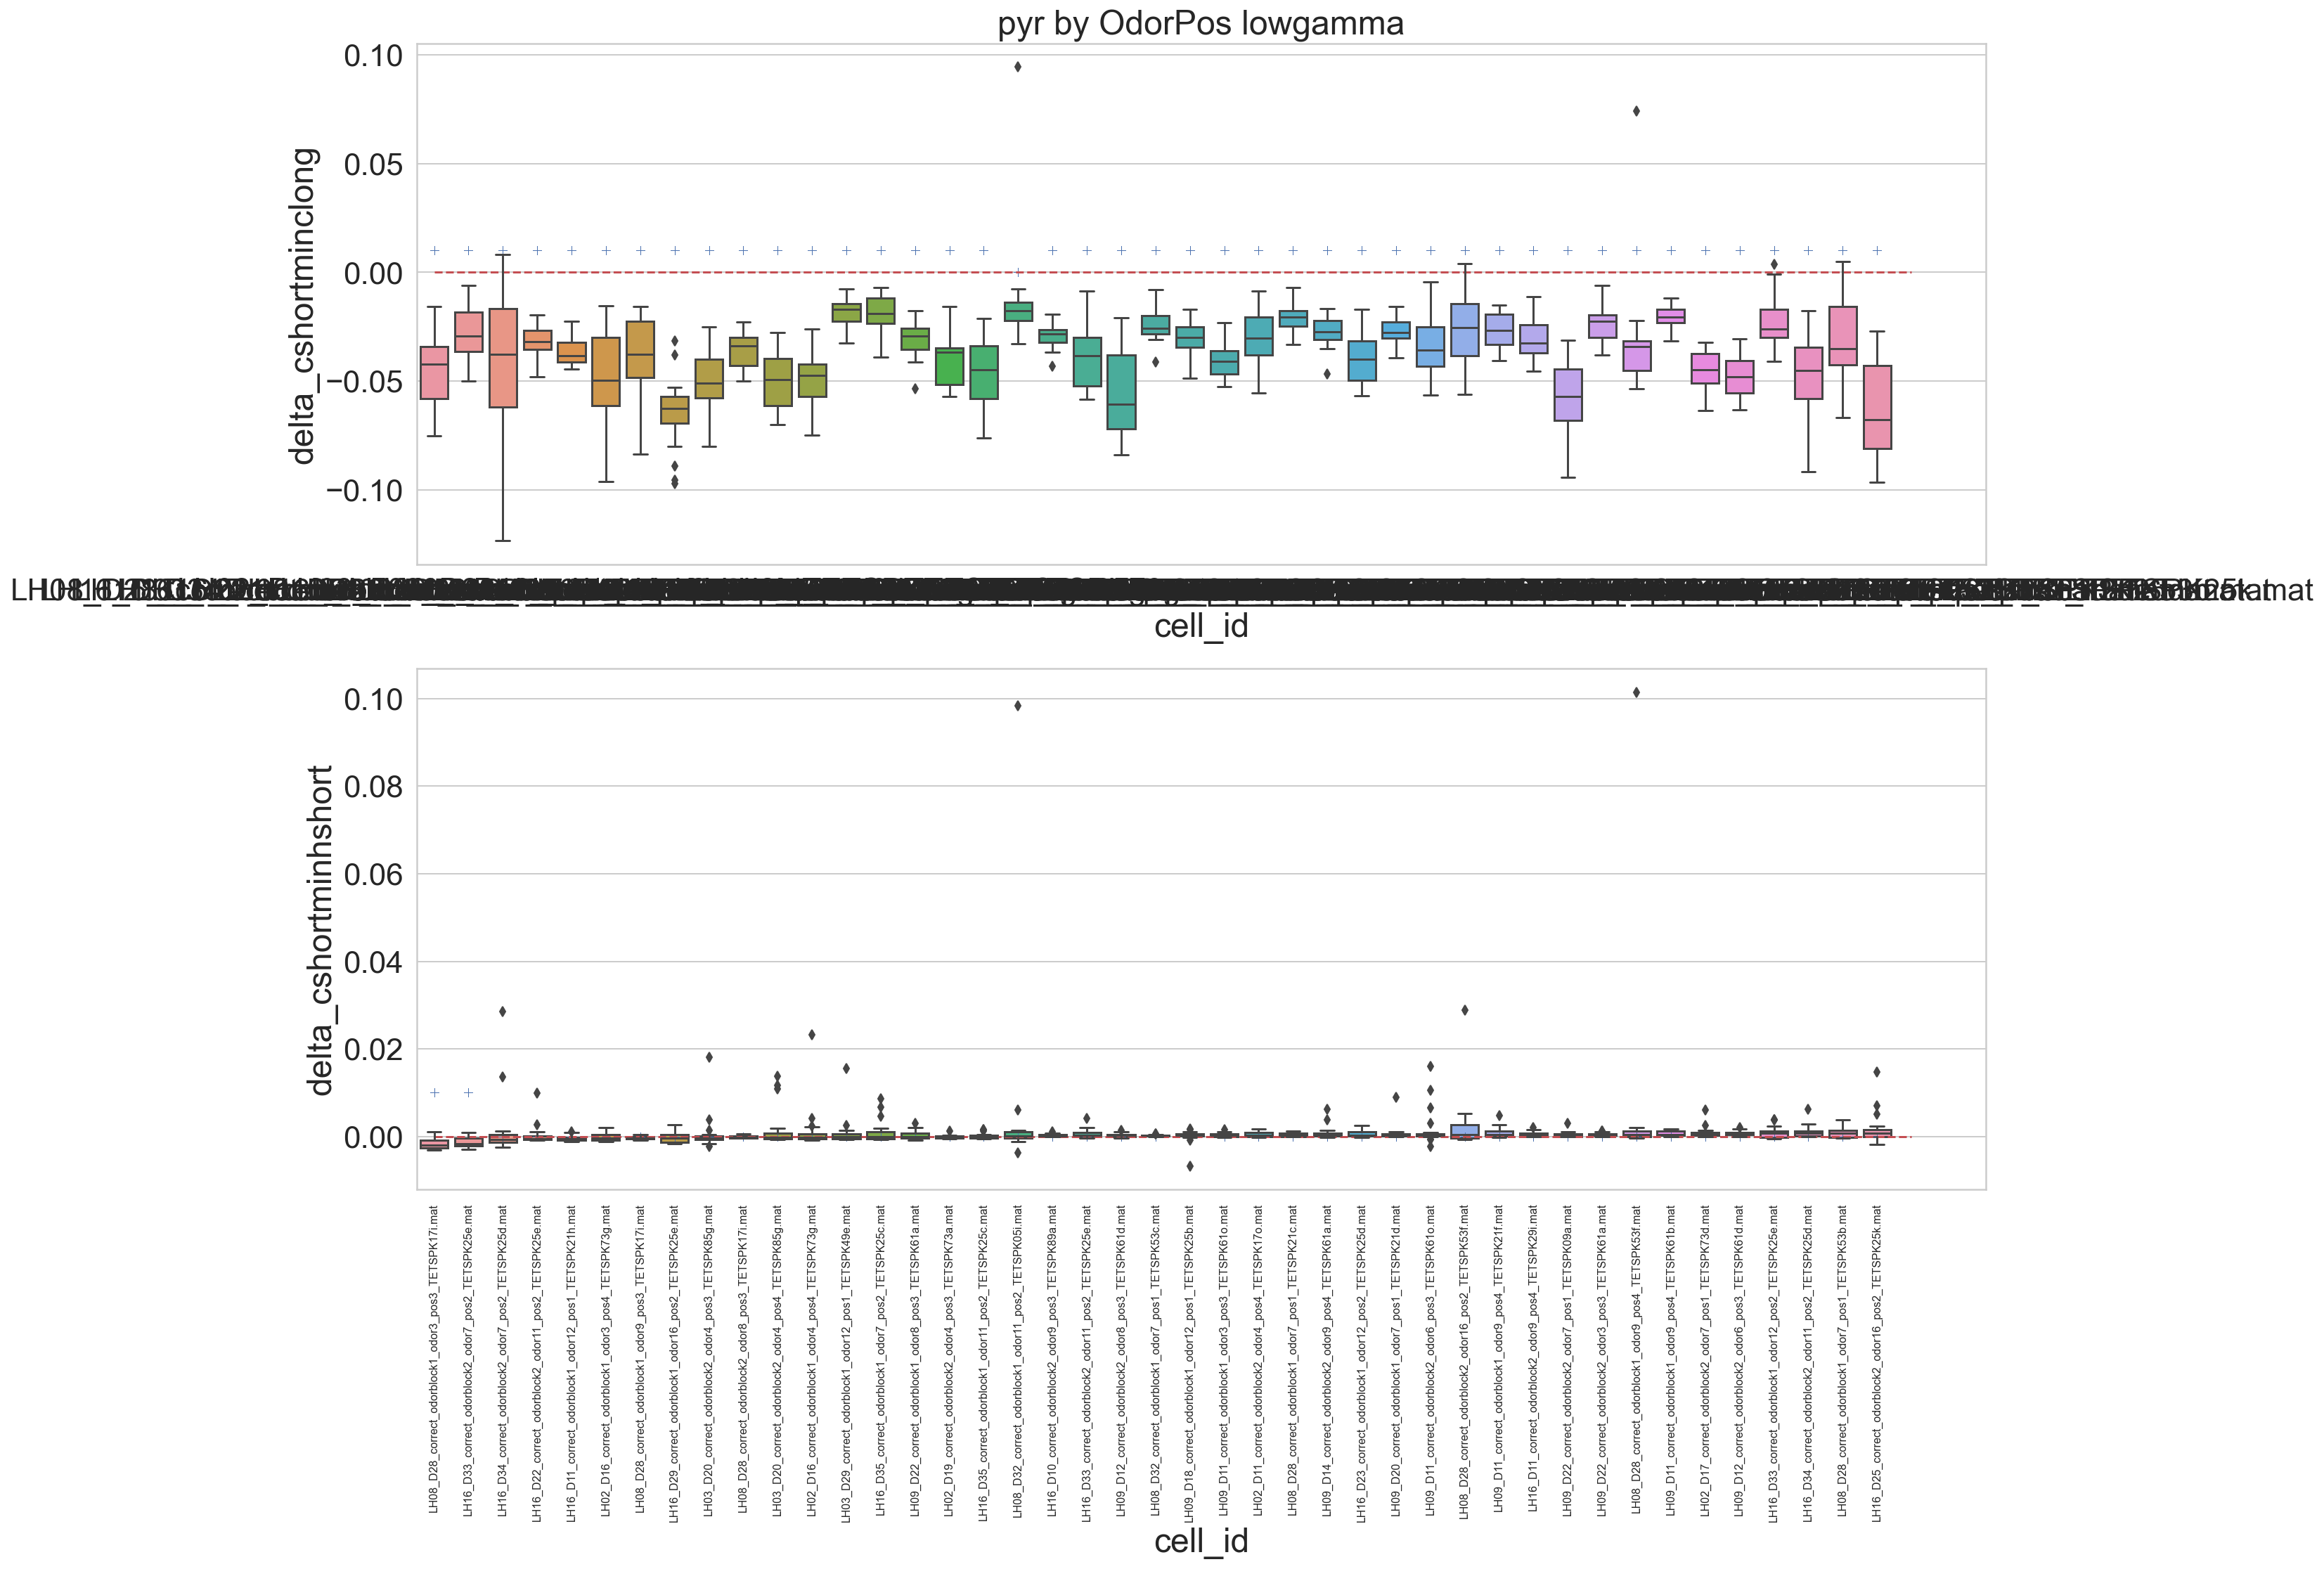

In [35]:
# sns.set_style('whitegrid')
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(theta_deltas_df['cell_id'].to_list()))


sns.boxplot(data=lowgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=lowgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[0]).set_title('pyr by OdorPos lowgamma');

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=lowgamma_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=lowgamma_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')



fig.savefig('pyr_byOdorPos_lowgamma_loglossdeltas_orderBy_median_cshortminhshort.pdf')


In [12]:
subfold = lowgamma_results_df[lowgamma_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort') 

subfold = lowgamma_cshortminclong_results_df[lowgamma_cshortminclong_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong') 

0.046511627906976744 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort
0.9767441860465116 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong


In [23]:
rhythm = 'beta'
longhist = '250ms'
deltas = []
for fold in tqdm(range(20)):

    foldpath = 'RESULTS/PhaseHistModels_AllCells_pyr_byOdorPos/pyrlogoddsCompleteSinglePredMdls516/' + rhythm + longhist + '/folds/' + str(fold) +'/single_neuron/'

    folders = os.listdir(foldpath)
    len(folders)
    
    for folder in folders:
        
        nrnpath = os.path.join(foldpath,folder)
        
        probs_test = pd.read_csv(os.path.join(nrnpath,'probs_models_test.csv'))
        
        test_data = pd.read_csv(os.path.join(nrnpath,'test_data.csv'))
        
        y = test_data['spikes']
        
        cshort_loss, _, _ = logloss(probs_test['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        clong_loss, _, _ = logloss(probs_test['p_clong'],y)
        
        tmp_delta_cshminhsh = cshort_loss - hshort_loss
        tmp_delta_cshmincln = cshort_loss - clong_loss
      
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        
        all_kls = kl(probs_test['p_cshort'],probs_test['p_hshort'])
        avg_kl = np.mean(all_kls)
        
        deltas.append({'cell_id': folder,
                       'fold': fold,
                       'delta_cshortminhshort': tmp_delta_cshminhsh,
                       'delta_cshortminclong': tmp_delta_cshmincln,
                       'avg_kl_cshort_v_hshort': avg_kl
                      })
        
        
deltas_df = pd.DataFrame(deltas)
        

100%|███████████████████████████████████████████| 20/20 [05:06<00:00, 15.32s/it]


In [24]:
deltas_df.to_csv(os.path.join('RESULTS/pyr_byOdorPos_beta_logloss_deltas_20folds.csv'))

In [13]:
beta_deltas_df = pd.read_csv(os.path.join('RESULTS/pyr_byOdorPos_beta_logloss_deltas_20folds.csv'))

In [14]:
sig_thresh = 0.001
scale_sig_marks = 100
beta_medians_df = beta_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
beta_results_df = makefig_population_loglossdeltas(beta_deltas_df,
                                                    beta_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


beta_cshortminclong_results_df = makefig_population_loglossdeltas(beta_deltas_df,
                                                                   beta_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



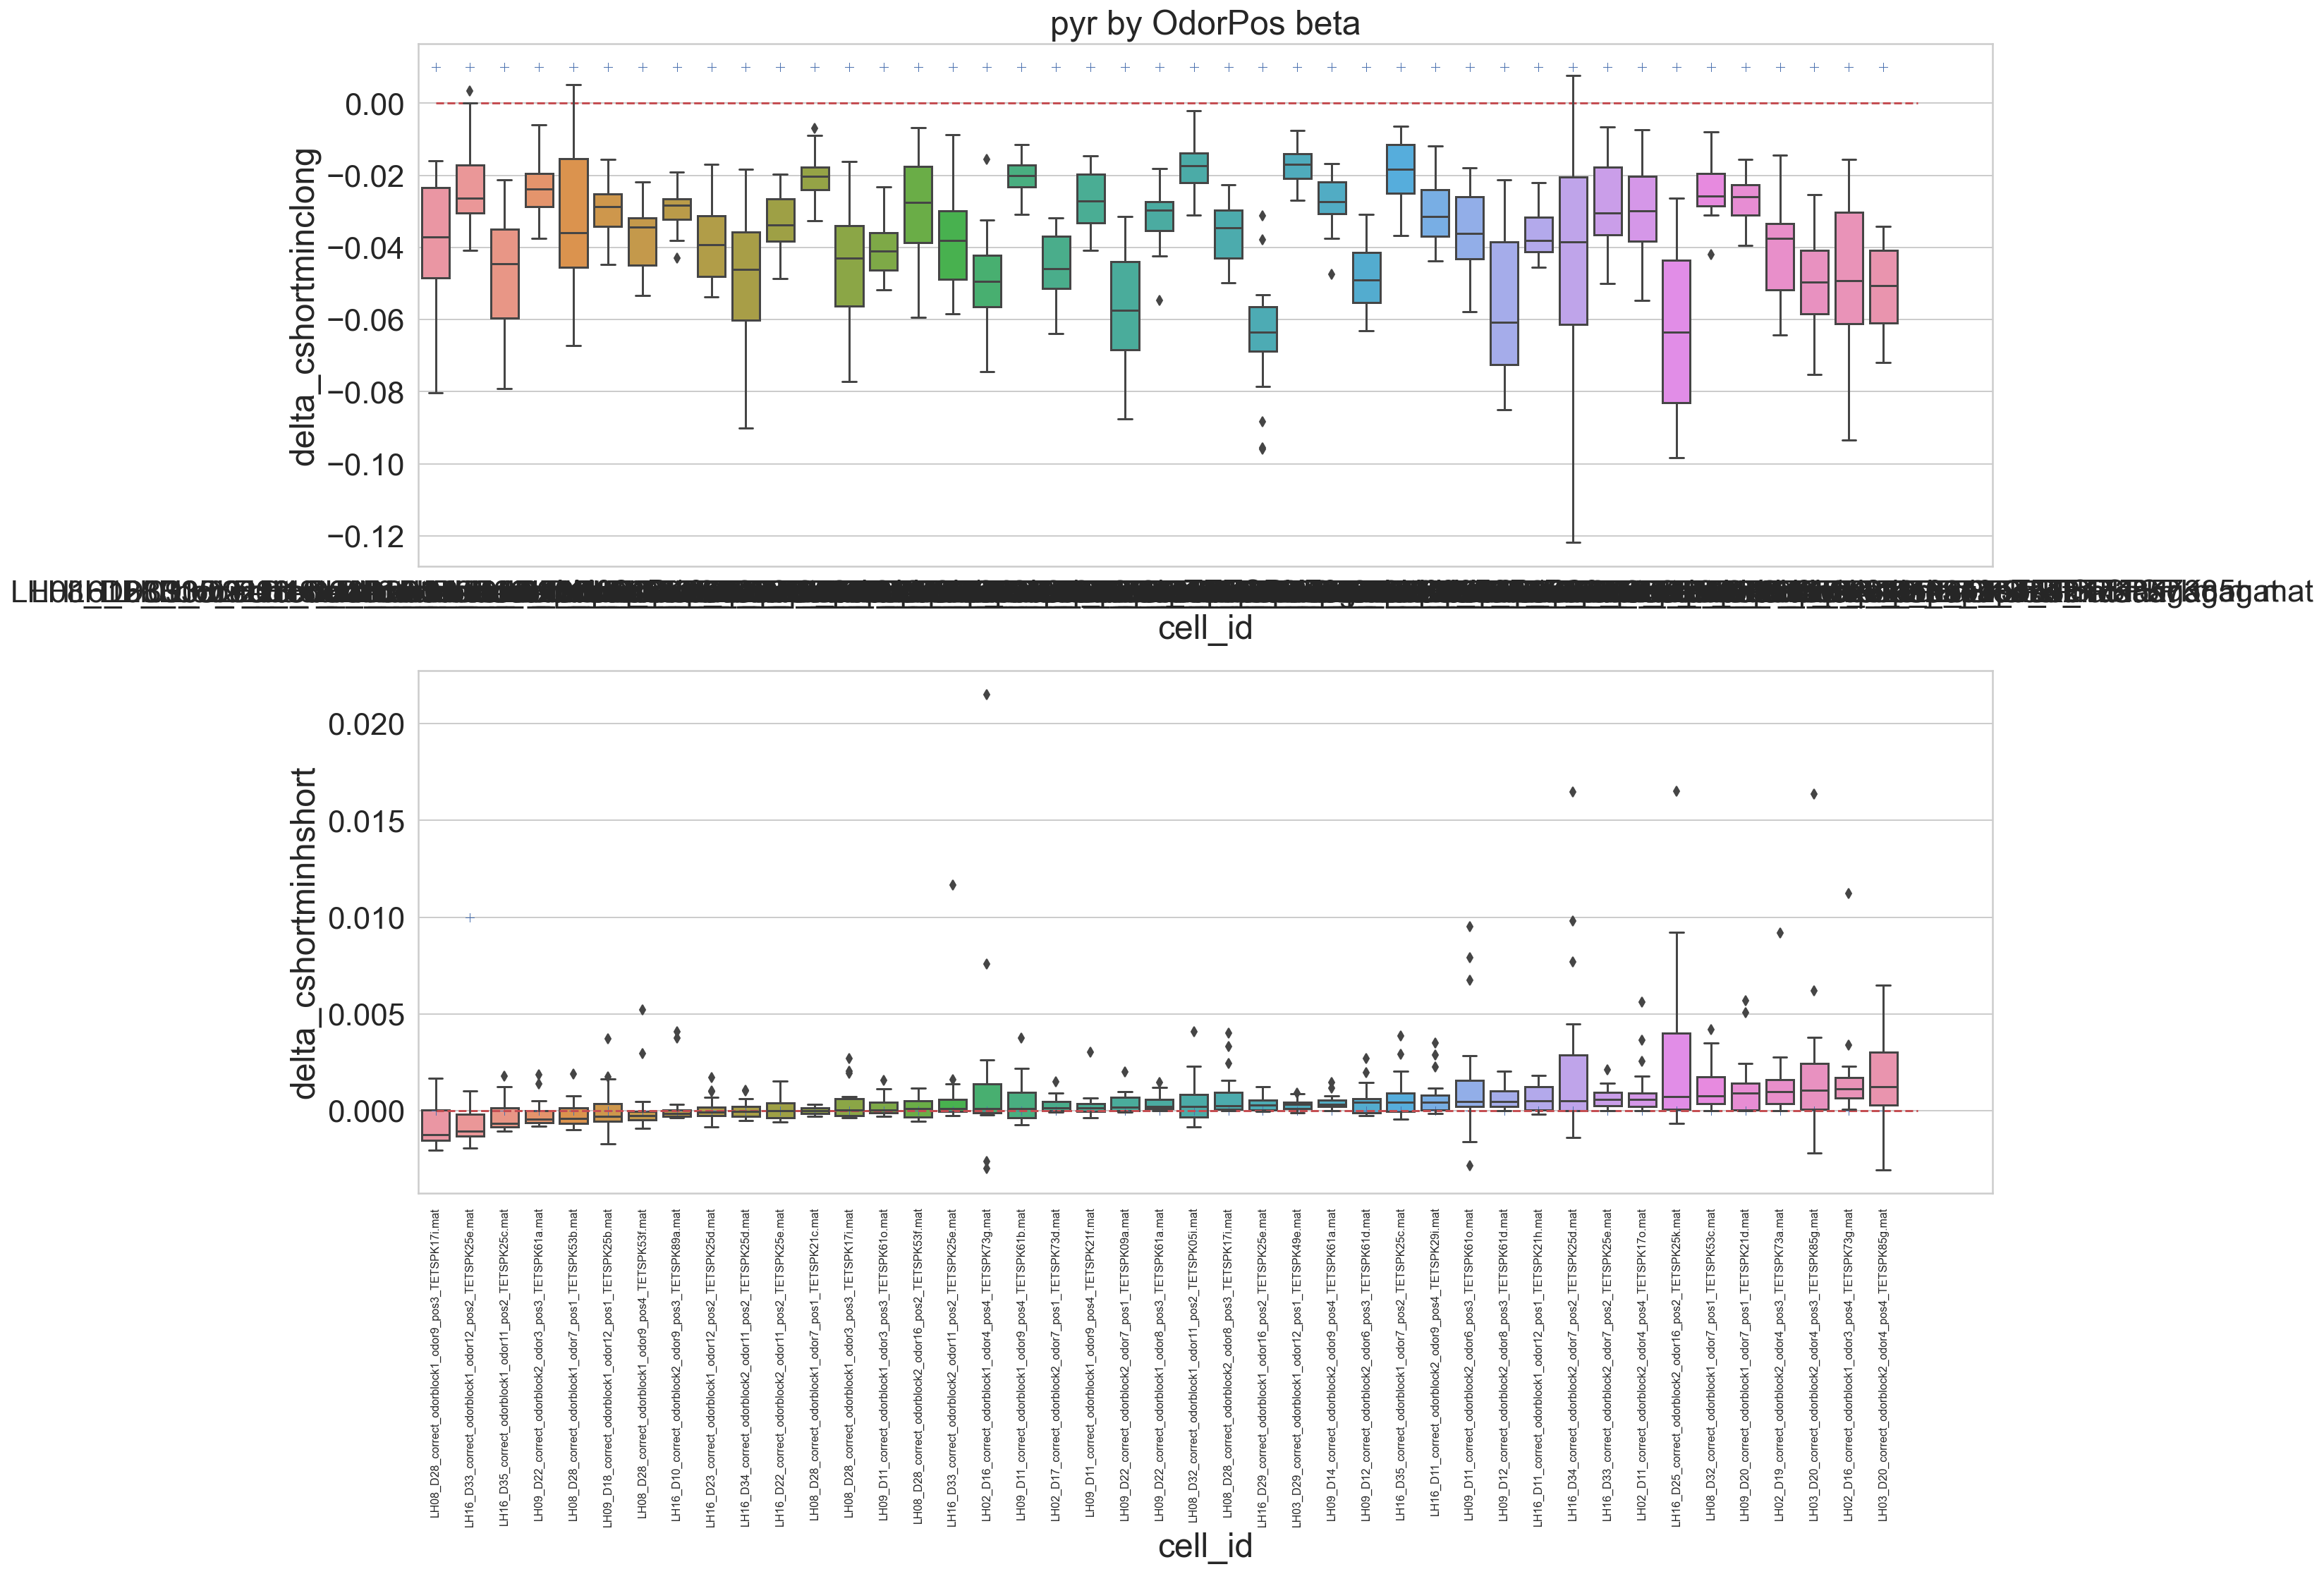

In [34]:
# sns.set_style('whitegrid')
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(theta_deltas_df['cell_id'].to_list()))


sns.boxplot(data=beta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=beta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[0]).set_title('pyr by OdorPos beta');

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=beta_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=beta_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')


fig.savefig('pyr_byOdorPos_beta_loglossdeltas_orderBy_median_cshortminhshort.pdf')



In [16]:
subfold = beta_results_df[beta_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort') 

subfold = beta_cshortminclong_results_df[beta_cshortminclong_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong') 

0.023255813953488372 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort
1.0 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong


In [30]:
rhythm = 'highgamma'
longhist = '250ms'
deltas = []
for fold in tqdm(range(20)):

    foldpath = 'RESULTS/PhaseHistModels_AllCells_pyr_byOdorPos/pyrlogoddsCompleteSinglePredMdls405/' + rhythm + longhist + '/folds/' + str(fold) +'/single_neuron/'

    folders = os.listdir(foldpath)
    len(folders)
    
    for folder in folders:
        
        nrnpath = os.path.join(foldpath,folder)
        
        probs_test = pd.read_csv(os.path.join(nrnpath,'probs_models_test.csv'))
        
        test_data = pd.read_csv(os.path.join(nrnpath,'test_data.csv'))
        
        y = test_data['spikes']
        
        cshort_loss, _, _ = logloss(probs_test['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        clong_loss, _, _ = logloss(probs_test['p_clong'],y)
        
        tmp_delta_cshminhsh = cshort_loss - hshort_loss
        tmp_delta_cshmincln = cshort_loss - clong_loss
      
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        
        all_kls = kl(probs_test['p_cshort'],probs_test['p_hshort'])
        avg_kl = np.mean(all_kls)
        
        deltas.append({'cell_id': folder,
                       'fold': fold,
                       'delta_cshortminhshort': tmp_delta_cshminhsh,
                       'delta_cshortminclong': tmp_delta_cshmincln,
                       'avg_kl_cshort_v_hshort': avg_kl
                      })
        
        
deltas_df = pd.DataFrame(deltas)
        

 80%|██████████████████████████████████▍        | 16/20 [04:06<00:57, 14.44s/it]/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:13: RuntimeWarning: divide by zero encountered in log2
  kls.append(p1*np.log2(p1/p2)+(1-p1)*np.log2((1-p1)/(1-p2)))
/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:13: RuntimeWarning: invalid value encountered in double_scalars
  kls.append(p1*np.log2(p1/p2)+(1-p1)*np.log2((1-p1)/(1-p2)))
100%|███████████████████████████████████████████| 20/20 [04:59<00:00, 14.98s/it]


In [31]:
deltas_df.to_csv(os.path.join('RESULTS/pyr_byOdorPos_highgamma_logloss_deltas_20folds.csv'))

In [17]:
highgamma_deltas_df = pd.read_csv(os.path.join('RESULTS/pyr_byOdorPos_highgamma_logloss_deltas_20folds.csv'))

In [18]:
sig_thresh = 0.001
scale_sig_marks = 100
highgamma_medians_df = highgamma_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
highgamma_results_df = makefig_population_loglossdeltas(highgamma_deltas_df,
                                                    highgamma_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


highgamma_cshortminclong_results_df = makefig_population_loglossdeltas(highgamma_deltas_df,
                                                                   highgamma_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )



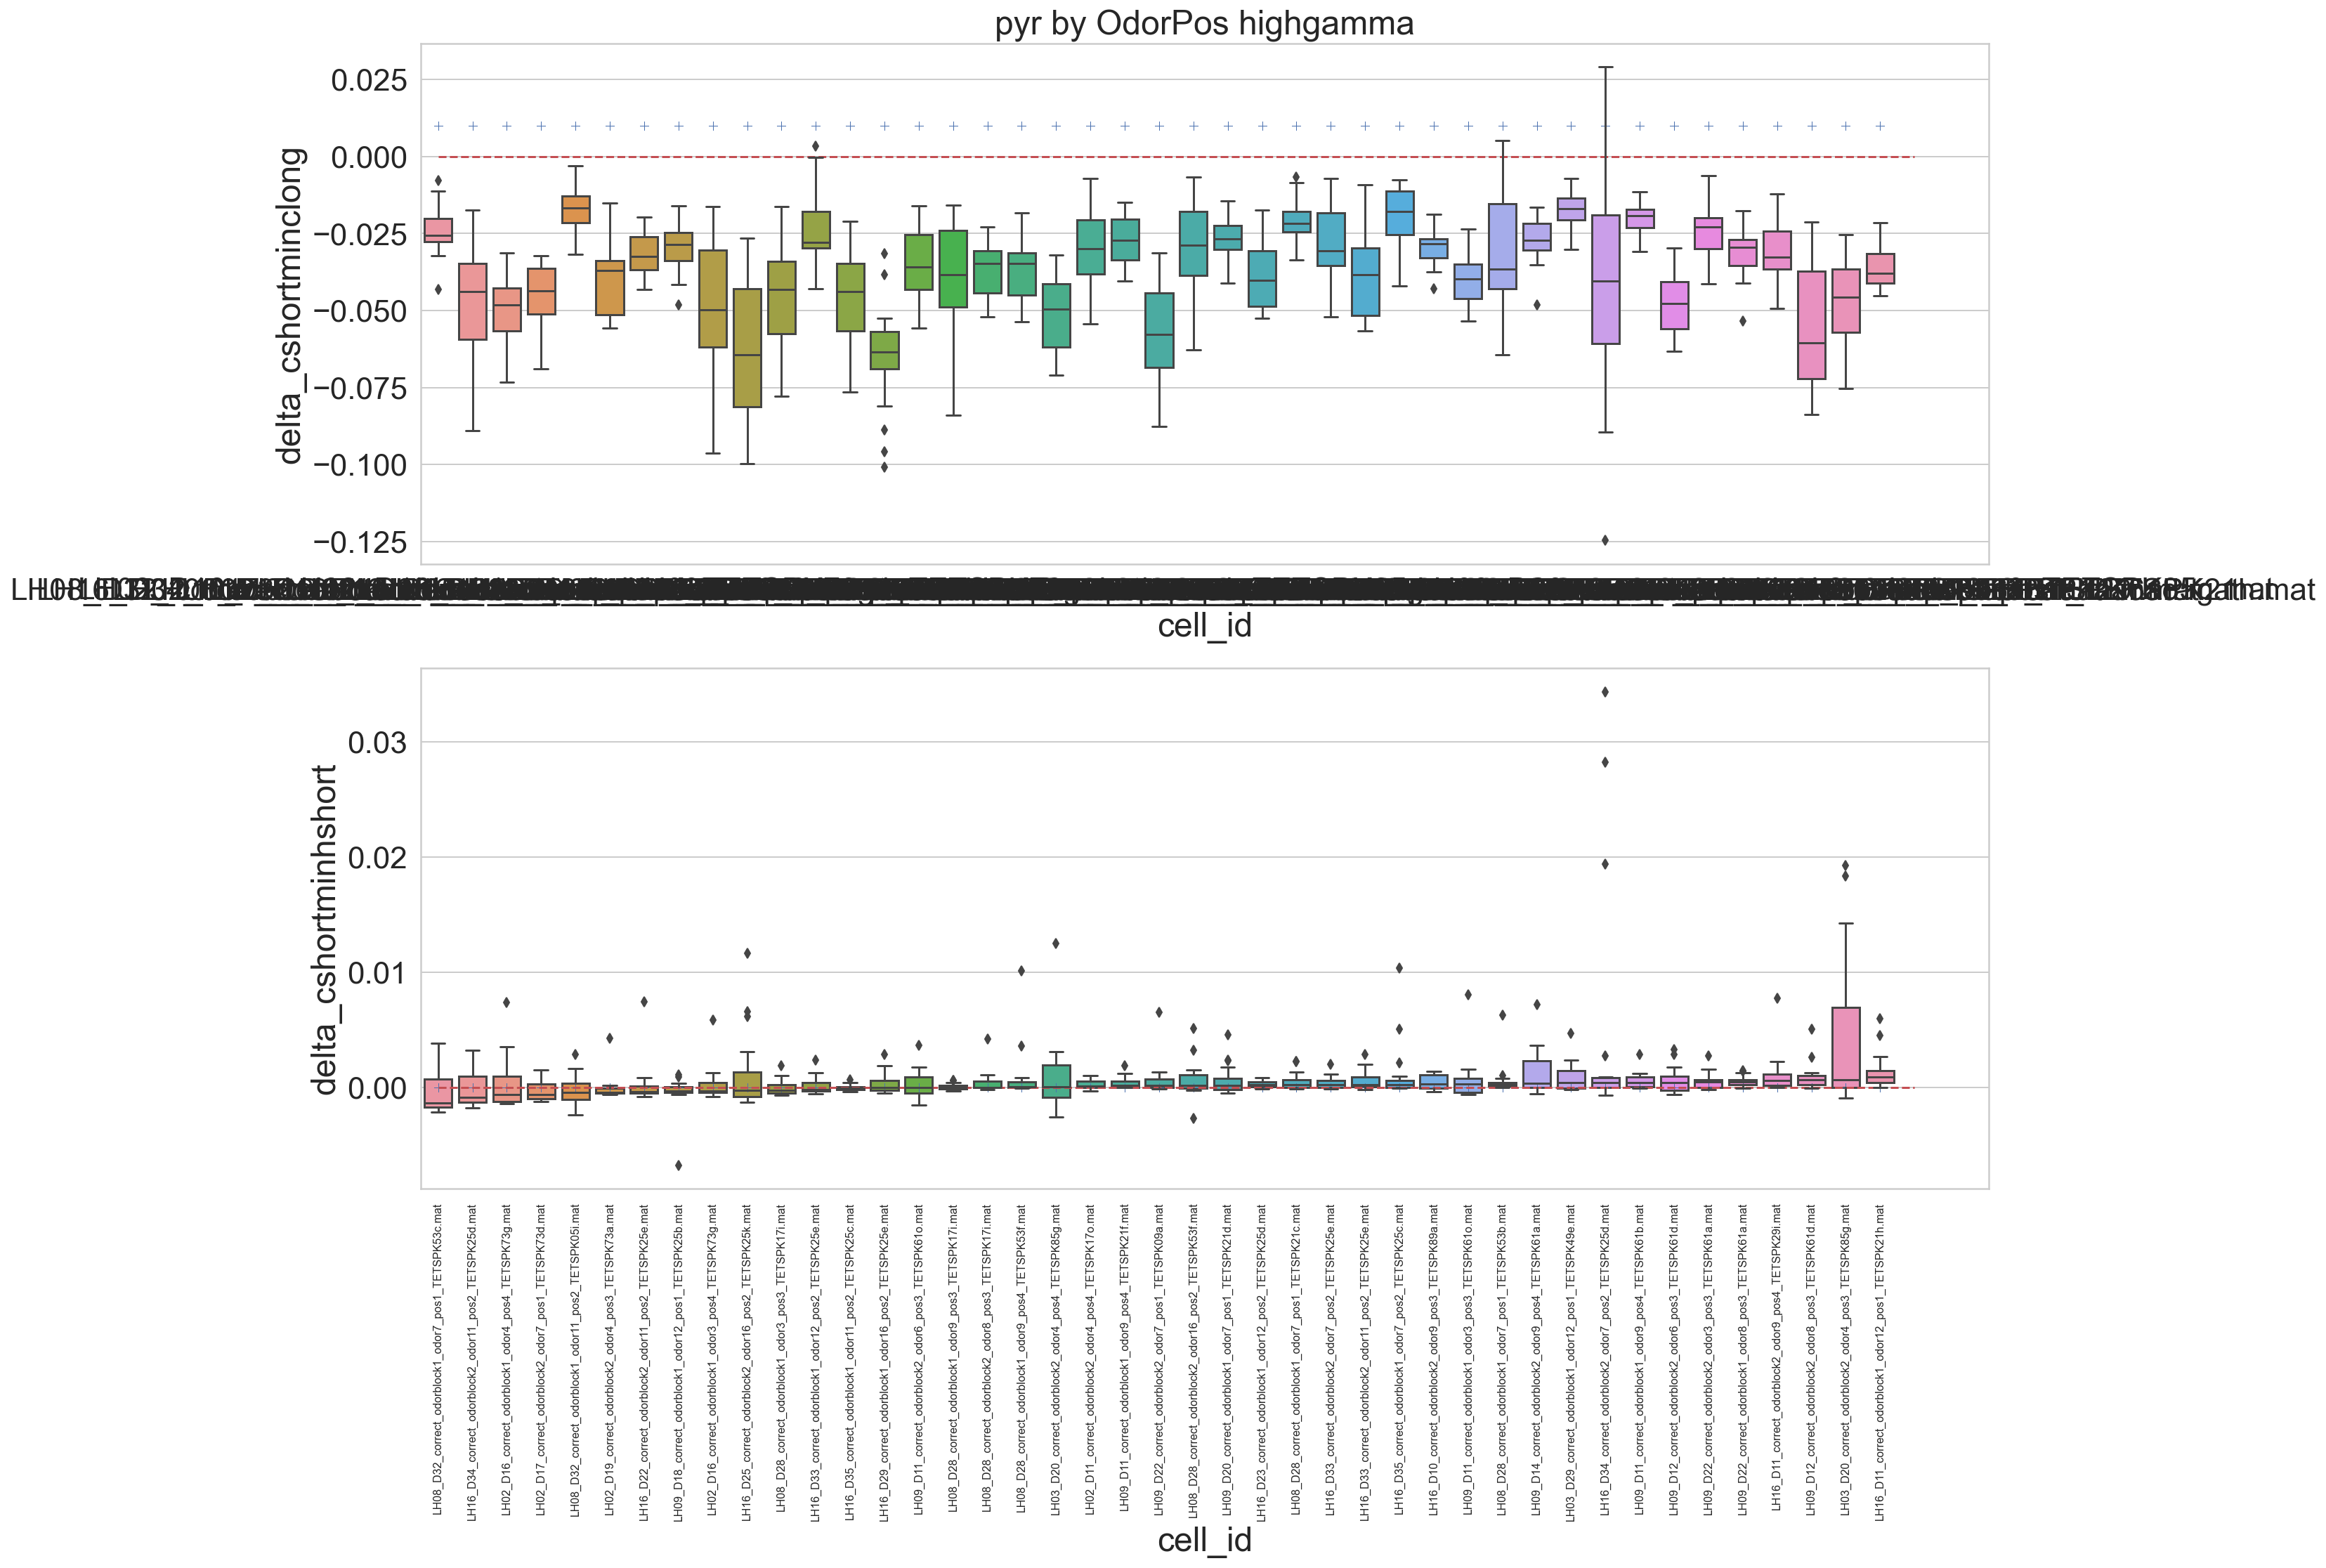

In [33]:
# sns.set_style('whitegrid')
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(highgamma_deltas_df['cell_id'].to_list()))


sns.boxplot(data=highgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=highgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[0]).set_title('pyr by OdorPos highgamma');

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=highgamma_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=highgamma_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')


fig.savefig('pyr_byOdorPos_highgamma_loglossdeltas_orderBy_median_cshortminhshort.pdf')



In [20]:
subfold = highgamma_results_df[highgamma_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort') 

subfold = highgamma_cshortminclong_results_df[highgamma_cshortminclong_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong') 

0.0 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort
1.0 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong


# interneurons: compute the log loss deltas across the population

Fig.3, revision, add the Rayleigh p-val to the figs

In [4]:
int_lowgamma_deltas_df = pd.read_csv(os.path.join('RESULTS/logloss_deltas_lowgamma_20folds.csv'))

In [5]:
sig_thresh = 0.001
scale_sig_marks = 100
int_lowgamma_medians_df = int_lowgamma_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
int_lowgamma_results_df = makefig_population_loglossdeltas(int_lowgamma_deltas_df,
                                                    int_lowgamma_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


int_lowgamma_cshortminclong_results_df = makefig_population_loglossdeltas(int_lowgamma_deltas_df,
                                                                   int_lowgamma_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )

In [9]:
import scipy.io as sio

In [20]:
# datapath = 'python_spkphase_multirhythm/'
datapath = '/Volumes/Sula/PhaseModelsOverTime/data/python_spkphaseOdorsamp_multirhythm/'
folders = os.listdir(datapath)
folders = [f for f in folders if not f.startswith('.')]
ray_df = []

rhythm = 'lowgamma'
for folder in tqdm(folders):
    
    filelist = os.listdir(os.path.join(datapath,folder))
    file = [f for f in filelist if f.endswith('.mat')]
    file = [f for f in file if not f.startswith('.')][0]
    filepath = os.path.join(datapath,folder)
    matfile = sio.loadmat(os.path.join(filepath,file))
    
    df = pd.DataFrame()

    df['spikes'] = matfile['spikes_long'].tolist()[0]
    df['lowgamma_35_55_phases'] = matfile[rhythm+'phase_long'].tolist()[0]
        
    tmp = rayleigh_pr(df,'lowgamma_35_55')
    tmp['cell_id'] = folder
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)  

int_lowgamma_all_results_df = pd.merge(int_lowgamma_results_df, raypop_df, on='cell_id')
int_lowgamma_all_results_df = make_significance_column(int_lowgamma_all_results_df,'pval_y',0.001,50,'ray_significant_scaled')

int_lowgamma_cshortminclong_ray_df = pd.merge(int_lowgamma_cshortminclong_results_df, raypop_df, on='cell_id')
int_lowgamma_cshortminclong_ray_df = make_significance_column(int_lowgamma_cshortminclong_ray_df,'pval_y',0.001,40,'ray_significant_scaled')



100%|█████████████████████████████████████████| 134/134 [00:34<00:00,  3.94it/s]


In [21]:
int_lowgamma_cshortminclong_ray_df.head(5)

Unnamed: 0                                              cell_id  fold  \
0           0  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     0   
1         134  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     1   
2         268  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     2   
3         402  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     3   
4         536  LH16_07_09_14_D09_theta_correct_odorblock1TETSPK21j     4   

   delta_cshortminhshort  delta_cshortminclong  avg_kl_cshort_v_hshort  \
0               0.000001             -0.005071                0.000003   
1               0.000556             -0.004250                0.000348   
2               0.000003             -0.002249                0.000002   
3               0.000006             -0.004337                0.000005   
4               0.000012             -0.003615                0.000003   

   delta_cshortminhshort_median     tstat        pval_x  significant  \
0                      0.000003 -9.662922  4.558552e-09            1   
1                      0.000003 -9.662922  4.558552e-09            1   
2                      0.000003 -9.662922  4.558552e-09            1   
3                      0.000003 -9.662922  4.558552e-09            1   
4                      0.000003 -9.662922  4.558552e-09            1   

   significant_scaled          rhythm       mrl         R         z  circmean  \
0                0.01  lowgamma_35_55  0.004454  2.583156  0.011505 -2.382179   
1                0.01  lowgamma_35_55  0.004454  2.583156  0.011505 -2.382179   
2                0.01  lowgamma_35_55  0.004454  2.583156  0.011505 -2.382179   
3                0.01  lowgamma_35_55  0.004454  2.583156  0.011505 -2.382179   
4                0.01  lowgamma_35_55  0.004454  2.583156  0.011505 -2.382179   

     pval_y  ray_significant_scaled  ray_significant_scaled_scaled  
0  0.988571                       0                            0.0  
1  0.988571                       0                            0.0  
2  0.988571                       0                            0.0  
3  0.988571                       0                            0.0  
4  0.988571                       0                            0.0

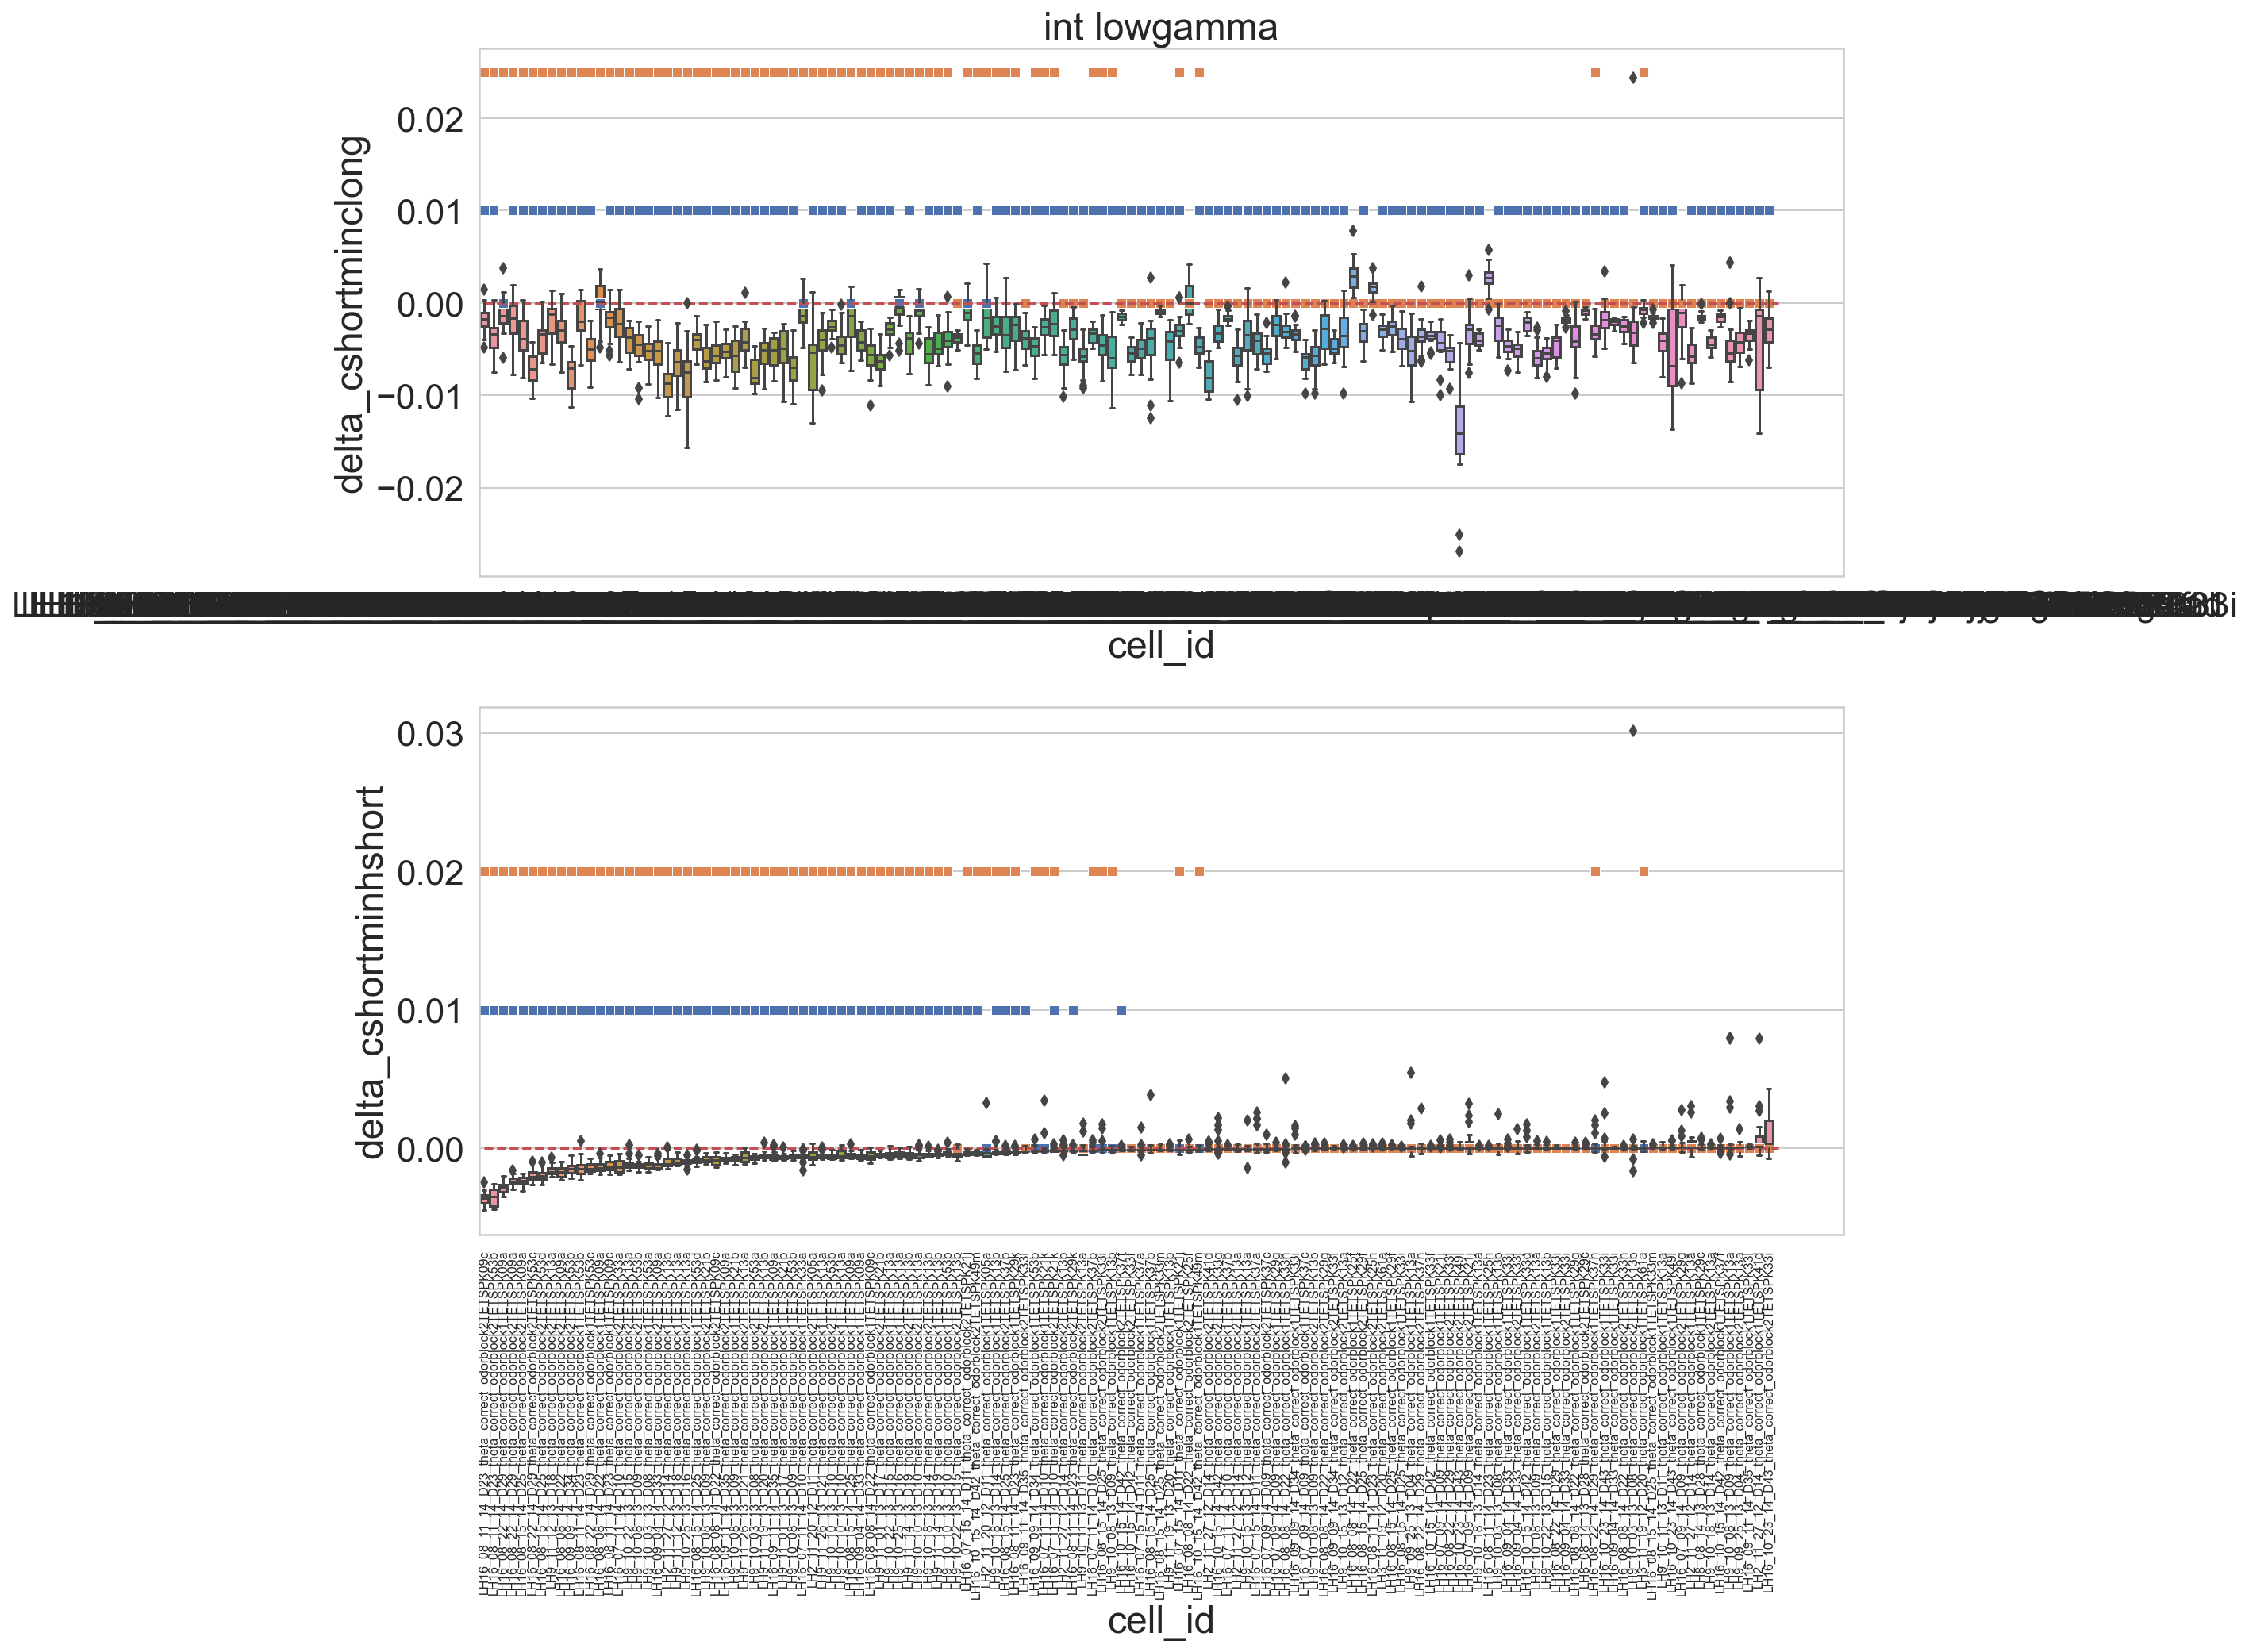

In [22]:
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(int_lowgamma_cshortminclong_results_df['cell_id'].to_list()))


sns.boxplot(data=int_lowgamma_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=int_lowgamma_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[0]).set_title('int lowgamma');

sns.scatterplot(data=int_lowgamma_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[0])

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=int_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=int_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[1])

sns.scatterplot(data=int_lowgamma_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')


fig.tight_layout()
# fig.savefig('int_lowgamma_loglossdeltas_orderBy_median_cshortminhshort_pvals_Ray_and_ttest.pdf')


### which neurons were picked out by ray? which ones were picked out by log loss delta?
for low gamma

In [24]:
tmpttest = int_lowgamma_all_results_df[int_lowgamma_all_results_df['significant']==1]
print('# neurons significant phaseSH v. SH log loss delta ',len(list(set(tmpttest['cell_id'].to_list()))))

# neurons significant phaseSH v. SH log loss delta  59


In [26]:
tmpray = int_lowgamma_all_results_df[int_lowgamma_all_results_df['ray_significant_scaled']==1]
print('# neurons significant ray: ', len(list(set(tmpray['cell_id'].to_list()))))

# neurons significant ray:  65


In [40]:
ttest_sigcells = list(set(tmpttest['cell_id'].to_list()))
ray_sigcells = list(set(tmpray['cell_id'].to_list()))

ttest_multiset = collections.Counter(ttest_sigcells)
ray_multiset = collections.Counter(ray_sigcells)

overlap = list((ttest_multiset & ray_multiset).elements())
ttest_noRay = list((ttest_multiset - ray_multiset).elements())
ray_nottest = list((ray_multiset - ttest_multiset).elements())

print('log loss delta and ray coincide for :', len(overlap), ' cells')
print('rayleigh misses: ', len(ttest_noRay), ' cells that log loss delta identifies')
print('log loss delta misses: ', len(ray_nottest), ' cells that rayleigh identifies')

log loss delta and ray coincide for : 55  cells
rayleigh misses:  4  cells that log loss delta identifies
log loss delta misses:  10  cells that rayleigh identifies


In [32]:
pprint(ttest_noRay)

['LH16_08_11_14_D23_theta_correct_odorblock2TETSPK29k',
 'LH16_10_15_14_D42_theta_correct_odorblock2TETSPK37f',
 'LH9_10_22_13_D15_theta_correct_odorblock2TETSPK13b',
 'LH16_09_11_14_D35_theta_correct_odorblock2TETSPK33l']


In [31]:
pprint(ray_nottest)

['LH16_07_15_14_D11_theta_correct_odorblock1TETSPK21j',
 'LH16_10_15_14_D42_theta_correct_odorblock1TETSPK49m',
 'LH16_08_15_14_D25_theta_correct_odorblock2TETSPK33i',
 'LH16_07_11_14_D10_theta_correct_odorblock2TETSPK37b',
 'LH3_11_19_12_D20_theta_correct_odorblock1TETSPK61a',
 'LH16_09_09_14_D34_theta_correct_odorblock1TETSPK53b',
 'LH2_11_20_12_D11_theta_correct_odorblock1TETSPK05a',
 'LH16_08_22_14_D29_theta_correct_odorblock1TETSPK37h',
 'LH16_07_11_14_D10_theta_correct_odorblock1TETSPK21k',
 'LH9_10_08_13_D09_theta_correct_odorblock1TETSPK13b']


In [41]:
int_theta_deltas_df = pd.read_csv(os.path.join('RESULTS/logloss_deltas_theta_20folds.csv'))

In [42]:
sig_thresh = 0.001
scale_sig_marks = 100
int_theta_medians_df = int_theta_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
int_theta_results_df = makefig_population_loglossdeltas(int_theta_deltas_df,
                                                    int_theta_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


int_theta_cshortminclong_results_df = makefig_population_loglossdeltas(int_theta_deltas_df,
                                                                   int_theta_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )

In [43]:
import scipy.io as sio

In [45]:
# datapath = 'python_spkphase_multirhythm/'
datapath = '/Volumes/Sula/PhaseModelsOverTime/data/python_spkphaseOdorsamp_multirhythm/'
folders = os.listdir(datapath)
folders = [f for f in folders if not f.startswith('.')]
ray_df = []

rhythm = 'theta'
for folder in tqdm(folders):
    
    filelist = os.listdir(os.path.join(datapath,folder))
    file = [f for f in filelist if f.endswith('.mat')]
    file = [f for f in file if not f.startswith('.')][0]
    filepath = os.path.join(datapath,folder)
    matfile = sio.loadmat(os.path.join(filepath,file))
    
    df = pd.DataFrame()

    df['spikes'] = matfile['spikes_long'].tolist()[0]
    df['theta_4_12_phases'] = matfile[rhythm+'phase_long'].tolist()[0]
        
    tmp = rayleigh_pr(df,'theta_4_12')
    tmp['cell_id'] = folder
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)    

100%|█████████████████████████████████████████| 134/134 [00:25<00:00,  5.21it/s]


In [46]:
int_theta_all_results_df = pd.merge(int_theta_results_df, raypop_df, on='cell_id')
int_theta_all_results_df = make_significance_column(int_theta_all_results_df,'pval_y',0.001,50,'ray_significant_scaled')


In [47]:
int_theta_cshortminclong_ray_df = pd.merge(int_theta_cshortminclong_results_df, raypop_df, on='cell_id')
int_theta_cshortminclong_ray_df = make_significance_column(int_theta_cshortminclong_ray_df,'pval_y',0.001,40,'ray_significant_scaled')


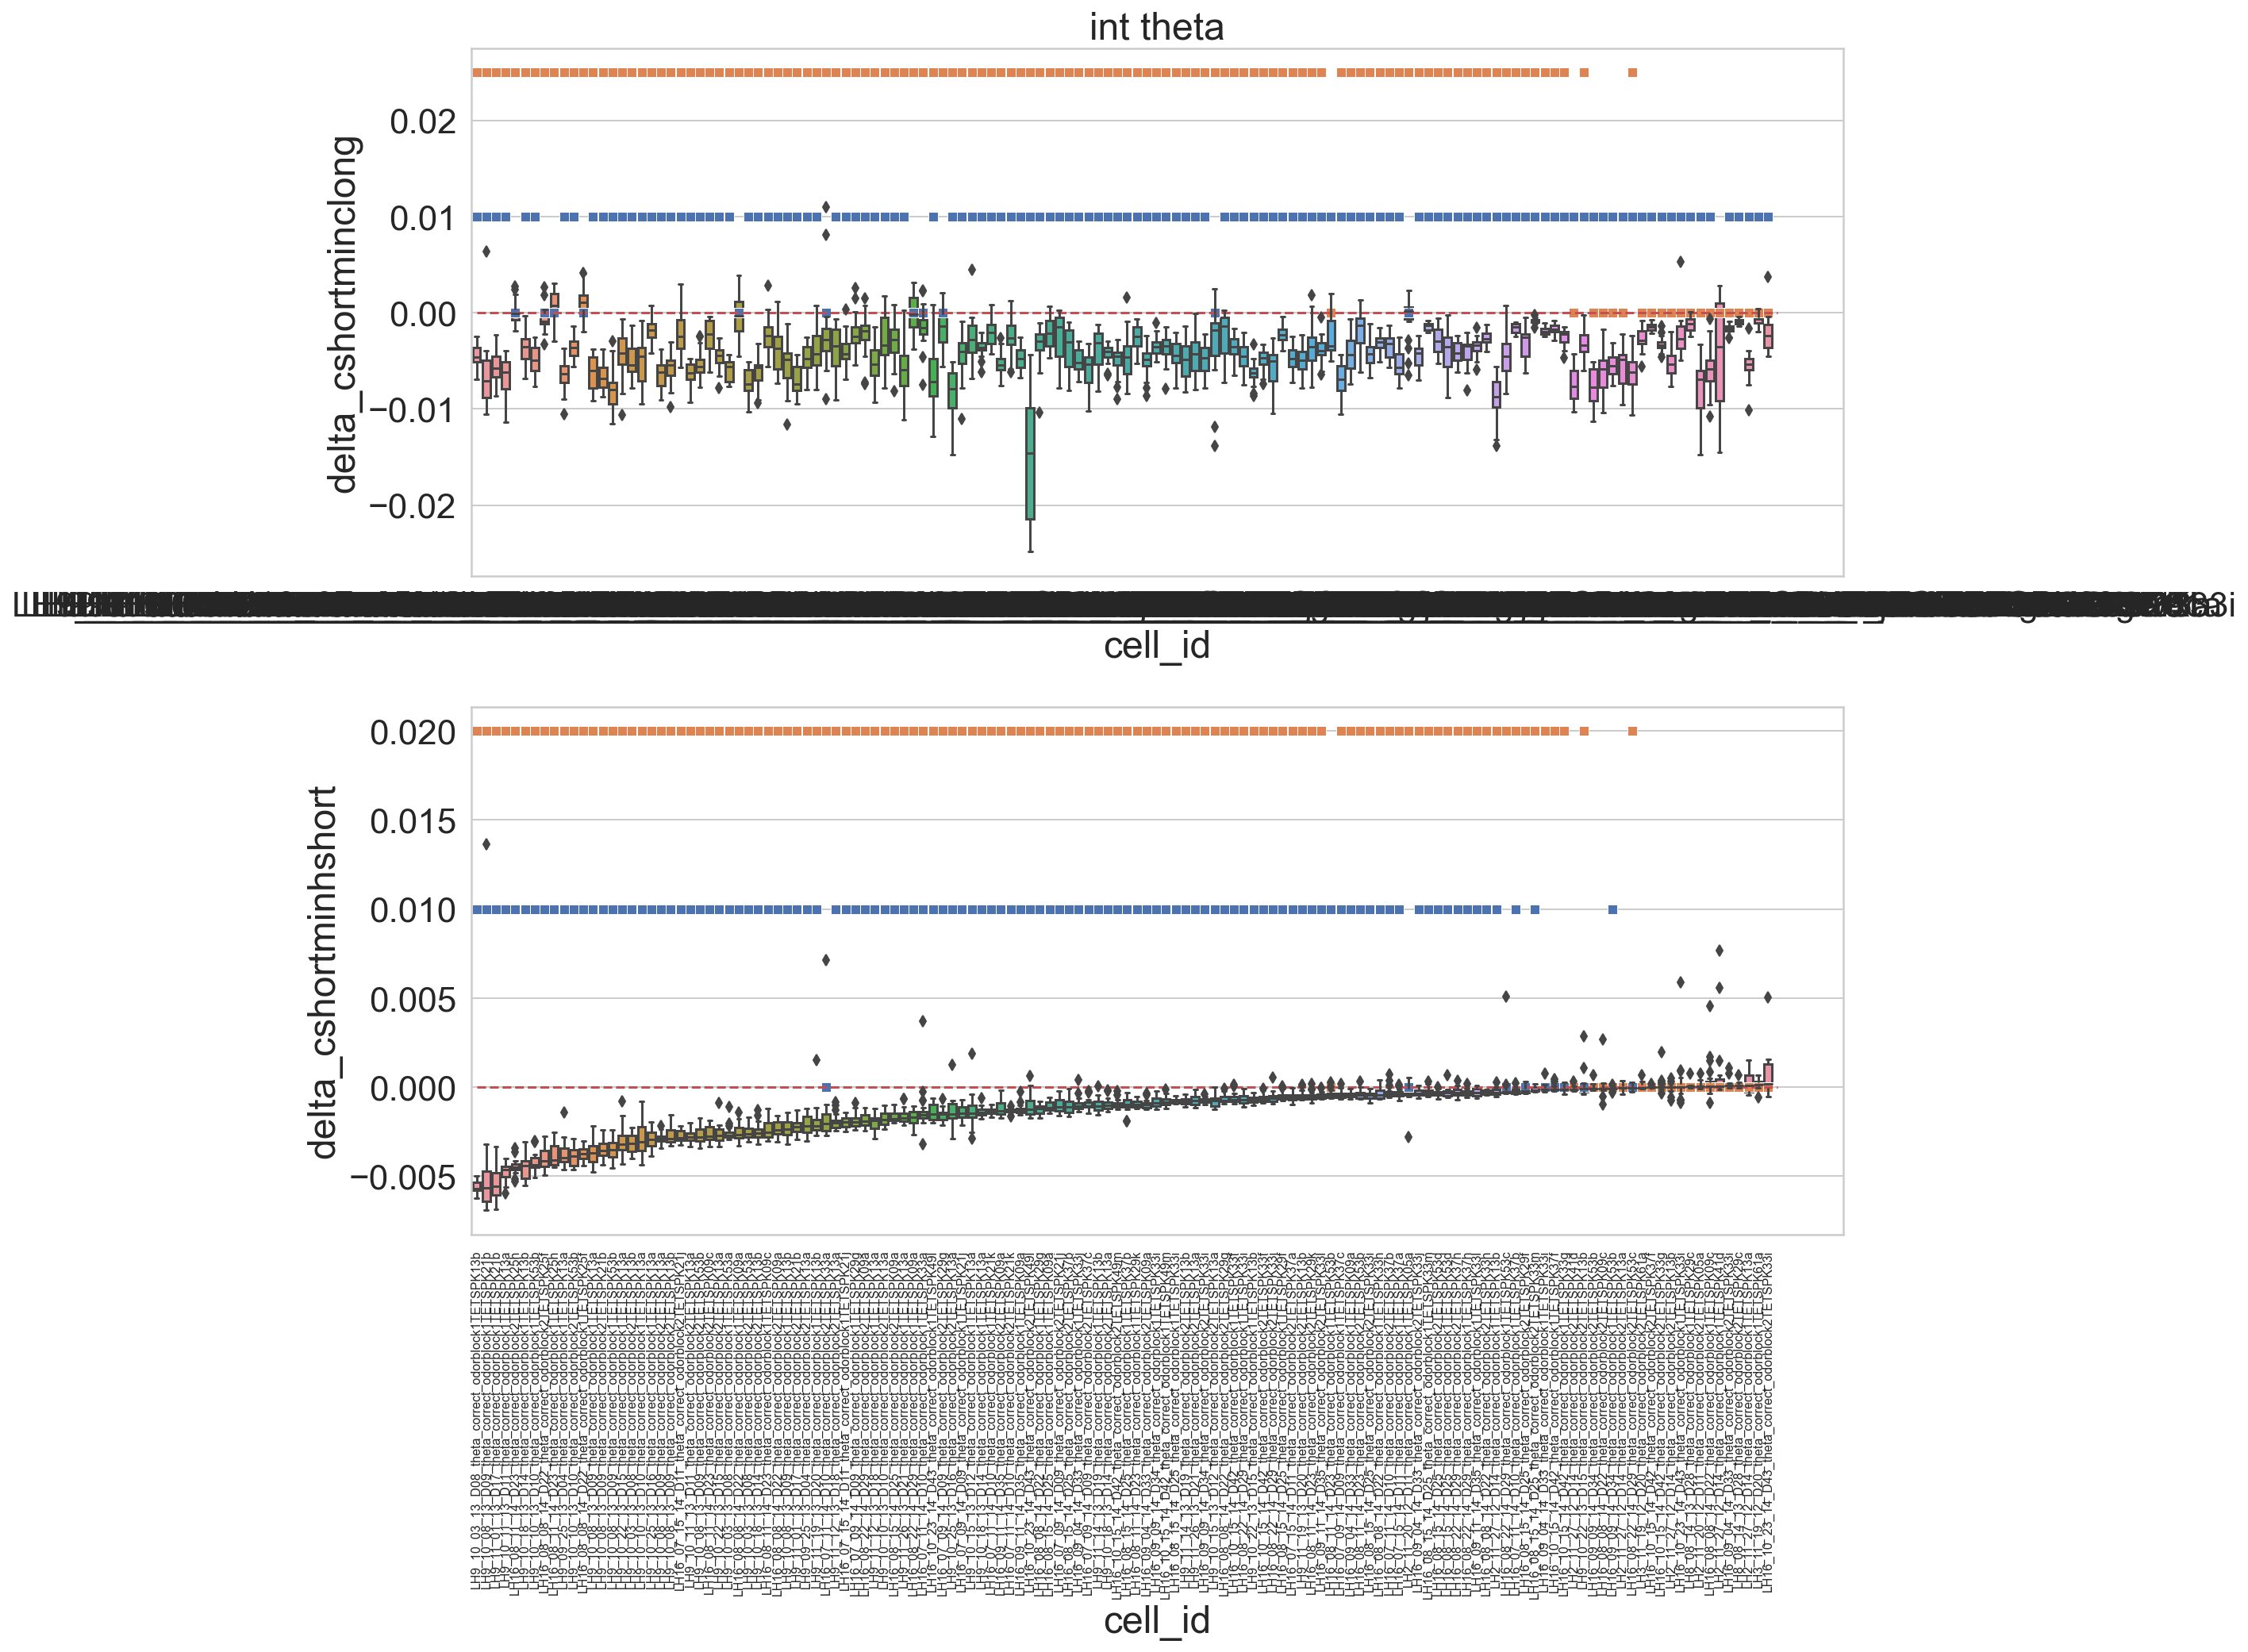

In [48]:
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(int_theta_cshortminclong_results_df['cell_id'].to_list()))


sns.boxplot(data=int_theta_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=int_theta_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[0]).set_title('int theta');

sns.scatterplot(data=int_theta_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[0])

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=int_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=int_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[1])

sns.scatterplot(data=int_theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')


fig.tight_layout()
# fig.savefig('int_theta_loglossdeltas_orderBy_median_cshortminhshort_pvals_Ray_and_ttest.pdf')


In [49]:
tmpttest = int_theta_all_results_df[int_theta_all_results_df['significant']==1]
print('# neurons significant phaseSH v. SH log loss delta ',len(list(set(tmpttest['cell_id'].to_list()))))

tmpray = int_theta_all_results_df[int_theta_all_results_df['ray_significant_scaled']==1]
print('# neurons significant ray: ', len(list(set(tmpray['cell_id'].to_list()))))

# neurons significant phaseSH v. SH log loss delta  107
# neurons significant ray:  114


In [50]:
ttest_sigcells = list(set(tmpttest['cell_id'].to_list()))
ray_sigcells = list(set(tmpray['cell_id'].to_list()))

ttest_multiset = collections.Counter(ttest_sigcells)
ray_multiset = collections.Counter(ray_sigcells)

overlap = list((ttest_multiset & ray_multiset).elements())
ttest_noRay = list((ttest_multiset - ray_multiset).elements())
ray_nottest = list((ray_multiset - ttest_multiset).elements())

print('log loss delta and ray coincide for :', len(overlap), ' cells')
print('rayleigh misses: ', len(ttest_noRay), ' cells that log loss delta identifies')
print('log loss delta misses: ', len(ray_nottest), ' cells that rayleigh identifies')

log loss delta and ray coincide for : 105  cells
rayleigh misses:  2  cells that log loss delta identifies
log loss delta misses:  9  cells that rayleigh identifies


In [51]:
pprint(ttest_noRay)

['LH16_08_11_14_D23_theta_correct_odorblock1TETSPK53b',
 'LH16_09_09_14_D34_theta_correct_odorblock1TETSPK53b']


In [55]:
pprint(ray_nottest)

['LH16_10_15_14_D42_theta_correct_odorblock1TETSPK33g',
 'LH16_07_11_14_D10_theta_correct_odorblock2TETSPK33a',
 'LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c',
 'LH9_10_22_13_D15_theta_correct_odorblock2TETSPK13b',
 'LH16_08_15_14_D25_theta_correct_odorblock2TETSPK29f',
 'LH2_11_20_12_D11_theta_correct_odorblock1TETSPK05a',
 'LH16_10_15_14_D42_theta_correct_odorblock1TETSPK37f',
 'LH16_09_04_14_D33_theta_correct_odorblock1TETSPK33i',
 'LH16_08_22_14_D29_theta_correct_odorblock1TETSPK53c']


##### make betas log loss deltas across 20 folds

In [2]:
rhythm = 'beta' 
longhist = '250ms'
deltas = []
for fold in tqdm(range(20)):

    foldpath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/' + rhythm + 'phase_' + longhist + '/folds/' + str(fold) +'/single_neuron/'

    folders = os.listdir(foldpath)
    len(folders)
    
    for folder in folders:
        
        nrnpath = os.path.join(foldpath,folder)
        
        probs_test = pd.read_csv(os.path.join(nrnpath,'probs_models_test.csv'))
        
        test_data = pd.read_csv(os.path.join(nrnpath,'test_data.csv'))
        
        y = test_data['spikes']
        
        cshort_loss, _, _ = logloss(probs_test['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        clong_loss, _, _ = logloss(probs_test['p_clong'],y)
        
        tmp_delta_cshminhsh = cshort_loss - hshort_loss
        tmp_delta_cshmincln = cshort_loss - clong_loss
      
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        
        all_kls = kl(probs_test['p_cshort'],probs_test['p_hshort'])
        avg_kl = np.mean(all_kls)
        
        deltas.append({'cell_id': folder,
                       'fold': fold,
                       'delta_cshortminhshort': tmp_delta_cshminhsh,
                       'delta_cshortminclong': tmp_delta_cshmincln,
                       'avg_kl_cshort_v_hshort': avg_kl
                      })
        
        
int_beta_deltas_df = pd.DataFrame(deltas)

100%|████████████████████████████████████████| 20/20 [1:27:47<00:00, 263.38s/it]


In [3]:
int_beta_deltas_df.to_csv('RESULTS/logloss_deltas_beta_20folds.csv')

In [7]:
sig_thresh = 0.001
scale_sig_marks = 100
int_beta_medians_df = int_beta_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
int_beta_results_df = makefig_population_loglossdeltas(int_beta_deltas_df,
                                                    int_beta_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


int_beta_cshortminclong_results_df = makefig_population_loglossdeltas(int_beta_deltas_df,
                                                                   int_beta_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )

In [8]:
import scipy.io as sio


In [9]:
datapath = 'python_spkphase_multirhythm/'
folders = os.listdir(datapath)
folders = [f for f in folders if not f.startswith('.')]
ray_df = []

rhythm = 'beta'
for folder in tqdm(folders):
    
    filelist = os.listdir(os.path.join(datapath,folder))
    file = [f for f in filelist if not f.startswith('.')][0]
    filepath = os.path.join(datapath,folder)
    matfile = sio.loadmat(os.path.join(filepath,file))
    
    df = pd.DataFrame()

    df['spikes'] = matfile['spikes_long'].tolist()[0]
    df['beta_15_35_phases'] = matfile[rhythm+'phase_long'].tolist()[0]
        
    tmp = rayleigh_pr(df,'beta_15_35')
    tmp['cell_id'] = folder
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)    

100%|█████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


In [11]:
int_beta_all_results_df = pd.merge(int_beta_results_df, raypop_df, on='cell_id')
int_beta_all_results_df = make_significance_column(int_beta_all_results_df,'pval_y',0.001,50,'ray_significant_scaled')


In [12]:
int_beta_cshortminclong_ray_df = pd.merge(int_beta_cshortminclong_results_df, raypop_df, on='cell_id')
int_beta_cshortminclong_ray_df = make_significance_column(int_beta_cshortminclong_ray_df,'pval_y',0.001,40,'ray_significant_scaled')


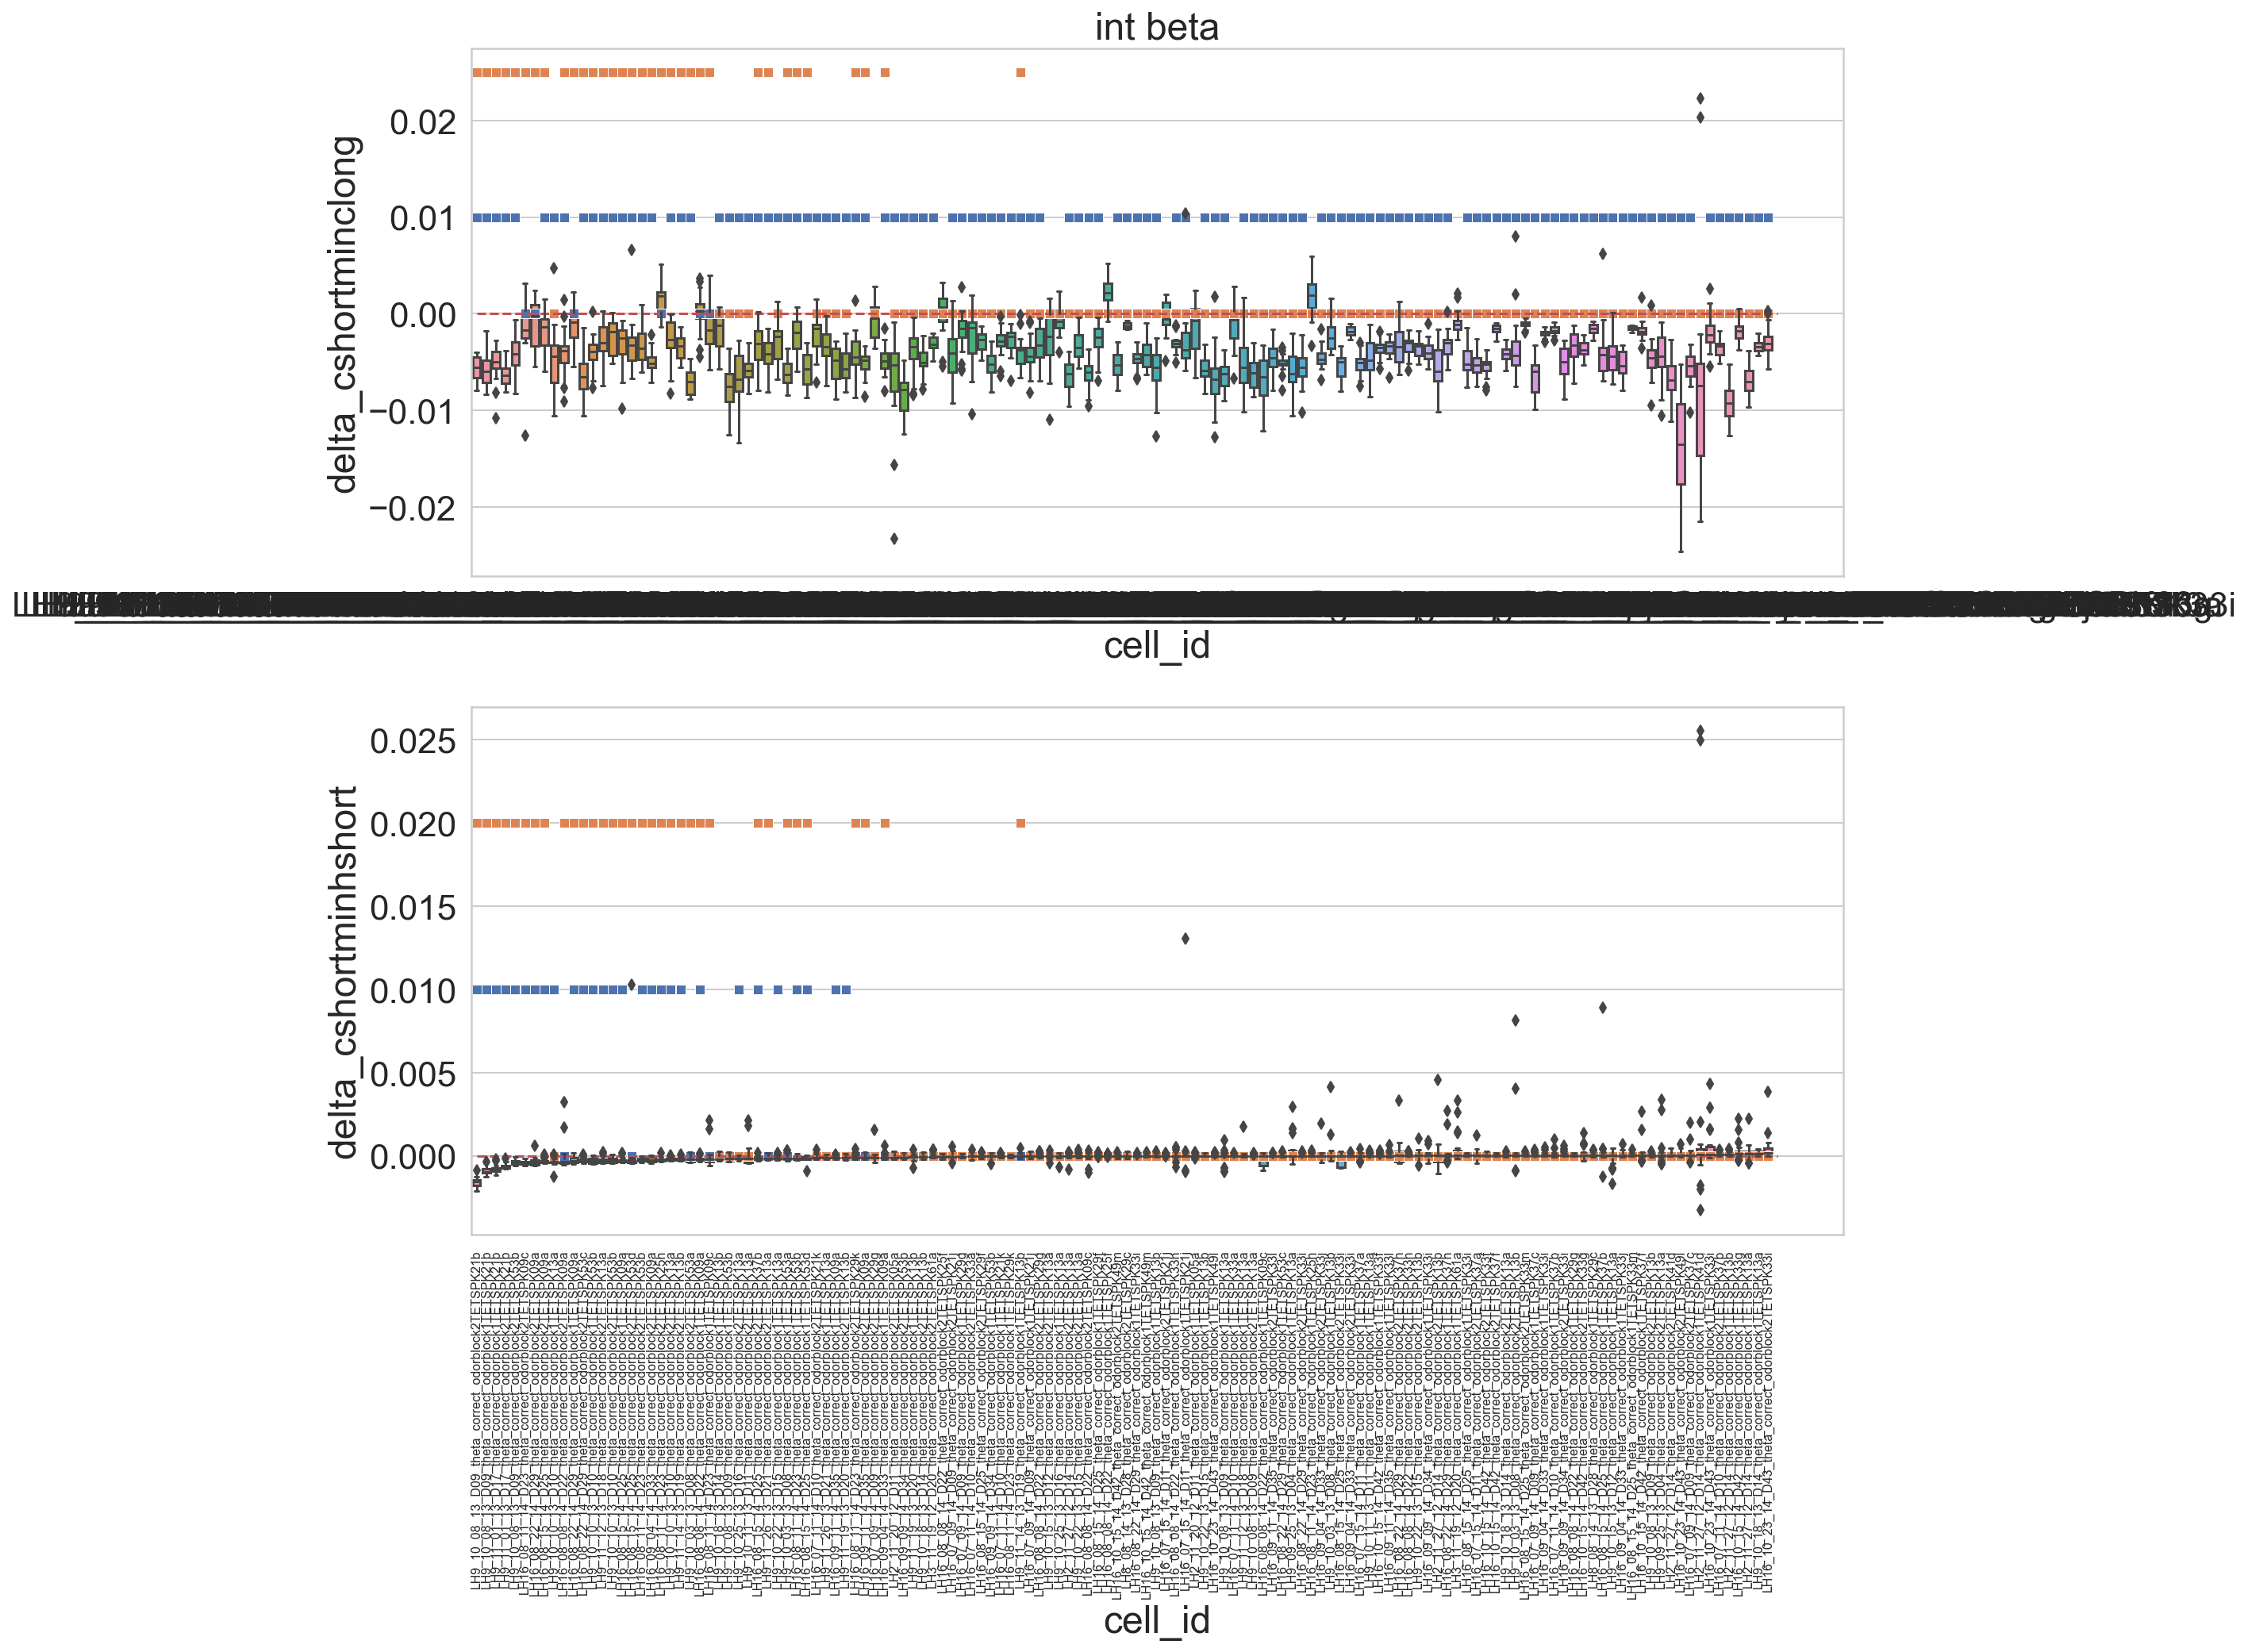

In [15]:
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(int_beta_cshortminclong_results_df['cell_id'].to_list()))


sns.boxplot(data=int_beta_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=int_beta_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[0]).set_title('int beta');

sns.scatterplot(data=int_beta_cshortminclong_ray_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[0])

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=int_beta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=int_beta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s",
                ax=ax[1])

sns.scatterplot(data=int_beta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')


fig.tight_layout()
fig.savefig('int_beta_loglossdeltas_orderBy_median_cshortminhshort_pvals_Ray_and_ttest.pdf')


What are the cells for which mrl and complete short models are significant? Which ones have discrepancies?

In [29]:
tmpttest = int_beta_all_results_df[int_beta_all_results_df['significant']==1]
len(list(set(tmpttest['cell_id'].to_list())))

28

In [28]:
tmpray = int_beta_all_results_df[int_beta_all_results_df['ray_significant_scaled']==1]
len(list(set(tmpray['cell_id'].to_list())))

33

In [30]:
ttest_sigcells = list(set(tmpttest['cell_id'].to_list()))
ray_sigcells = list(set(tmpray['cell_id'].to_list()))

ttest_multiset = collections.Counter(ttest_sigcells)
ray_multiset = collections.Counter(ray_sigcells)

overlap = list((ttest_multiset & ray_multiset).elements())
ttest_remainder = list((ttest_multiset - ray_multiset).elements())
ray_remainder = list((ray_multiset - ttest_multiset).elements())


In [34]:
pprint(ray_remainder)

['LH9_11_14_13_D19_theta_correct_odorblock1TETSPK13b',
 'LH9_10_03_13_D08_theta_correct_odorblock2TETSPK53a',
 'LH16_08_11_14_D23_theta_correct_odorblock2TETSPK29k',
 'LH16_08_11_14_D23_theta_correct_odorblock1TETSPK09c',
 'LH9_10_03_13_D08_theta_correct_odorblock1TETSPK53a',
 'LH16_09_04_14_D33_theta_correct_odorblock1TETSPK09a',
 'LH16_08_15_14_D25_theta_correct_odorblock2TETSPK53d',
 'LH9_11_26_13_D21_theta_correct_odorblock2TETSPK13a',
 'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a',
 'LH16_09_11_14_D35_theta_correct_odorblock2TETSPK09a']


In [35]:
pprint(ttest_remainder)

['LH9_10_25_13_D16_theta_correct_odorblock2TETSPK13a',
 'LH16_09_11_14_D35_theta_correct_odorblock1TETSPK09a',
 'LH9_10_10_13_D10_theta_correct_odorblock1TETSPK13a',
 'LH9_11_19_13_D20_theta_correct_odorblock2TETSPK13b',
 'LH9_10_22_13_D15_theta_correct_odorblock1TETSPK13a']


In [36]:
pprint(overlap)

['LH9_11_01_13_D17_theta_correct_odorblock1TETSPK21b',
 'LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c',
 'LH9_11_14_13_D19_theta_correct_odorblock2TETSPK13b',
 'LH16_08_11_14_D23_theta_correct_odorblock2TETSPK25h',
 'LH16_08_22_14_D29_theta_correct_odorblock2TETSPK09a',
 'LH16_08_11_14_D23_theta_correct_odorblock1TETSPK53b',
 'LH16_08_15_14_D25_theta_correct_odorblock1TETSPK53d',
 'LH9_10_08_13_D09_theta_correct_odorblock2TETSPK53b',
 'LH16_08_15_14_D25_theta_correct_odorblock1TETSPK09a',
 'LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a',
 'LH9_10_10_13_D10_theta_correct_odorblock2TETSPK53b',
 'LH16_08_15_14_D25_theta_correct_odorblock2TETSPK37b',
 'LH16_08_15_14_D25_theta_correct_odorblock2TETSPK09a',
 'LH9_10_08_13_D09_theta_correct_odorblock1TETSPK21b',
 'LH9_11_12_13_D18_theta_correct_odorblock2TETSPK13a',
 'LH16_09_04_14_D33_theta_correct_odorblock2TETSPK09a',
 'LH9_10_08_13_D09_theta_correct_odorblock2TETSPK21b',
 'LH9_10_10_13_D10_theta_correct_odorblock1TETSPK53b',


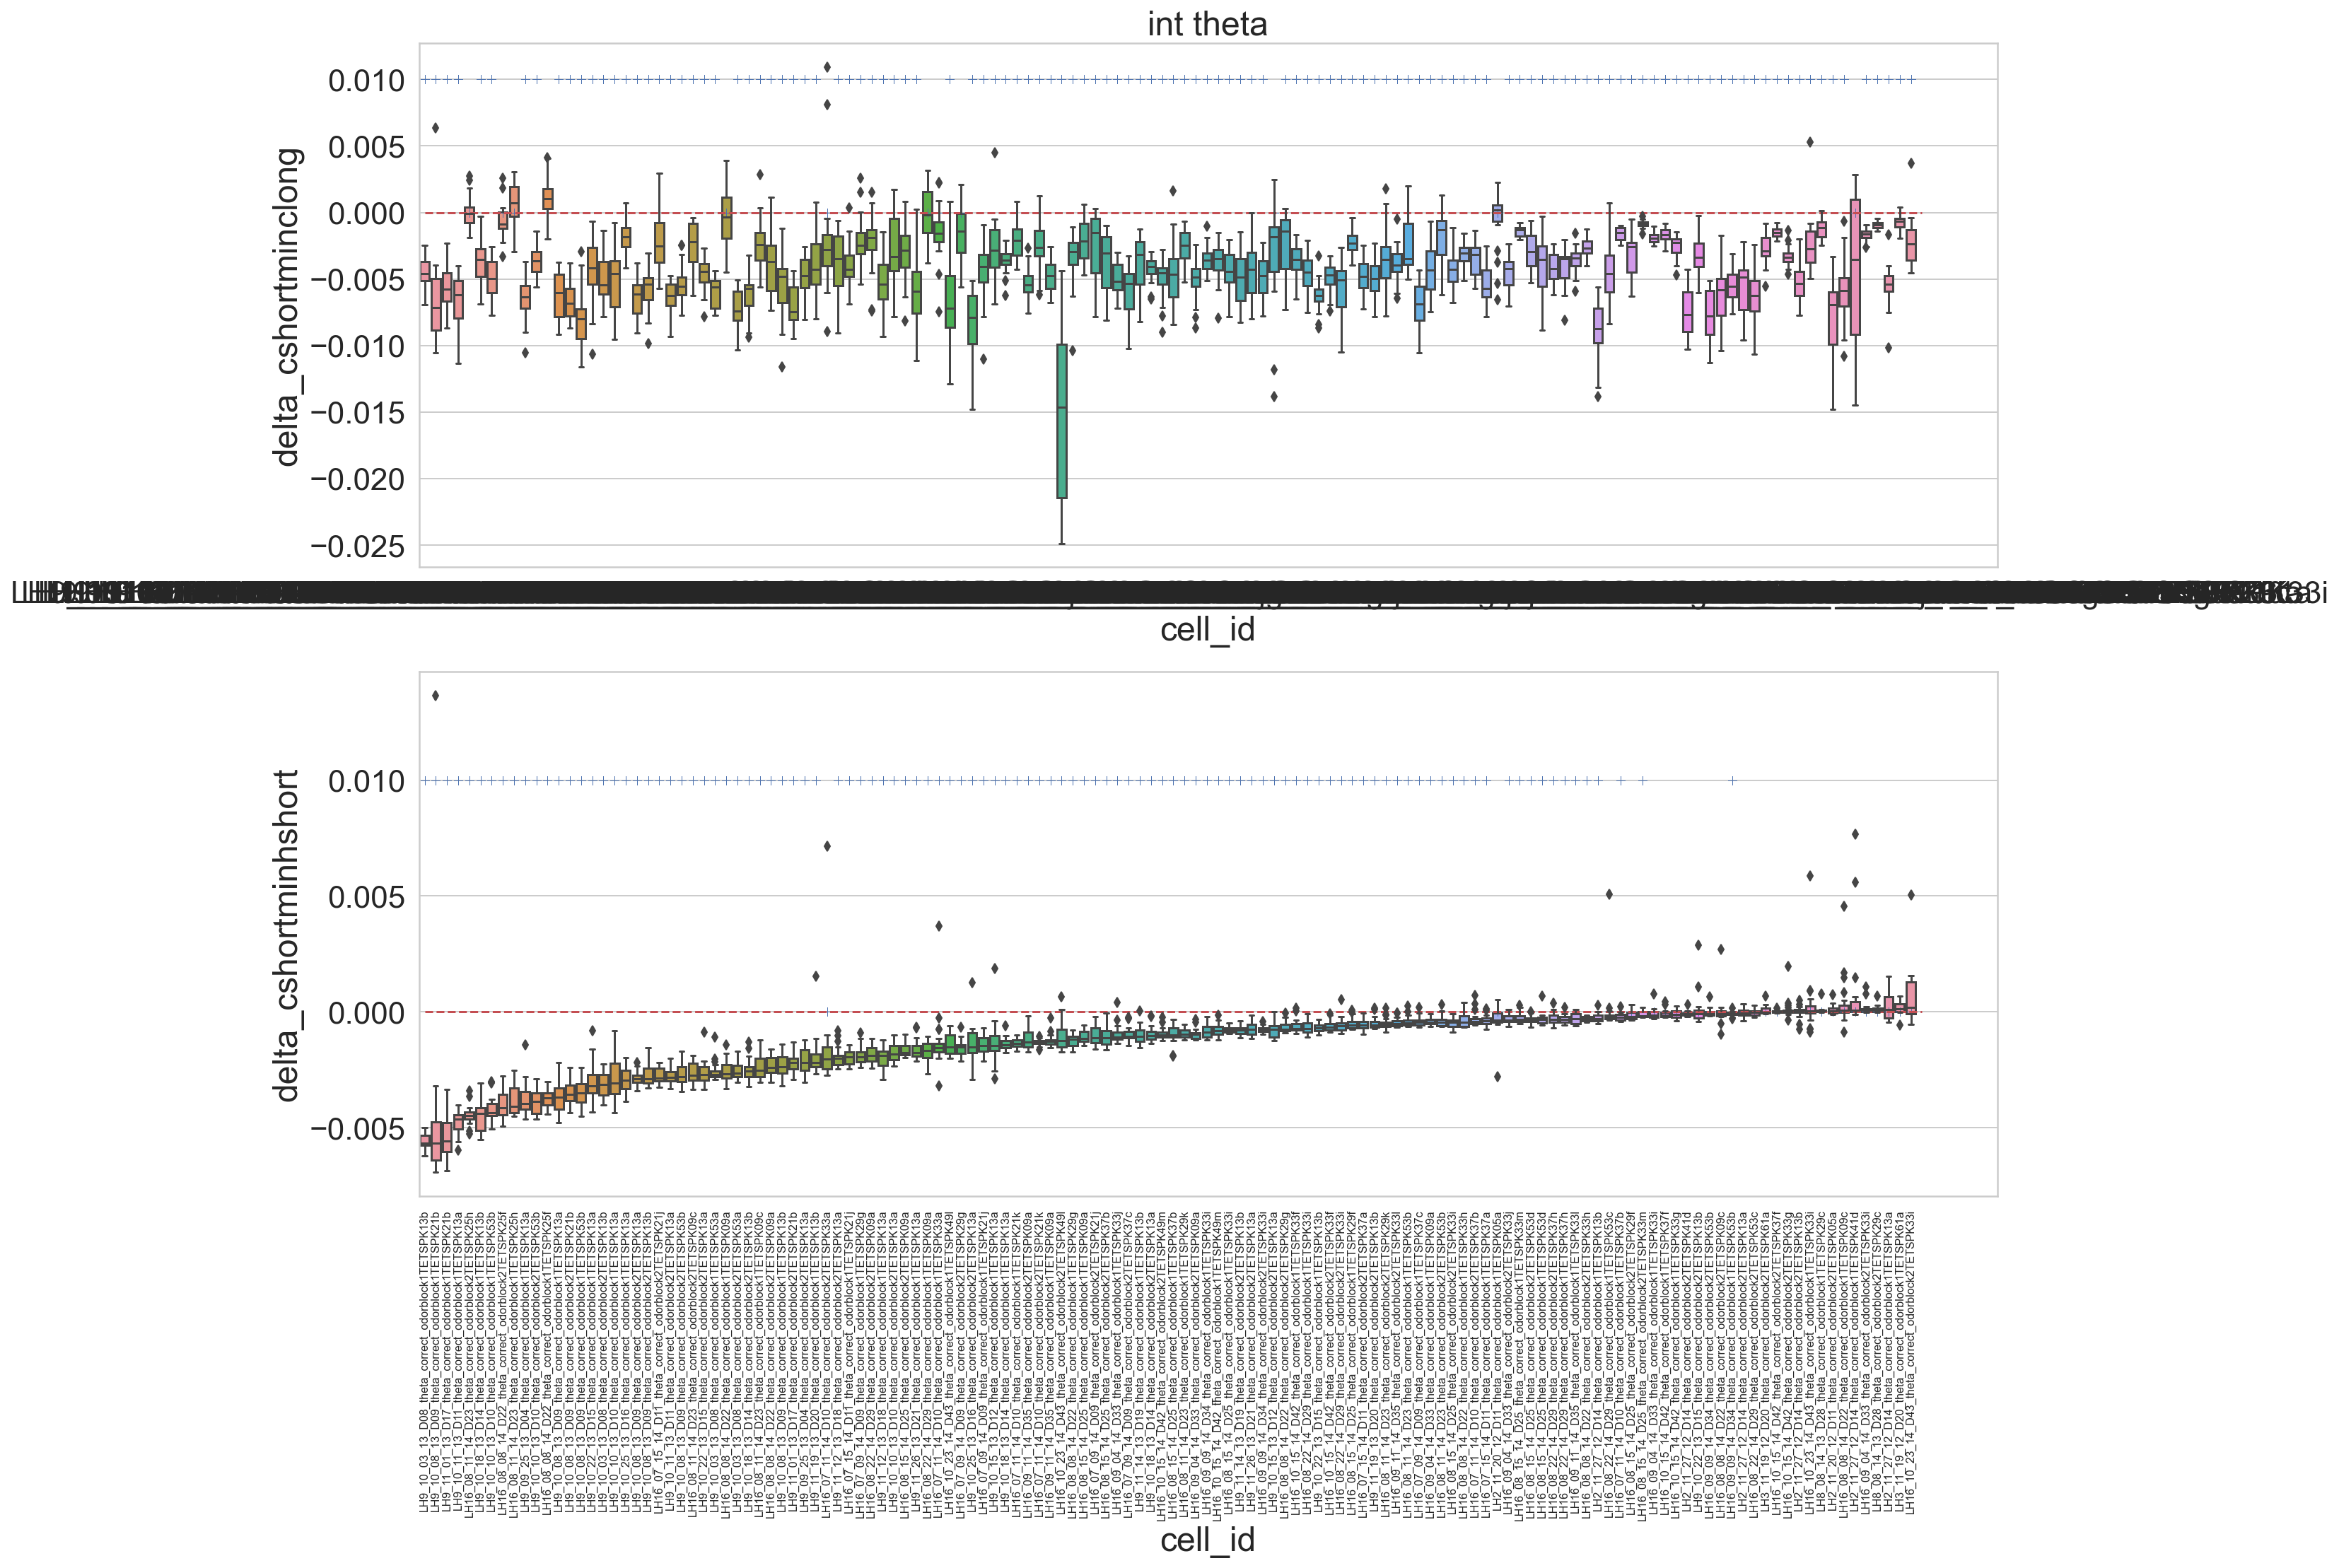

In [6]:
# sns.set_style('whitegrid')
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(int_theta_deltas_df['cell_id'].to_list()))


sns.boxplot(data=int_theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=int_theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[0]).set_title('int theta');

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=int_theta_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=int_theta_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')


# fig.savefig('int_theta_loglossdeltas_orderBy_median_cshortminhshort.pdf')



In [26]:
subfold = int_theta_results_df[int_theta_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort') 

subfold = int_theta_cshortminclong_results_df[int_theta_cshortminclong_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong') 

0.7985074626865671 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort
0.9104477611940298 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong


In [27]:
int_lowgamma_deltas_df = pd.read_csv(os.path.join('RESULTS/logloss_deltas_lowgamma_20folds.csv'))

In [28]:
sig_thresh = 0.001
scale_sig_marks = 100
int_lowgamma_medians_df = int_lowgamma_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
int_lowgamma_results_df = makefig_population_loglossdeltas(int_lowgamma_deltas_df,
                                                    int_lowgamma_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


int_lowgamma_cshortminclong_results_df = makefig_population_loglossdeltas(int_lowgamma_deltas_df,
                                                                   int_lowgamma_medians_df,
                                                                   'delta_cshortminclong',
                                                                   sig_thresh,
                                                                   scale_sig_marks
                                                                  )

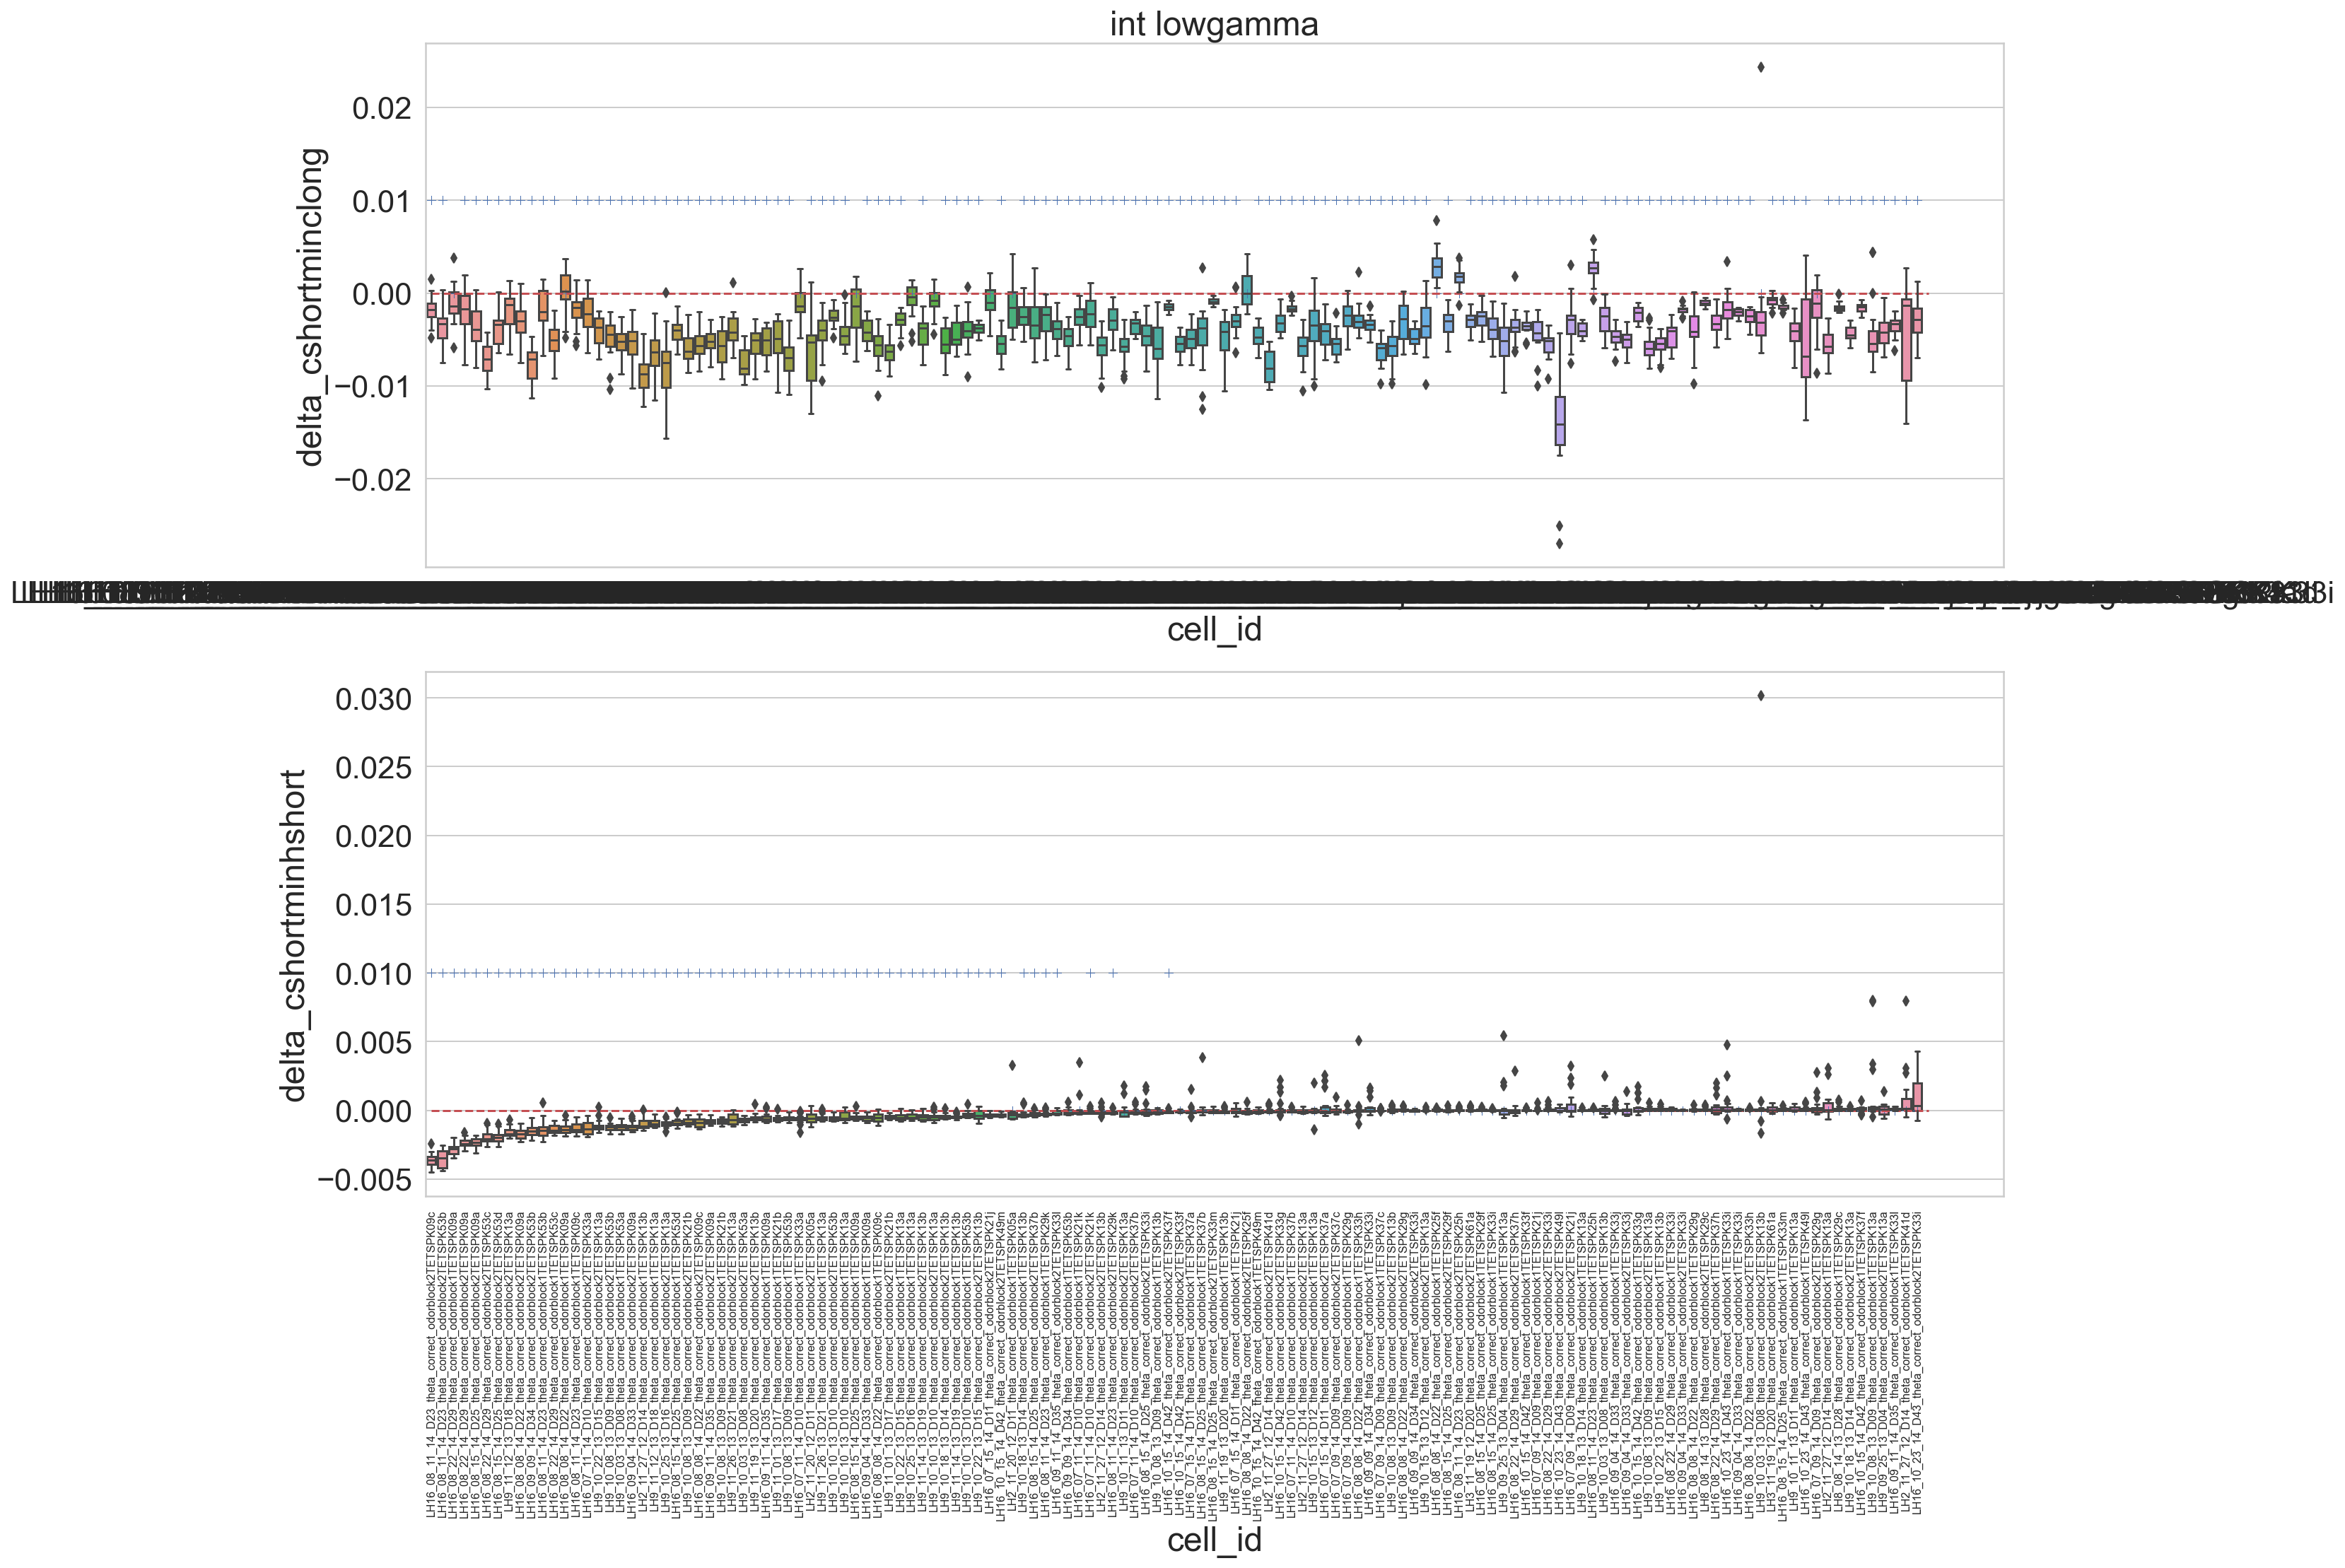

In [31]:
# sns.set_style('whitegrid')
sns.set(style='whitegrid',font_scale = 2)
fig, ax = plt.subplots(2,1,figsize=(20,15))

cell_list = list(set(int_lowgamma_deltas_df['cell_id'].to_list()))


sns.boxplot(data=int_lowgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminclong',
            ax=ax[0]);


sns.scatterplot(data=int_lowgamma_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[0]).set_title('int lowgamma');

ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=int_lowgamma_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort',
            ax=ax[1])


sns.scatterplot(data=int_lowgamma_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="+",
                ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

fig.savefig('int_lowgamma_loglossdeltas_orderBy_median_cshortminhshort.pdf')




In [30]:
subfold = int_lowgamma_results_df[int_lowgamma_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort') 

subfold = int_lowgamma_cshortminclong_results_df[int_lowgamma_cshortminclong_results_df['fold'] == 0]
print(subfold['significant'].sum()/subfold.shape[0], 
      '-- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong') 

0.44029850746268656 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and hshort
0.8955223880597015 -- proportion of cells with significantly smaller than 0 log loss delta between cshort and clong


## Rayleigh statistic

In [35]:
rhythm = 'theta'
longhist = '250ms'
deltas = []
for fold in tqdm(range(20)):

    foldpath = 'RESULTS/PhaseHistModels_AllCells_pyr_byOdorPos/pyrlogoddsCompleteSinglePredMdls244/' + rhythm + longhist + '/folds/' + str(fold) +'/single_neuron/'

    folders = os.listdir(foldpath)
    len(folders)
    
    for folder in folders:
        
        nrnpath = os.path.join(foldpath,folder)
        
        probs_test = pd.read_csv(os.path.join(nrnpath,'probs_models_test.csv'))
        
        test_data = pd.read_csv(os.path.join(nrnpath,'test_data.csv'))
        
        y = test_data['spikes']
        
        cshort_loss, _, _ = logloss(probs_test['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        clong_loss, _, _ = logloss(probs_test['p_clong'],y)
        
        tmp_delta_cshminhsh = cshort_loss - hshort_loss
        tmp_delta_cshmincln = cshort_loss - clong_loss
      
        hshort_loss, _, _ = logloss(probs_test['p_hshort'],y)
        
        all_kls = kl(probs_test['p_cshort'],probs_test['p_hshort'])
        avg_kl = np.mean(all_kls)
        
        deltas.append({'cell_id': folder,
                       'fold': fold,
                       'delta_cshortminhshort': tmp_delta_cshminhsh,
                       'delta_cshortminclong': tmp_delta_cshmincln,
                       'avg_kl_cshort_v_hshort': avg_kl
                      })
        
        
deltas_df = pd.DataFrame(deltas)

  0%|                                                    | 0/20 [00:00<?, ?it/s]/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:103: RuntimeWarning: divide by zero encountered in log2
  avg_loss += -np.log2(1 - probs[i])
/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:104: RuntimeWarning: divide by zero encountered in log2
  all_loss.append(-np.log2(1 - probs[i]))
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
 15%|██████▌                                     | 3/20 [02:00<11:22, 40.12s/it]/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:100: RuntimeWarning: divide by zero encountered in log2
  avg_loss += -np.log2(probs[i])
/Volumes/Sula/PhaseHistoryModeling/mdl_eval_tools.py:101: RuntimeWarning: divide by zero encountered in log2
  all_loss.append(-np.log2(probs[i]))
100%|███████████████████████████████████████████| 20/20 [12:43<00:00, 38.16s/it]


In [36]:
deltas_df.to_csv('RESULTS/loocv_theta_loglossdeltas_df.csv')


In [69]:
theta_deltas_df = pd.read_csv('RESULTS/loocv_theta_loglossdeltas_df.csv')

In [73]:
sig_thresh = 0.001
scale_sig_marks = 40
theta_medians_df = theta_deltas_df.groupby(["cell_id"])['delta_cshortminhshort'].median().reset_index()
theta_results_df = makefig_population_loglossdeltas(theta_deltas_df,
                                                    theta_medians_df,
                                                    'delta_cshortminhshort',
                                                    sig_thresh,
                                                    scale_sig_marks
                                                   )


# theta_cshortminclong_results_df = makefig_population_loglossdeltas(theta_deltas_df,
#                                                                    theta_medians_df,
#                                                                    'delta_cshortminclong',
#                                                                    sig_thresh,
#                                                                    scale_sig_marks
#                                                                   )



In [74]:
datapath = 'RESULTS/PhaseHistModels_AllCells_pyr_byOdorPos/pyrlogoddsCompleteSinglePredMdls452/theta250ms/folds/0/single_neuron/'
folders = os.listdir(datapath)
ray_df = []
for folder in tqdm(folders):
    
    df = pd.read_csv(os.path.join(datapath,folder,'raw_data.csv'))
    #rename the phase column to format: 
    #.   rhythm_low_high + '_phases
    df = df.rename(columns={"phase":"theta_4_12_phases"})
    
    tmp = rayleigh_pr(df,'theta_4_12')
    tmp['cell_id'] = folder
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)    

100%|███████████████████████████████████████████| 43/43 [00:10<00:00,  4.21it/s]


In [75]:
theta_all_results_df = pd.merge(theta_results_df, raypop_df, on='cell_id')

In [76]:
theta_all_results_df = make_significance_column(theta_all_results_df,'pval_y',0.001,50,'ray_significant_scaled')
    
    

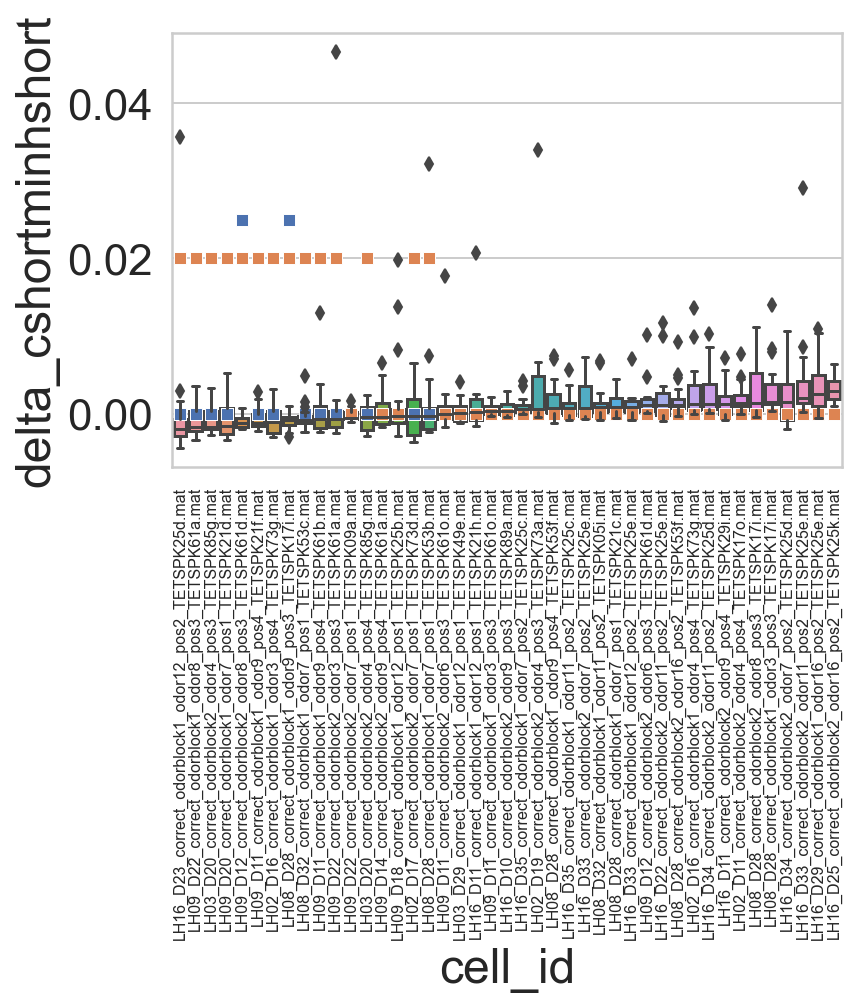

In [84]:
# sns.set(style='whitegrid',font_scale = 2)
# fig, ax = plt.subplots(2,1,figsize=(20,15))

# cell_list = list(set(theta_deltas_df['cell_id'].to_list()))


# sns.boxplot(data=theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
#             x='cell_id',
#             y='delta_cshortminclong',
#             ax=ax[0]);


# sns.scatterplot(data=theta_cshortminclong_results_df.sort_values(by='delta_cshortminhshort_median'),
#                 x='cell_id',
#                 y='significant_scaled',
#                 marker="+",
#                 ax=ax[0]).set_title('pyr by OdorPos lowgamma');

# ax[0].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')

sns.boxplot(data=theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
            x='cell_id',
            y='delta_cshortminhshort')#,
#             ax=ax[1])


sns.scatterplot(data=theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='significant_scaled',
                marker="s")#,
#                 ax=ax[1])

sns.scatterplot(data=theta_all_results_df.sort_values(by='delta_cshortminhshort_median'),
                x='cell_id',
                y='ray_significant_scaled_scaled',
                marker="s")#,
#                 ax=ax[1])

plt.xticks(rotation=90,fontsize=8)

ax[1].hlines(y=0,xmin=0,xmax=len(cell_list),linestyles='dashed',color='r')



# fig.savefig('pyr_byOdorPos_lowgamma_loglossdeltas_orderBy_median_cshortminhshort.pdf')


In [86]:
theta_all_results_df.head(50)

Unnamed: 0                                               cell_id  fold  \
0            2  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     0   
1          127  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     1   
2          252  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     2   
3          377  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     3   
4          501  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     4   
5          625  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     5   
6          748  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     6   
7          867  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     7   
8          986  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     8   
9         1105  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat     9   
10        1223  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    10   
11        1329  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    11   
12        1435  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    12   
13        1541  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    13   
14        1647  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    14   
15        1753  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    15   
16        1859  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    16   
17        1965  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    17   
18        2071  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    18   
19        2177  LH02_D11_correct_odorblock2_odor4_pos4_TETSPK17o.mat    19   
20           4  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     0   
21         129  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     1   
22         254  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     2   
23         379  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     3   
24         503  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     4   
25         627  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     5   
26         750  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     6   
27         869  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     7   
28         988  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     8   
29        1107  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat     9   
30        1225  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    10   
31        1331  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    11   
32        1437  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    12   
33        1543  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    13   
34        1649  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    14   
35        1755  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    15   
36        1861  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    16   
37        1967  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    17   
38        2073  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    18   
39        2179  LH02_D16_correct_odorblock1_odor3_pos4_TETSPK73g.mat    19   
40           6  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     0   
41         131  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     1   
42         256  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     2   
43         381  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     3   
44         505  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     4   
45         629  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     5   
46         752  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     6   
47         871  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     7   
48         990  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     8   
49        1109  LH02_D16_correct_odorblock1_odor4_pos4_TETSPK73g.mat     9   

    delta_cshortminhshort

In [79]:
cell_labels = set(theta_all_results_df['cell_id'].to_list())

In [81]:
len(cell_labels)

43

In [83]:
theta_all_results_df[theta_all_results_df['cell_id'] == 'LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat']

Unnamed: 0                                               cell_id  fold  \
430          56  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     0   
431         181  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     1   
432         306  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     2   
433         431  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     3   
434         555  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     4   
435         679  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     5   
436         802  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     6   
437         921  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     7   
438        1040  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     8   
439        1159  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     9   
440        1272  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    10   
441        1378  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    11   
442        1484  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    12   
443        1590  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    13   
444        1696  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    14   
445        1802  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    15   
446        1908  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    16   
447        2014  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    17   
448        2120  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    18   
449        2226  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    19   

     delta_cshortminhshort  delta_cshortminclong  avg_kl_cshort_v_hshort  \
430              -0.000630             -0.051260                0.002416   
431              -0.000517             -0.065827                0.002572   
432              -0.001639             -0.060472                0.001402   
433              -0.001377             -0.073388                0.001670   
434               0.000240             -0.075763                0.003078   
435              -0.001943             -0.072296                0.001232   
436              -0.000863             -0.063669                0.001765   
437              -0.001746             -0.082240                0.001395   
438               0.000705             -0.076924                0.002863   
439              -0.002002             -0.080259                0.000797   
440              -0.000424             -0.020683                0.002982   
441              -0.001049             -0.024513                0.001910   
442              -0.001622             -0.029247                0.001858   
443              -0.000838             -0.027799                0.002002   
444              -0.001160             -0.032691                0.002191   
445              -0.001743             -0.041605                0.001167   
446              -0.001331             -0.063702                0.001874   
447              -0.000118             -0.040505                0.003397   
448              -0.001999             -0.058881                0.000984   
449              -0.001634             -0.061763                0.001453   

     delta_cshortminhshort_median     tstat    pval_x  significant  \
430                     -0.001246 -6.287772  0.000002            1   
431                     -0.001246 -6.287772  0.000002            1   
432                     -0.001246 -6.287772  0.000002            1   
433                     -0.001246 -6.287772  0.000002            1   
434                     -0.001246 -6.287772  0.000002            1   
435                     -0.001246 -6.287772  0.000002            1   
436                     -0.001246 -6.287772  0.000002            1   
437                     -0.001246 -6.287772  0.000002            1   
438                     -0.001246 -6.287772  0.000002            1   
439                     -0.001246 -6.287772  0.0

In [19]:
theta_all_results_df[theta_all_results_df['cell_id'] == 'LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat']

Unnamed: 0                                               cell_id  fold  \
430          22  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     0   
431          65  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     1   
432         108  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     2   
433         151  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     3   
434         194  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     4   
435         237  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     5   
436         280  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     6   
437         323  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     7   
438         366  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     8   
439         409  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat     9   
440         451  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    10   
441         493  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    11   
442         535  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    12   
443         577  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    13   
444         619  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    14   
445         661  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    15   
446         703  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    16   
447         745  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    17   
448         787  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    18   
449         829  LH09_D12_correct_odorblock2_odor8_pos3_TETSPK61d.mat    19   

     delta_cshortminhshort  delta_cshortminclong  avg_kl_cshort_v_hshort  \
430              -0.000630             -0.051260                0.002416   
431              -0.000570             -0.066110                0.002243   
432              -0.001652             -0.061010                0.001190   
433              -0.001335             -0.073568                0.001515   
434              -0.000616             -0.075797                0.001993   
435              -0.001987             -0.072955                0.000975   
436              -0.001120             -0.064074                0.001336   
437              -0.001668             -0.082287                0.001322   
438              -0.000265             -0.077226                0.001884   
439              -0.001944             -0.080325                0.000773   
440              -0.000472             -0.020661                0.002646   
441              -0.001041             -0.024571                0.001771   
442              -0.001586             -0.029245                0.001750   
443              -0.000772             -0.027881                0.001914   
444              -0.001095             -0.032796                0.001955   
445              -0.001690             -0.041645                0.001140   
446              -0.001151             -0.063804                0.001702   
447              -0.001204             -0.040036                0.001768   
448              -0.001877             -0.059010                0.000933   
449              -0.001649             -0.061977                0.001247   

     delta_cshortminhshort_median      tstat        pval_x  significant  \
430                     -0.001178 -10.244959  1.779460e-09            1   
431                     -0.001178 -10.244959  1.779460e-09            1   
432                     -0.001178 -10.244959  1.779460e-09            1   
433                     -0.001178 -10.244959  1.779460e-09            1   
434                     -0.001178 -10.244959  1.779460e-09            1   
435                     -0.001178 -10.244959  1.779460e-09            1   
436                     -0.001178 -10.244959  1.779460e-09            1   
437                     -0.001178 -10.244959  1.779460e-09            1   
438                     -0.001178 -10.244959  1.779460e-09            1  

In [40]:
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/logoddsCompleteSinglePredMdls682/lowgamma250ms/folds/0/single_neuron/'



In [41]:
folders = os.listdir(datapath)
len(folders)

134

In [78]:
ray_df = []
for folder in tqdm(folders):
    
    df = pd.read_csv(os.path.join(datapath,folder,'raw_data.csv'))
    #rename the phase column to format: 
    #.   rhythm_low_high + '_phases
    df = df.rename(columns={"phase":"theta_4_12_phases"})
    
    tmp = rayleigh_pr(df,'theta_4_12')
    tmp['cell_id'] = folder
    ray_df.append(tmp)
    
raypop_df = pd.concat(ray_df)    

100%|█████████████████████████████████████████| 134/134 [04:24<00:00,  1.97s/it]


In [90]:
int_all_theta_results = pd.merge(int_theta_results_df, raypop_df, on='cell_id')